# ANALYSIS OF A TRAJECTORY

# General Procedure

The input of this notebook is a 3D trajectory (which __must be in SI__) of a Brownian colloid diffusing on top of a wall. 

The idea is to fit several observables at the same time, since these observables depend on the same parameters $B$, $l_\mathrm{D}$, $l_\mathrm{B}$, and the offsets $z_0$ and $b$. These offsets accounts for experimental noise, either during the experiment, the tracking or the analysis. 

The simultaneous fitting procedure was implemented by Maxime Lavaud during his PhD (see eXpensia on Github). Slight changes may occur, such as using a different minimization algorithm or adding observables (_e.g._ fourth-order cumulants) to the multifitting procedure. 

In addition of those slight changes, the multifitting procedure is repeated several times with different initial conditions to insure that the overall procedure leads to the global minimum (stability of the minimum found).

# Importations

In [1]:
# /!\
# tautau is a variable that should not be used.
# Variable taken for the non-conservative forces.
# And re-used several times in the code!
# /!\

In [2]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit, minimize, least_squares
from scipy.integrate import trapezoid
from tqdm import tqdm
from scipy.optimize import fsolve
import os 

In [3]:
from StochasticForceInference.StochasticForceInference import *
from StochasticForceInference.fun_SFI import Compute_diffusion
# Get the SFI package on Maxime's Github (eXpensia). 

In [4]:
import ComputeObservables as co
# Personnal .py with functions used to compute observables (PDF, forces, etc.). 
# Copy past the .py in site-packages or in the same floder as the notebook.

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=1)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=200)

# Load the data

In [6]:
directory = '../../analysis_droplets/traj_oil_droplets/PS_water/20230310_traj_3_fps_100/traj_rp_1p4749_np_1p5812.mat'
filename = directory[directory.rfind('/')+1:]

In [7]:
path = '../1_multifit/'

directories = os.listdir(path)
directories = [path + d for d in directories if 'data_exp_ALL' in d]

directories = [d for d in directories if 'spincoated' in d]
directories = [d for d in directories if 'washed' not in d]

def function(d):
    res = d[d.find('ratioBC_')+len('ratioBC_'):d.find('ratioBC_')+len('ratioBC_')+2]
    res = int(res)
    return res

directories.sort(key=function)

for i, d in enumerate(directories):
    print(i, '  ', d)

0    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_20_exp_20230113_analysis_20230117_traj_rp_1p4922_np_1p582.mat
1    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_26_exp_20221107_MAXIME_LAST_analysis_20221108.mat
2    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_30_exp_20221101_MAXIME_analysis_20221122.mat
3    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_34.4_exp_20221101_MAXIME_11_analysis_20221123.mat
4    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_34.4_exp_20221101_MAXIME_analysis_20221124_traj_rp_1p5255_np_1p5846.mat
5    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_34.4_exp_20221101_MAXIME_analysis_20221124_4.mat
6    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_34.4_exp_20221101_MAXIME_analysis_20221124_traj_rp_1p5188_np_1p5804.mat
7    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_40_exp_20230111_analysis_20230112_traj_rp_1p5281_np_1p577.mat
8    ../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_40_exp_20230111_analysis_20230112_

In [8]:
# directory = directories[5]
# filename = directory[len(path):]

In [9]:
filename

'traj_rp_1p4749_np_1p5812.mat'

In [10]:
# temp = loadmat(directory, squeeze_me=True)

# print(temp['r'])

In [11]:
##########

#####

#

r = float(filename[filename.find('_rp_')+4:filename.find('_np_')].replace('p','.')) * 1e-6
# r = 1.5255e-6

# ratioBC = function(directory)
ratioBC = None

drho = 50
rho_m = 1000
eta_m = 0.00093
fps = 100
date = 20230113
date_auj = 20250819
exp_kind = 'PDMS Spincoated, B/C = {1}, PS (diameter {0} µm) in water'.format(np.round(2*r*1e6,1), ratioBC) 

# calib = 0.0513 # µm/px
# calib = 0.0532
# calib = 0.594
calib = 0.05799
# calib = 0.05789
# calib = 0.058

print(r)
print(exp_kind)

date = str(date)
date_auj = str(date_auj)

# 

#####

##########

1.4749e-06
PDMS Spincoated, B/C = None, PS (diameter 2.9 µm) in water


In [12]:
# If data from xyz .mat

raw_data = co.open_xyz_mat(directory, upward=False, version='new')

raw_data = raw_data #* calib * 1e-6



# If data from ``already-analyzed'' .mat 

# raw_data = np.zeros((len(temp['xraw']), 3))

# raw_data[:,0] = np.copy(temp['xraw'])
# raw_data[:,1] = np.copy(temp['yraw'])
# raw_data[:,2] = np.copy(temp['zraw'])

# del temp

In [13]:
raw_data

array([[3.32533116e-05, 5.06646046e-05, 1.29745872e-05],
       [3.32575187e-05, 5.07489626e-05, 1.29760050e-05],
       [3.32318143e-05, 5.08002015e-05, 1.29747498e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(126440, 3))

In [14]:
# Remove zeros at the end of the trajectory:
try:
    ind = list(raw_data[:,0]).index(0)
    raw_data = raw_data[:ind,:]
except ValueError:
    print('No pb. No zero in raw data.')

In [15]:
raw_data = raw_data[:120000,:]

In [16]:
N_tot_frames = len(raw_data[:, 0])
frames = np.arange(N_tot_frames)
time = np.arange(0, np.shape(raw_data)[0]) / fps

In [17]:
# Reference 
directory_ref = ''
filename_ref = directory_ref[directory_ref.rfind('/')+1:]
# If you don't have a reference, the reference's trajectory is set to zeros later in the code.

In [18]:
# Load the trajectory of the reference
# For now, it is not used. 
# The trajectory of the reference is artificially set to zero.
try:
    raw_data_ref = loadmat(directory_ref)["data"][:len(raw_data[:, 0]):, 0:3]
except FileNotFoundError as err:
    print(err)
    raw_data_ref = np.zeros(np.shape(raw_data))
    print()
    print('The trajectory of the reference has been set to zero')
except:
    print("Unknow error!")

# Use SI
# /!\ Conversion only necessary for traj before 2021
raw_data_ref = raw_data_ref * calib * 1e-6

print()
print("/!\ Check units of the ref:")
print("First x, y, z = {}".format(raw_data_ref[0,:]))

[Errno 2] No such file or directory: '.mat'

The trajectory of the reference has been set to zero

/!\ Check units of the ref:
First x, y, z = [0. 0. 0.]


In [19]:
# Initialize the save (in a dictionnary)
where_to_save_the_data = "./"
tosave = {}

In [20]:
# Set garde fou to modify and/or compute some data only once.
garde_fou_1 = True
garde_fou_2 = True
garde_fou_3 = True
garde_fou_4 = True

In [21]:
# Save data

tosave['filename'] = filename
tosave["fps"] = fps
tosave["calib"] = calib

tosave["date_experiment"] = date
tosave["date_analysis"] = date_auj

tosave["r"] = r

tosave["N_tot_frames"] = N_tot_frames
tosave["frames"] = np.copy(frames)
tosave["time"] = np.copy(time)

tosave["ratioBC"] = ratioBC

# __Watch the Raw Trajectory__

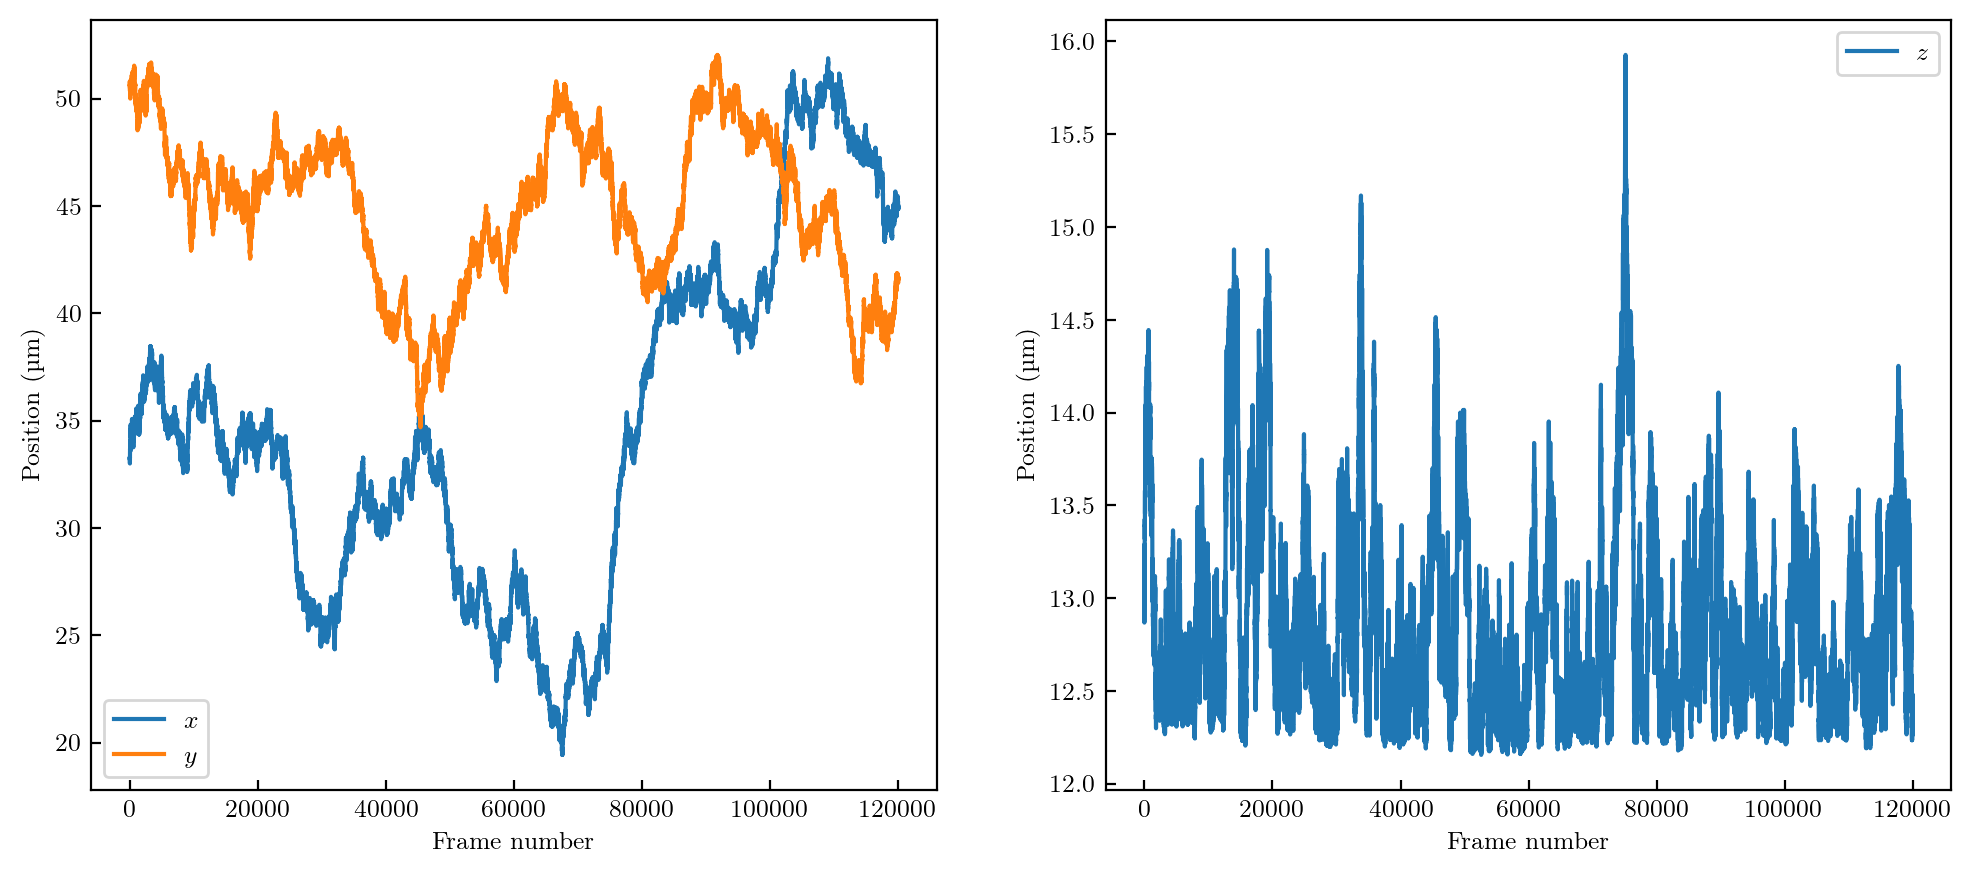

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axx, axz = axes[0], axes[1]

# fig.canvas.toolbar_visible = True
# fig.canvas.header_visible = True
# fig.canvas.resizable = True

axx.plot(time * fps, raw_data[:, 0] * 1e6, label="$x$")
axx.plot(time * fps, raw_data[:, 1] * 1e6, label="$y$")
axz.plot(time * fps, raw_data[:, 2] * 1e6, label="$z$")

axx.set_xlabel("Frame number")
axx.set_ylabel("Position (µm)")
axz.set_xlabel("Frame number")
axz.set_ylabel("Position (µm)")

axx.legend()
axz.legend()

plt.show() 

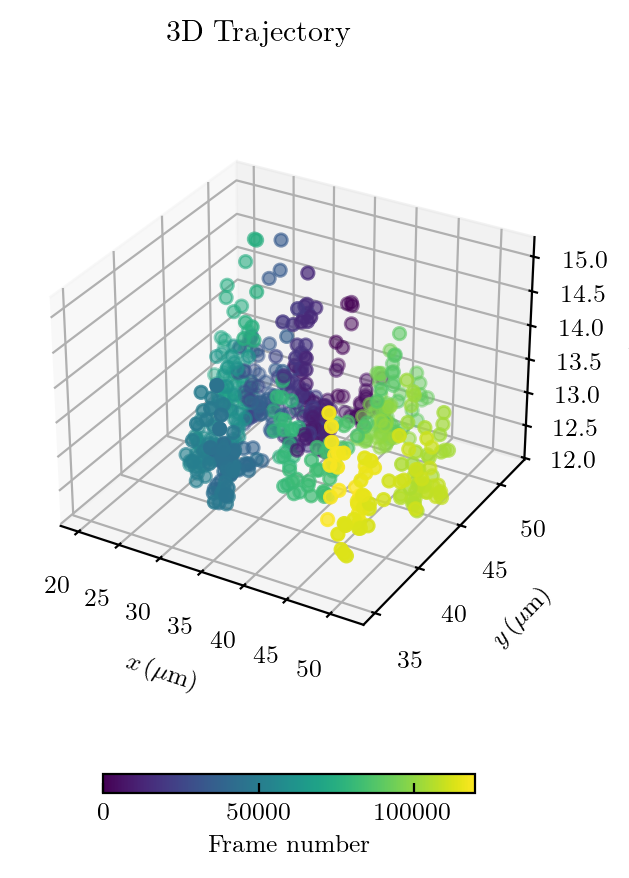

In [23]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection='3d')

ax.scatter3D(raw_data[::200, 0] * 1e6, raw_data[::200, 1] * 1e6, raw_data[::200, 2] * 1e6, c=frames[::200])

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=frames[-1]), cmap=mpl.cm.viridis), 
             ax=ax, orientation='horizontal', shrink=0.2, 
             label="Frame number"
            )

ax.set_xlabel("$x \, \mathrm{(\mu m)}$")
ax.set_ylabel("$y \, \mathrm{(\mu m)}$")
ax.set_zlabel("$z \, \mathrm{(\mu m)}$")

fig.suptitle("3D Trajectory")

plt.show()

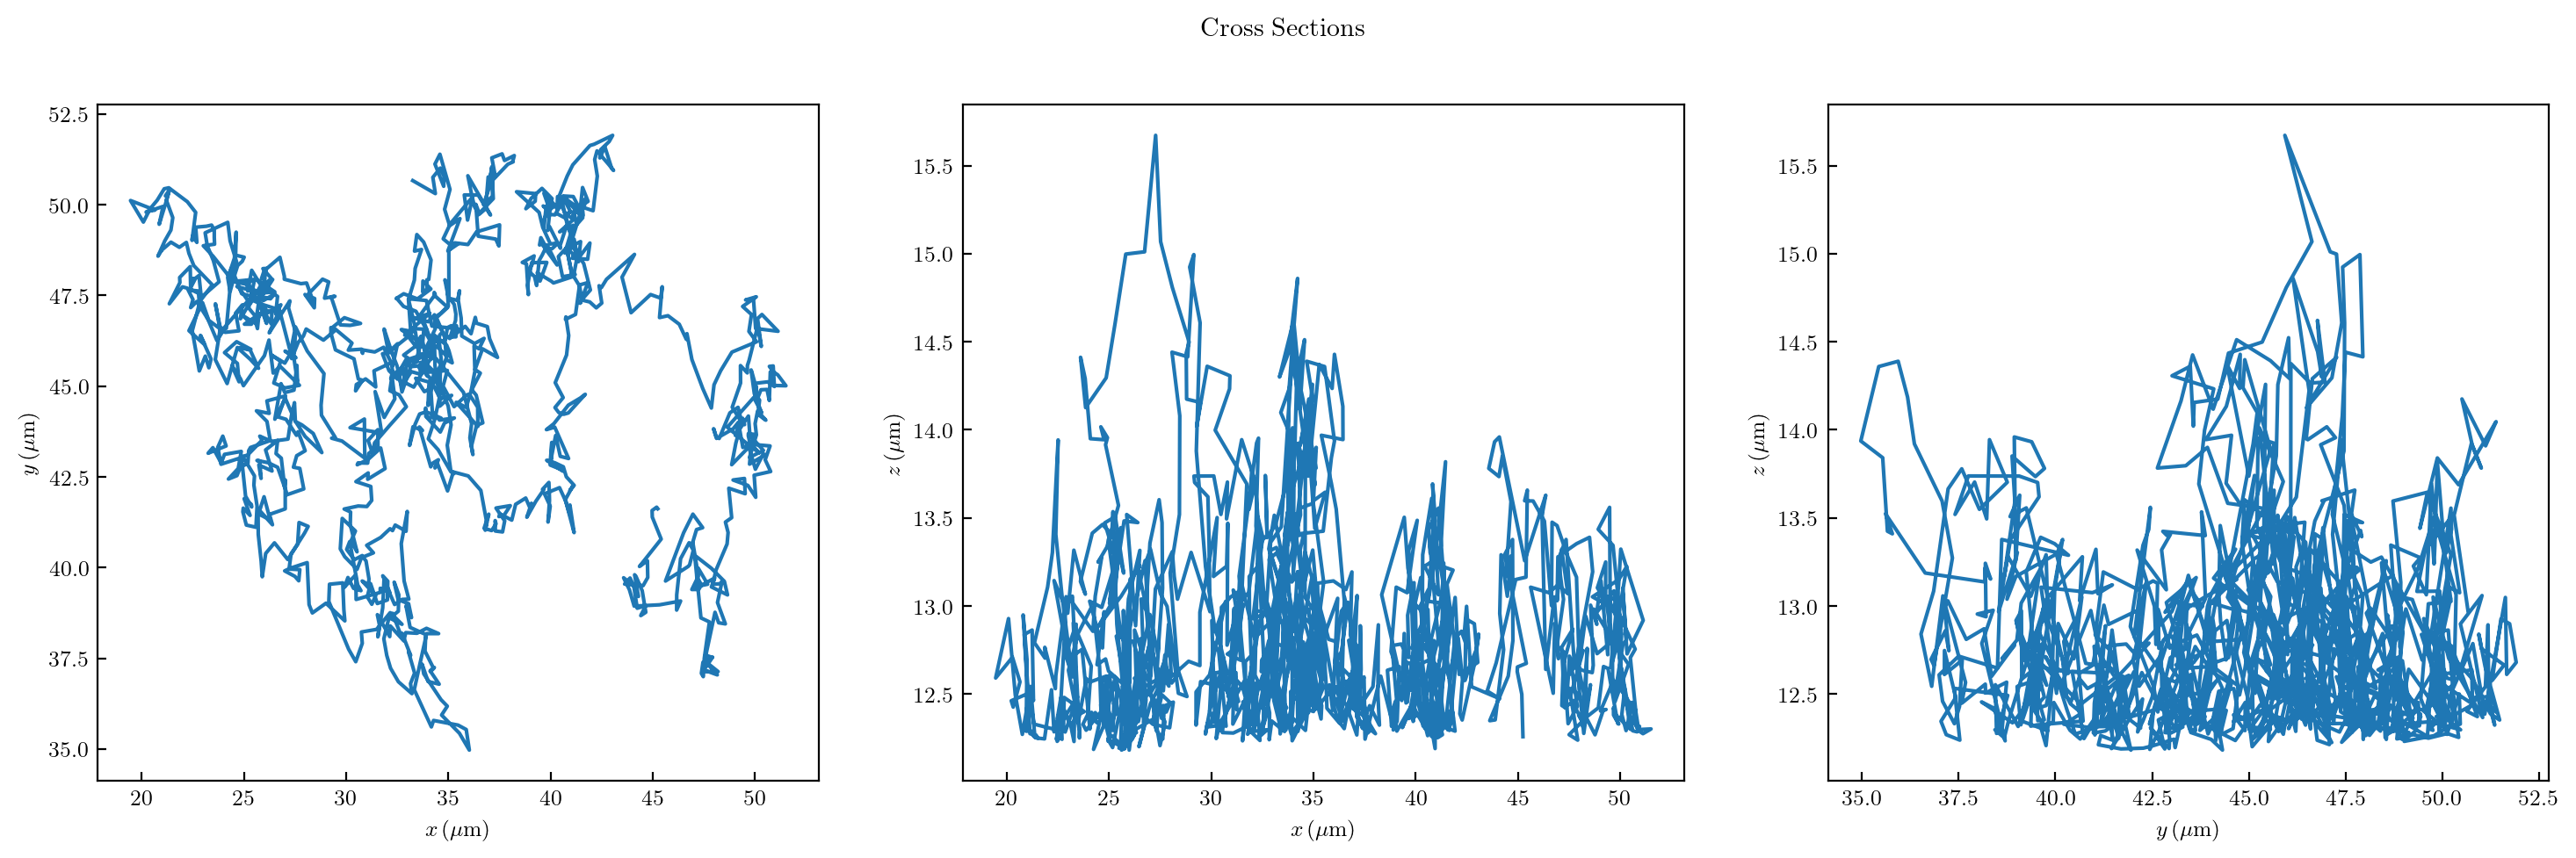

In [24]:
# Profiles of the trajectory

fig, axes = plt.subplots(1, 3, figsize=(18,5))
axxy, axxz, axyz = axes[0], axes[1], axes[2]

axxy.plot(raw_data[::100, 0] * 1e6, raw_data[::100, 1] * 1e6)
axxz.plot(raw_data[::100, 0] * 1e6, raw_data[::100, 2] * 1e6)
axyz.plot(raw_data[::100, 1] * 1e6, raw_data[::100, 2] * 1e6)

axxy.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axxz.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxz.set_ylabel("$z \, \mathrm{(\mu m)}$")
axyz.set_xlabel("$y \, \mathrm{(\mu m)}$")
axyz.set_ylabel("$z \, \mathrm{(\mu m)}$")

fig.suptitle("Cross Sections")

plt.show()

# __Correct Trajectories__

## If the Bottom Surface is Tilted And/Or Not Flat

In [25]:
# Get the 'bottom' of each coordinate

nb_moving = 10000

smooth_x = co.movmin(raw_data[:, 0], nb_moving)
#smooth_x = smooth_x - np.nanmin(smooth_x)
smooth_y = co.movmin(raw_data[:, 1], nb_moving)
#smooth_y = smooth_y - np.nanmin(smooth_y)
smooth_z = co.movmin(raw_data[:, 2], nb_moving)
#smooth_z = smooth_z - np.nanmin(smooth_z)

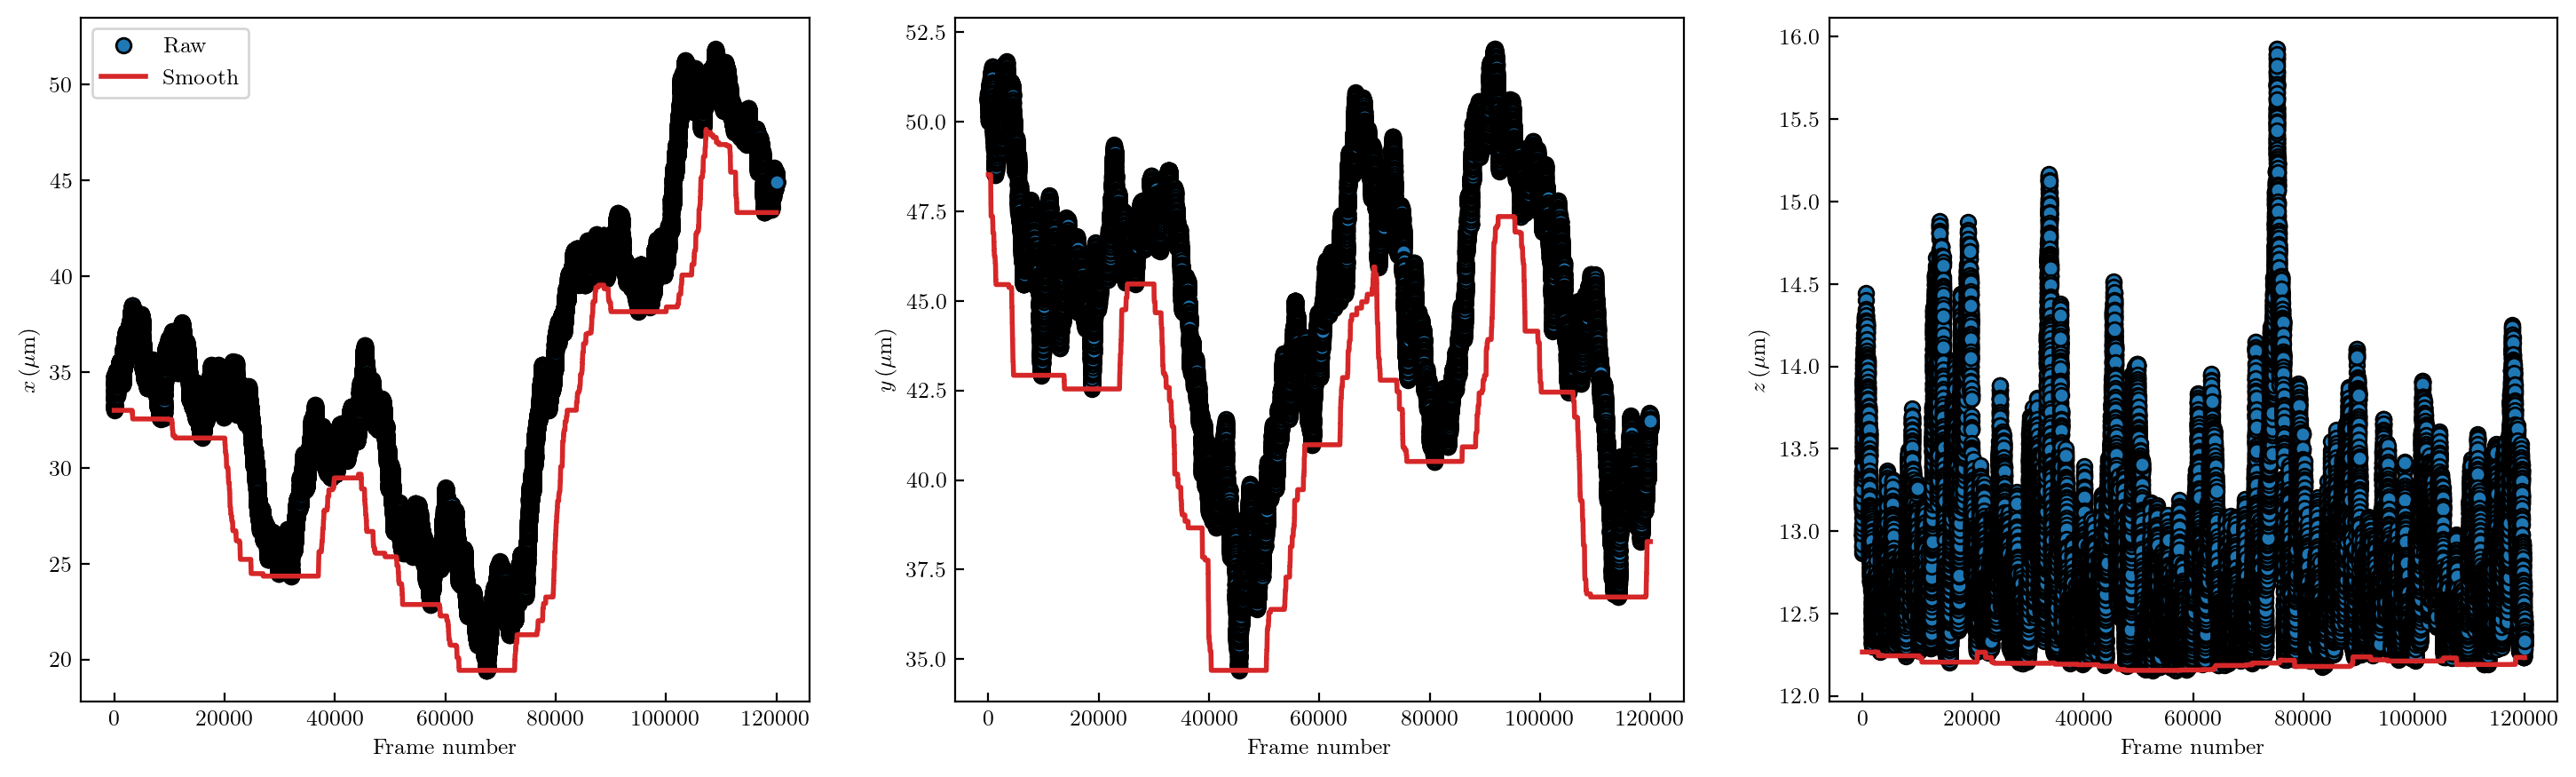

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axx, axy, axz = axes[0], axes[1], axes[2]

axx.plot(frames, (raw_data[:, 0] - 0*np.min(raw_data[:, 0])) * 1e6, ls='', marker='o', markersize=6, c='tab:blue', label="Raw")
axx.plot(frames, smooth_x * 1e6, ls='-', linewidth=2, c='tab:red', label="Smooth")
axy.plot(frames, (raw_data[:, 1] - 0*np.min(raw_data[:, 1])) * 1e6, ls='', marker='o', markersize=6, c='tab:blue')
axy.plot(frames, smooth_y * 1e6, ls='-', linewidth=2, c='tab:red')
axz.plot(frames, (raw_data[:, 2] - 0*np.min(raw_data[:, 2])) * 1e6, ls='', marker='o', markersize=6, c='tab:blue')
axz.plot(frames, smooth_z * 1e6, ls='-', linewidth=2, c='tab:red')

axx.legend()

axx.set_xlabel("Frame number")
axx.set_ylabel("$x \, \mathrm{(\mu m)}$")
axy.set_xlabel("Frame number")
axy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axz.set_xlabel("Frame number")
axz.set_ylabel("$z \, \mathrm{(\mu m)}$")

plt.show()

In [27]:
# Determine how the bottom surface varies spatially 

# I suppose that the dependencies of z on x and y are only linear. 
# It can be adapted to higher dimensions, if needed. 

from scipy.linalg import lstsq

# Create a grid
# X, Y : x-, y- coordinates of the gride's nodes 
# Direction : from left toright and from top to bottom
X, Y = np.meshgrid(
    np.linspace(np.min(raw_data[:, 0]), np.max(raw_data[:, 0]), 10), 
    np.linspace(np.min(raw_data[:, 1]), np.max(raw_data[:, 1]), 10), 
)
# From 2D arrays to 1D arrays
XX = X.flatten()
YY = Y.flatten()

A = np.c_[smooth_x, smooth_y, np.ones(raw_data.shape[0])]
z_of_xy_coef, _, _, _ = lstsq(A, smooth_z)

z_of_xy = lambda x, y: z_of_xy_coef[0] * x + z_of_xy_coef[1] * y + z_of_xy_coef[2]

# Function = 2D linear fit - delta to account for mistakes in determining the moving min of x, y, z(t).
delta = np.min(z_of_xy(XX,YY)) - np.min(smooth_z)
z_of_xy = lambda x, y: z_of_xy_coef[0] * x + z_of_xy_coef[1] * y + z_of_xy_coef[2] - delta
# In any case, it's a vertical translation.
# So it won't affect the analysis (we remove the moving min of z later). 
# It only affects the following two plots.

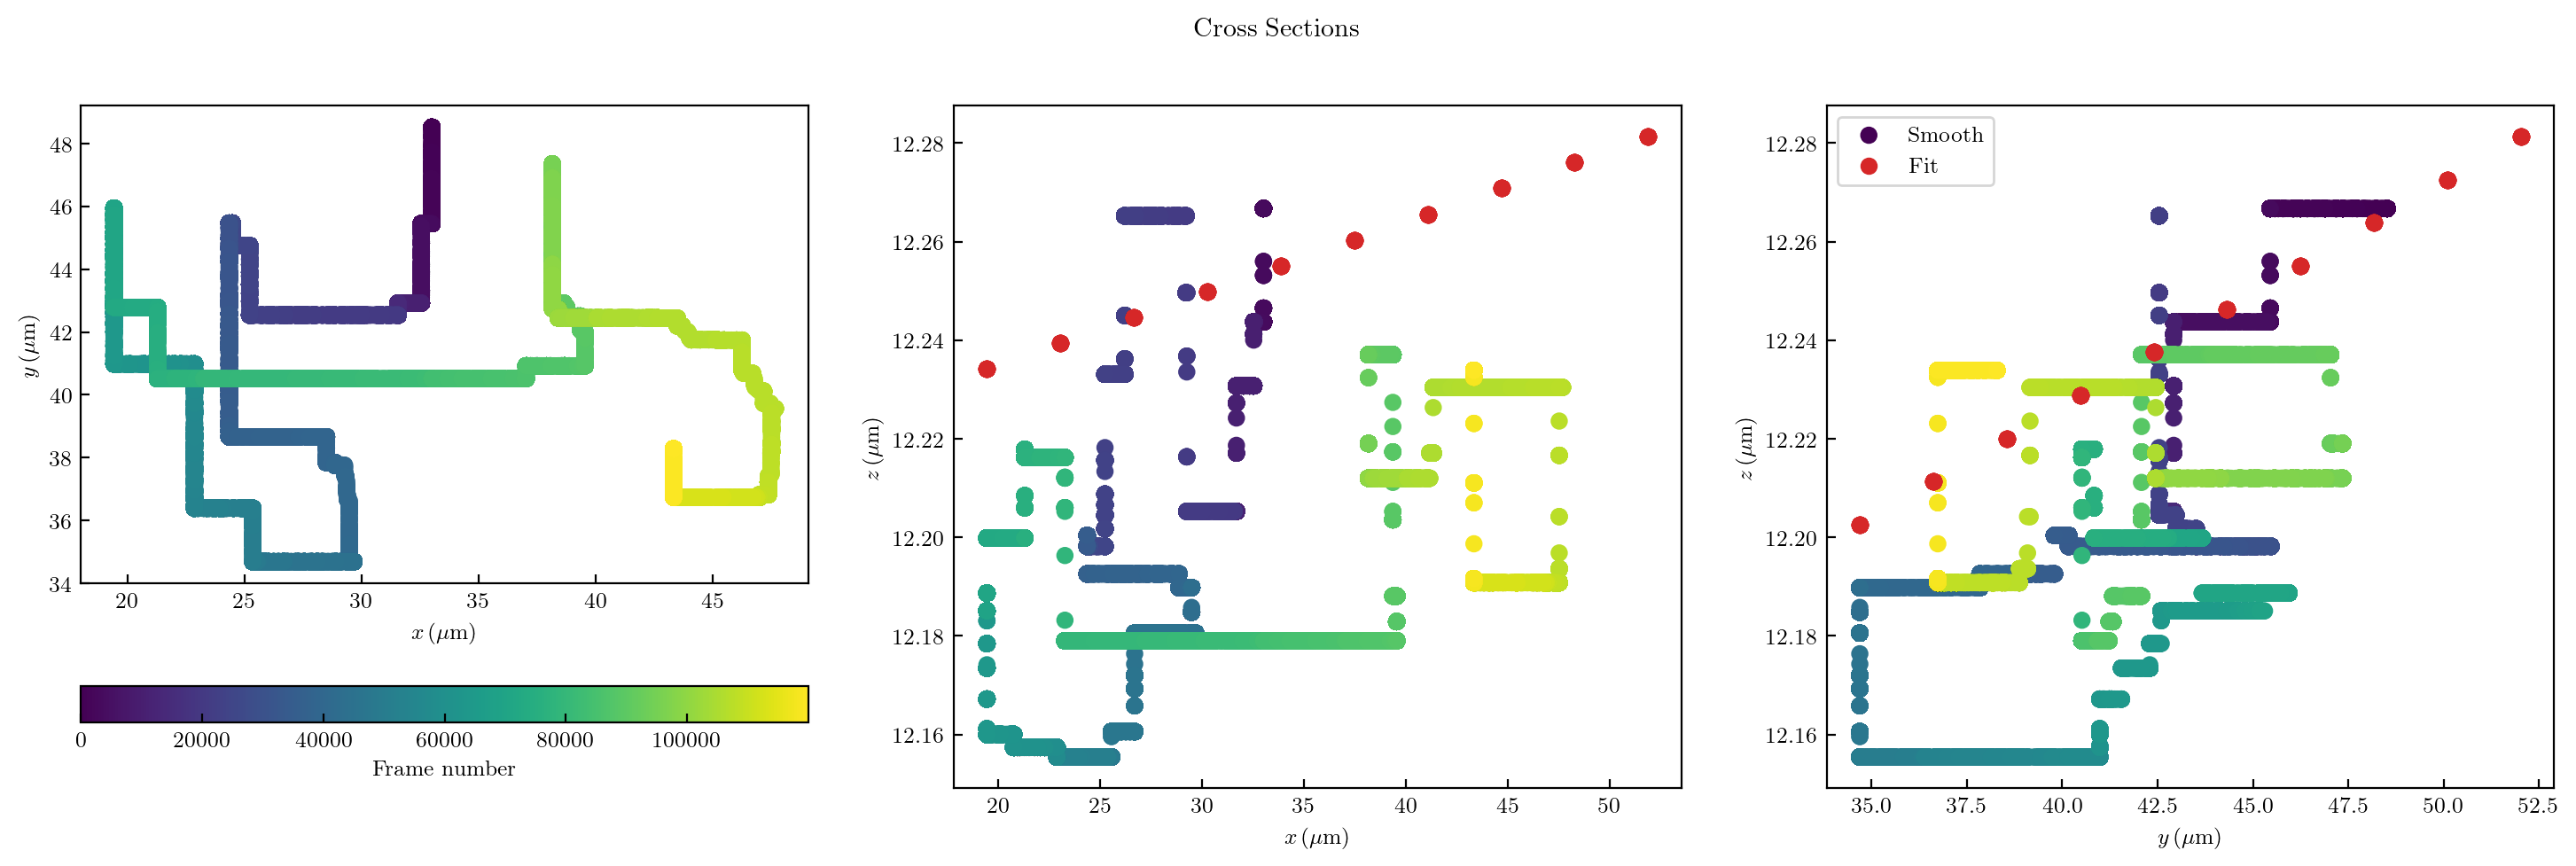

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axxy, axxz, axyz = axes[0], axes[1], axes[2]

axxy.scatter(smooth_x * 1e6, smooth_y * 1e6, c=frames)
axxz.scatter(smooth_x * 1e6, smooth_z * 1e6, c=frames)
axxz.scatter(XX * 1e6, z_of_xy(XX, YY[99]) * 1e6, color="tab:red")
axyz.scatter(smooth_y * 1e6, smooth_z * 1e6, c=frames, label="Smooth")
#axyz.scatter(smooth_y * calib, z_of_y(smooth_y) * calib, color="tab:red", label="Fit")
axyz.scatter(YY * 1e6, z_of_xy(XX[9], YY) * 1e6, color="tab:red", label="Fit")

axyz.legend()

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=frames[-1]), cmap=mpl.cm.viridis), 
             ax=axxy, orientation='horizontal', label="Frame number"
            )

axxy.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axxz.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxz.set_ylabel("$z \, \mathrm{(\mu m)}$")
axyz.set_xlabel("$y \, \mathrm{(\mu m)}$")
axyz.set_ylabel("$z \, \mathrm{(\mu m)}$")

fig.suptitle("Cross Sections")

plt.show()

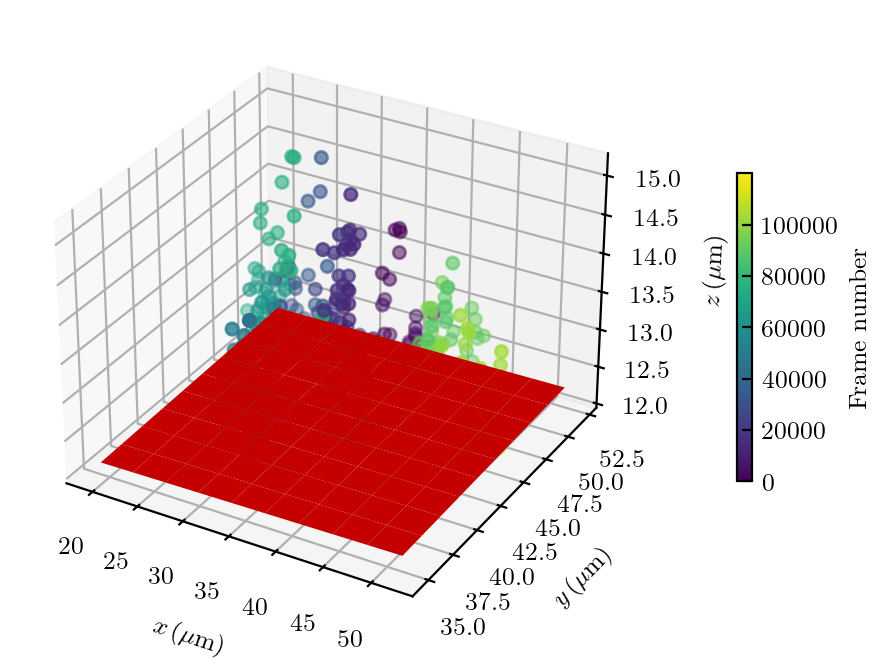

In [29]:
fig = plt.figure(figsize=(13,4))
ax = plt.axes(projection='3d')

ax.scatter3D(raw_data[::200, 0] * 1e6, raw_data[::200, 1] * 1e6, raw_data[::200, 2] * 1e6, c=frames[::200])
ax.plot_surface(X * 1e6, Y * 1e6, z_of_xy(X, Y) * 1e6, color='r')

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=frames[-1]), cmap=mpl.cm.viridis), 
             ax=ax, orientation='vertical', shrink=0.5, 
             label="Frame number"
            )

ax.set_xlabel("$x \, \mathrm{(\mu m)}$")
ax.set_ylabel("$y \, \mathrm{(\mu m)}$")
ax.set_zlabel("$z \, \mathrm{(\mu m)}$")

# fig.suptitle("3D Trajectory")

plt.show()

In [30]:
# tosave["z_of_xy_coef"] = np.copy(z_of_xy_coef)
# tosave["z_of_xy_coef_explained"] = ["this_coef * x", "this_coef * y", "plus_this_coef"]
# tosave["X"] = np.copy(X)
# tosave["Y"] = np.copy(Y)

## Use a Reference (Particle, Water in PDMS, etc.) Stuck In Or On the Bottom Surface

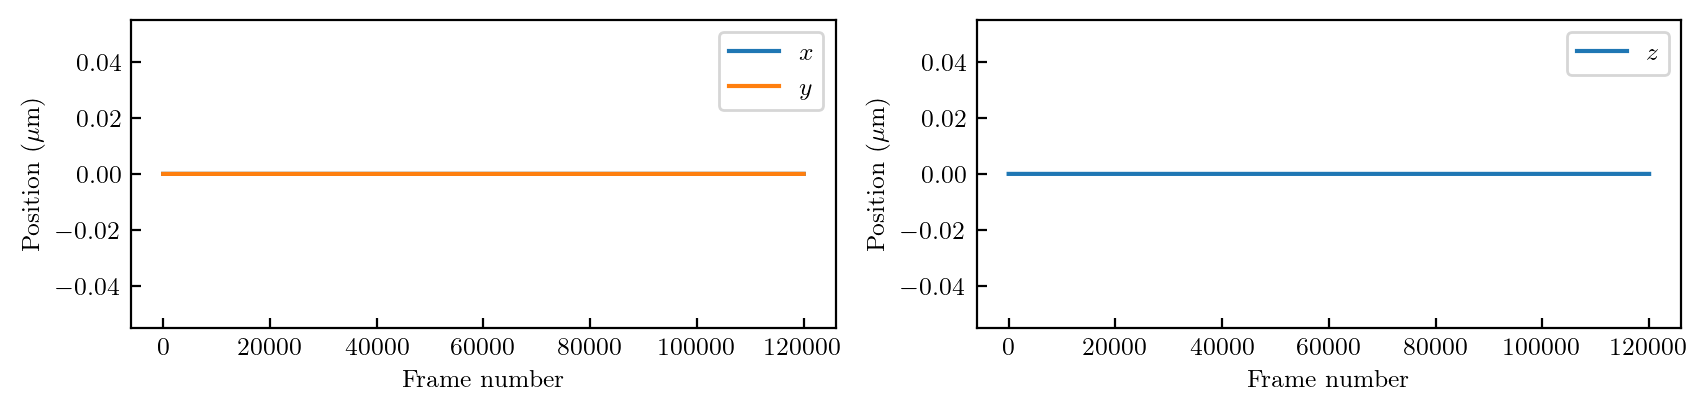

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10,2))
axx, axz = axes[0], axes[1]

axx.plot(time * fps, raw_data_ref[:, 0] * 1e6, label="$x$")
axx.plot(time * fps, raw_data_ref[:, 1] * 1e6, label="$y$")
axz.plot(time * fps, raw_data_ref[:, 2] * 1e6, label="$z$")

axx.set_xlabel("Frame number")
axx.set_ylabel("Position $\mathrm{(\mu m)}$")
axz.set_xlabel("Frame number")
axz.set_ylabel("Position $\mathrm{(\mu m)}$")

axx.legend()
axz.legend()

plt.show()

In [32]:
nb_points_ref = 10000
smooth_xref = co.movmean(raw_data_ref[:, 0], nb_points_ref)
smooth_yref = co.movmean(raw_data_ref[:, 1], nb_points_ref)
smooth_zref = co.movmean(raw_data_ref[:, 2], nb_points_ref)

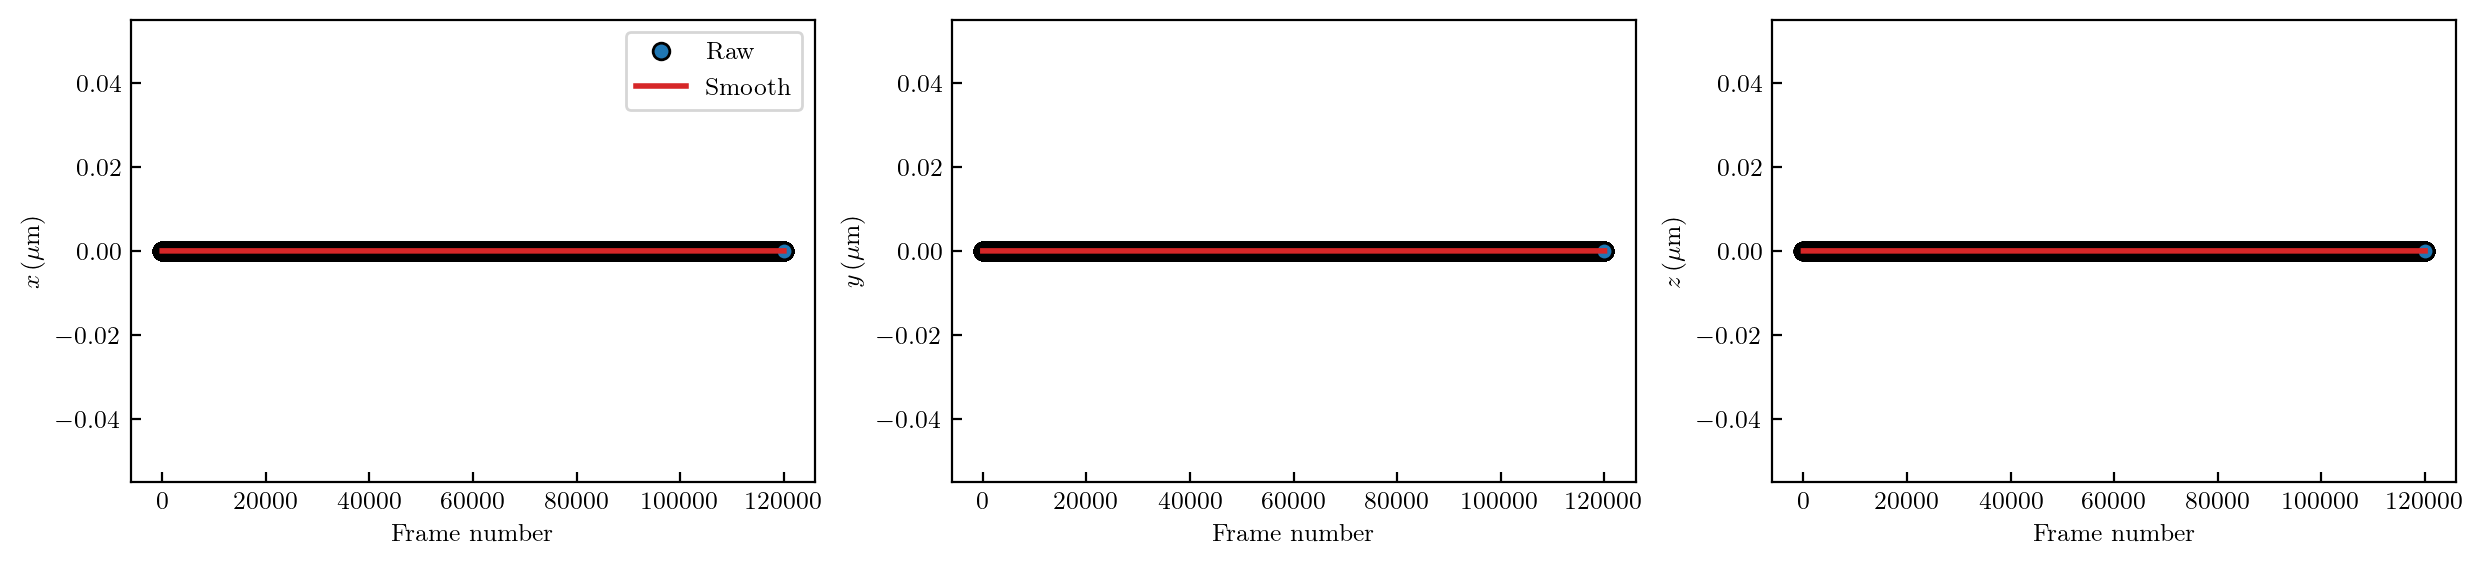

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
axx, axy, axz = axes[0], axes[1], axes[2]

axx.plot(frames, raw_data_ref[:, 0] * 1e6, ls='', marker='o', markersize=6, c='tab:blue', label="Raw")
axx.plot(frames, smooth_xref * 1e6, ls='-', linewidth=2, c='tab:red', label="Smooth")
axy.plot(frames, raw_data_ref[:, 1] * 1e6, ls='', marker='o', markersize=6, c='tab:blue')
axy.plot(frames, smooth_yref * 1e6, ls='-', linewidth=2, c='tab:red')
axz.plot(frames, raw_data_ref[:, 2] * 1e6, ls='', marker='o', markersize=6, c='tab:blue')
axz.plot(frames, smooth_zref * 1e6, ls='-', linewidth=2, c='tab:red')

axx.legend()

axx.set_xlabel("Frame number")
axx.set_ylabel("$x \, \mathrm{(\mu m)}$")
axy.set_xlabel("Frame number")
axy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axz.set_xlabel("Frame number")
axz.set_ylabel("$z \, \mathrm{(\mu m)}$")

plt.show()

In [34]:
if raw_data_ref.any() != 0.:
    tosave["raw_data_ref"] = np.copy(raw_data_ref)
    tosave["nb_points_ref"] = nb_points_ref
    tosave["smooth_xref"] = np.copy(smooth_xref)
    tosave["smooth_yref"] = np.copy(smooth_yref)
    tosave["smooth_zref"] = np.copy(smooth_zref)

## Add the Corrections to the Sphere's Trajectory

In [35]:
# Use SI

xraw = raw_data[:, 0]
yraw = raw_data[:, 1]
zraw = raw_data[:, 2]

x = xraw - smooth_xref # If no reference, it just retrieves 0.
x = x - np.mean(x)
y = yraw - smooth_yref
y = y - np.mean(y)
z = zraw - smooth_zref
# z = zraw - (smooth_zref + z_of_xy(raw_data[:, 0], raw_data[:, 1]))
z = z - np.min(z)

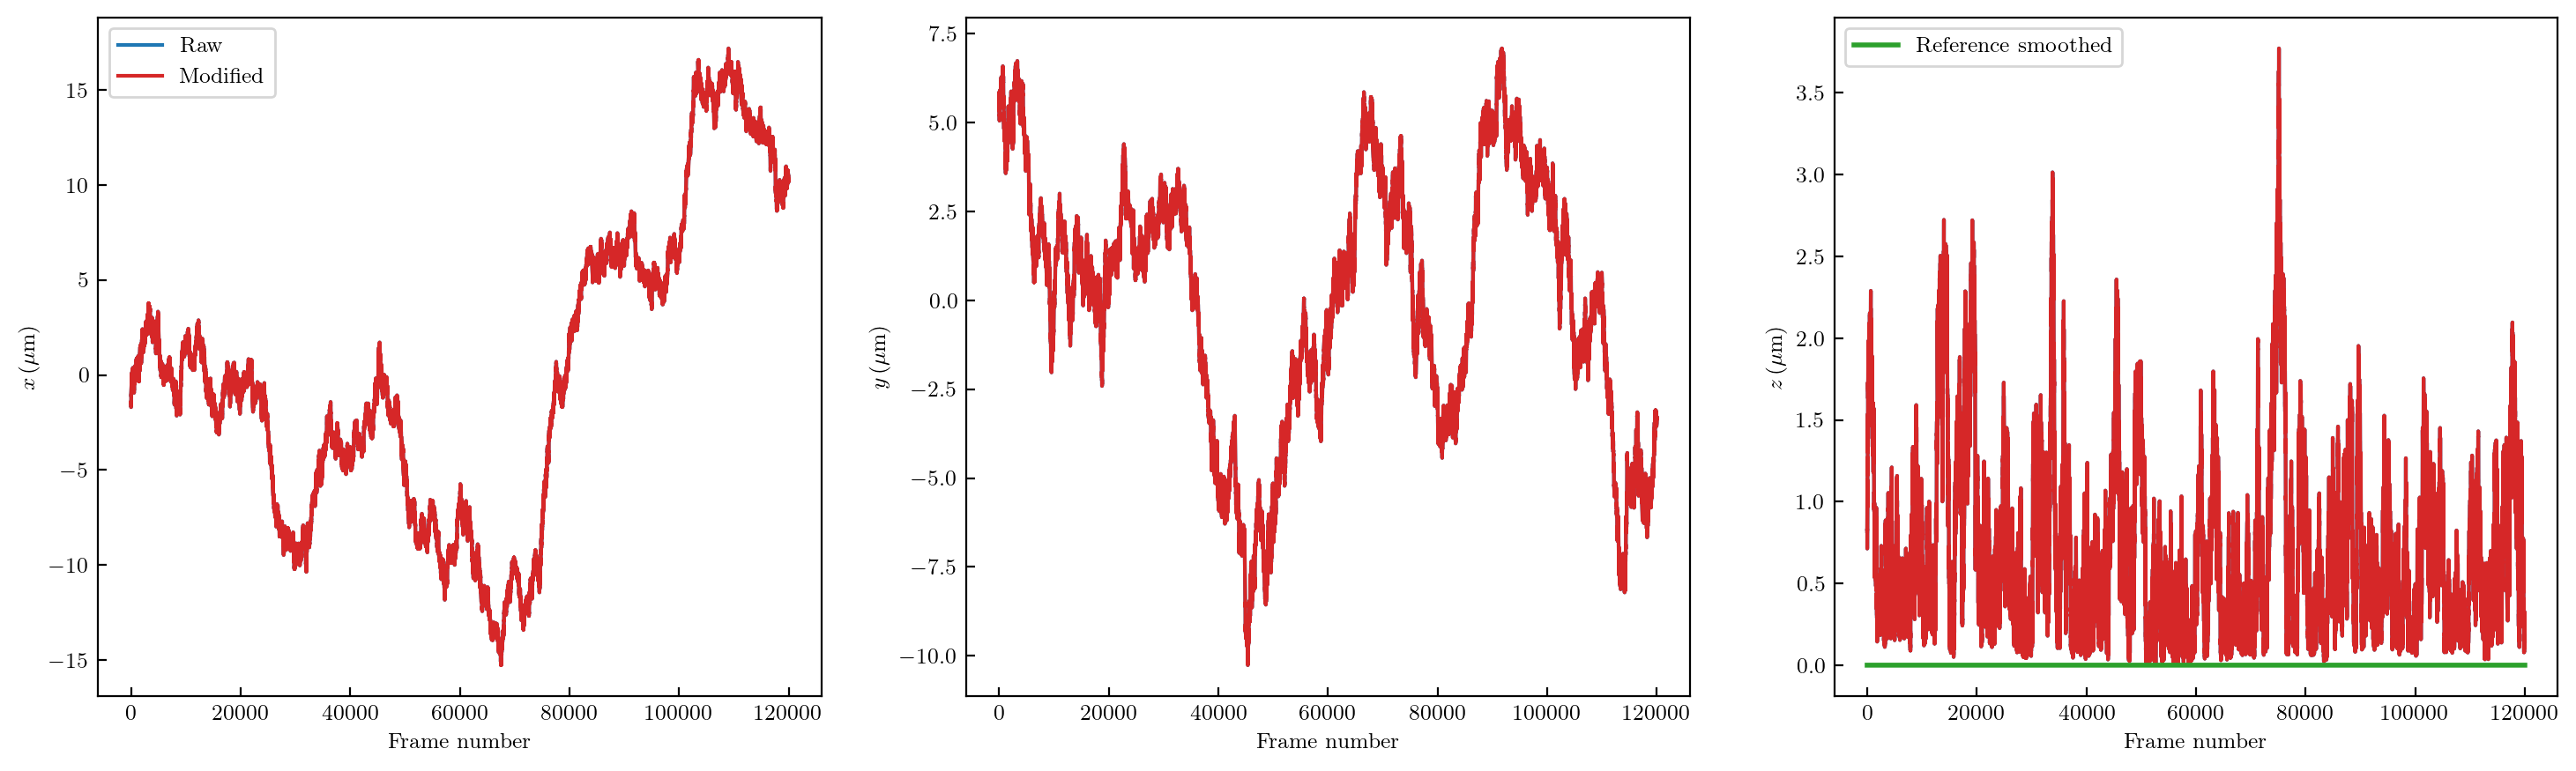

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axx, axy, axz = axes[0], axes[1], axes[2]

axx.plot(frames, xraw * 1e6 - np.mean(xraw) * 1e6, ls='-', marker='', markersize=6, c='tab:blue', label="Raw")
axx.plot(frames, x * 1e6, ls='-', marker='', markersize=6, c='tab:red', label="Modified")
# axx.plot(frames, smooth_xref * 1e6, ls='-', linewidth=2, c='tab:green', label="Reference smoothed")
axy.plot(frames, yraw * 1e6 - np.mean(yraw) * 1e6, ls='-', marker='', markersize=6, c='tab:blue')
axy.plot(frames, y * 1e6, ls='-', marker='', markersize=6, c='tab:red')
# axy.plot(frames, smooth_yref* 1e6, ls='-', linewidth=2, c='tab:green')
axz.plot(frames, zraw * 1e6 - np.min(zraw) * 1e6, ls='-', marker='', markersize=6, c='tab:blue')
axz.plot(frames, z * 1e6, ls='-', marker='', markersize=6, c='tab:red')
axz.plot(frames, smooth_zref * 1e6 - np.min(raw_data_ref[:,2]) * 1e6, ls='-', linewidth=2, c='tab:green', label="Reference smoothed")

axx.legend()
axz.legend()

axx.set_xlabel("Frame number")
axx.set_ylabel("$x \, \mathrm{(\mu m)}$")
axy.set_xlabel("Frame number")
axy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axz.set_xlabel("Frame number")
axz.set_ylabel("$z \, \mathrm{(\mu m)}$")

plt.show()

In [37]:
# Save data

tosave["xraw"] = np.copy(xraw)
tosave["yraw"] = np.copy(yraw)
tosave["zraw"] = np.copy(zraw)
tosave["x"] = np.copy(x)
tosave["y"] = np.copy(y)
tosave["z"] = np.copy(z)

## Dedrift the $z$-trajectory

In [38]:
def dedrift(z, n, method='movmin'):
    
    if method == 'movmin':
        return z - co.movmin(z, n)
    else: 
        print('Not coded yet! Just return the input')

Now we use the MSD ($z$) to choose the number of points to use in the dedrifting procedure. 
The choice is 10 times the times required to reach the permanent regime. 

Be careful: the time cannot be too small (loose too much information) and too large (regime of the drift so you don't remove anything).

/tmp/ipykernel_173550/3608097041.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_short, _ = curve_fit(


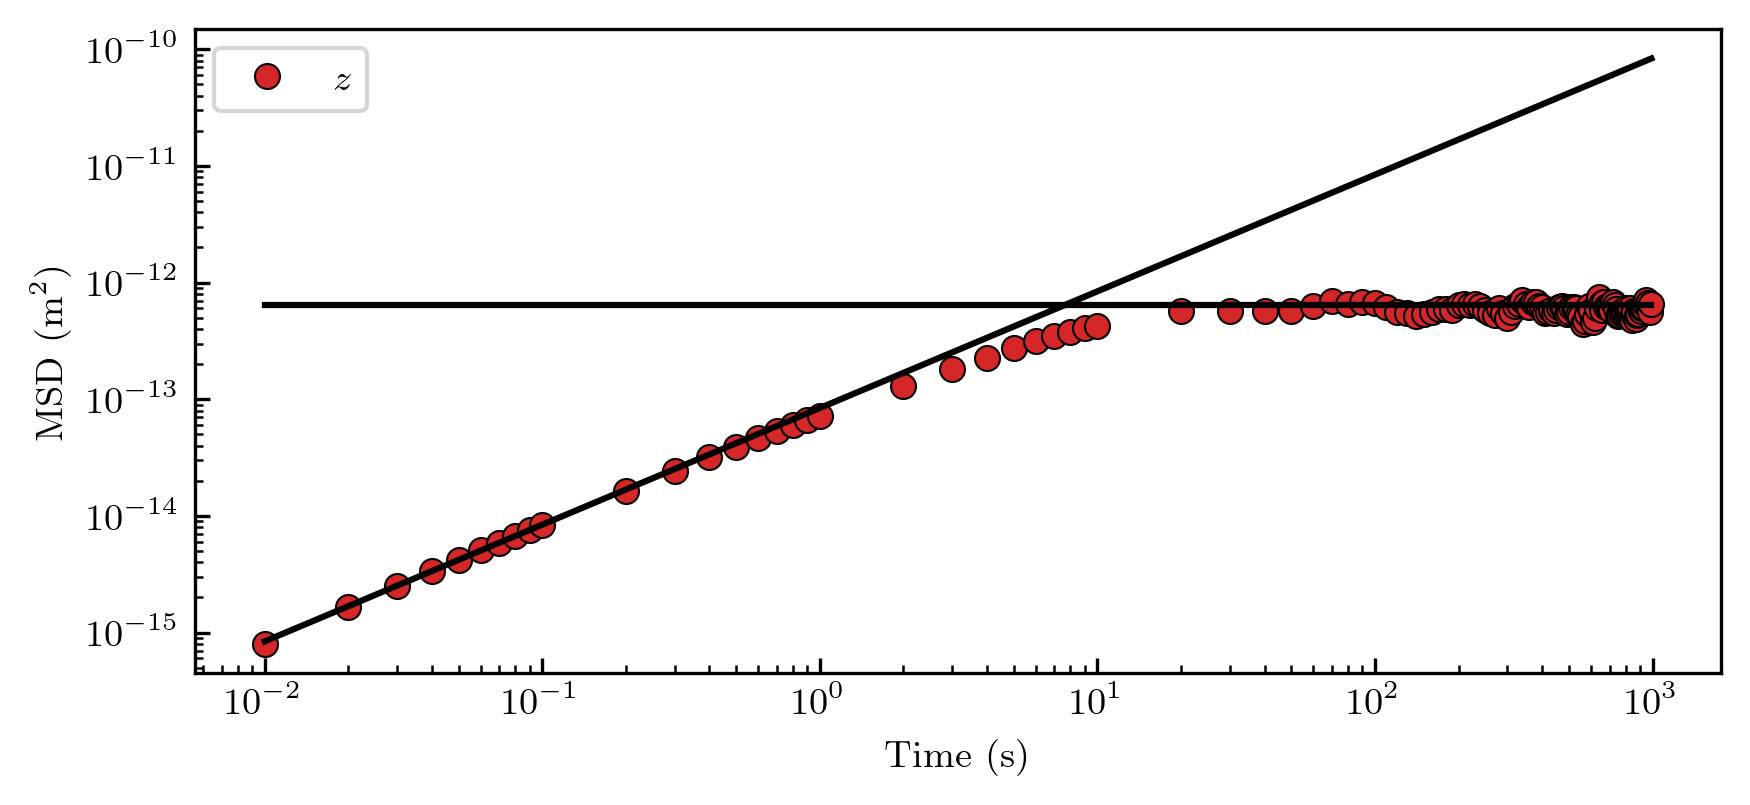

Measured equilibrium time = 7.706026211900131 s
So dedrift time = 25 times the previous time = 192.65065529750328 s = 19265.06552975033 points


In [39]:
step = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 100000, 1000),
    )
)
tttt = step / fps

msdz = co.moment(2, z, step, retrieve_mean = False)

# =======
# Compute 
# =======

# Input times in s
start_short = 0 
stop_short = 0.1
start_long = 50
stop_long = 100

f_short = lambda x, a, b: a*x + (2*b)**2
popt_short, _ = curve_fit(
    f_short, 
    tttt[(tttt >= start_short) & (tttt <= stop_short)], msdz[(tttt >= start_short) & (tttt <= stop_short)], 
    p0=[2 * 0.2 * 4e-21 / (6*np.pi*eta_m*r), 0.], 
)
coef = popt_short[0]
plateau = np.nanmean(msdz[(tttt >= start_long) & (tttt <= stop_long)])

tau_eq = plateau / coef

# ====
# Plot
# ====

fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 7 / 2.54), dpi=300)

ax.plot(
    tttt, msdz, 
    'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, 
    label="$z$", 
)
ax.plot(tttt, f_short(tttt, *popt_short), '-k')
ax.plot(tttt, np.ones(len(tttt)) * plateau, '-k')

ax.legend()

ax.set(
    xscale='log', 
    yscale='log', 
    xlabel="Time (s)", 
    ylabel="MSD $\mathrm{(m^2)}$", 
)

plt.tight_layout()
plt.show()


# =====
# Print
# =====
print("Measured equilibrium time = {} s".format(tau_eq))
to_be_chosen = tau_eq*25
print("So dedrift time = 25 times the previous time = {0} s = {1} points".format(to_be_chosen, to_be_chosen*fps))

In [40]:
# fig.savefig()

In [41]:
print("Measured equilibrium time = {} s".format(tau_eq))
print("So dedrift time = 25 times the previous time = {0} s = {1} points".format(to_be_chosen, to_be_chosen*fps))

Measured equilibrium time = 7.706026211900131 s
So dedrift time = 25 times the previous time = 192.65065529750328 s = 19265.06552975033 points


In [42]:
# Choose the dedrift nb of points and dedrift the trajectory

#####

###

#

# nb_points_to_dedrift = 10000
nb_points_to_dedrift = int(to_be_chosen*fps)

#

###

#####

z_dedrift = z - co.movmin(z, nb_points_to_dedrift)
# z_dedrift = z - movmean(z, nb_points_to_dedrift)
# z_dedrift = z_dedrift - np.min(z_dedrift)
print("Time for dedrift = {} s".format(nb_points_to_dedrift / fps))

Time for dedrift = 192.65 s


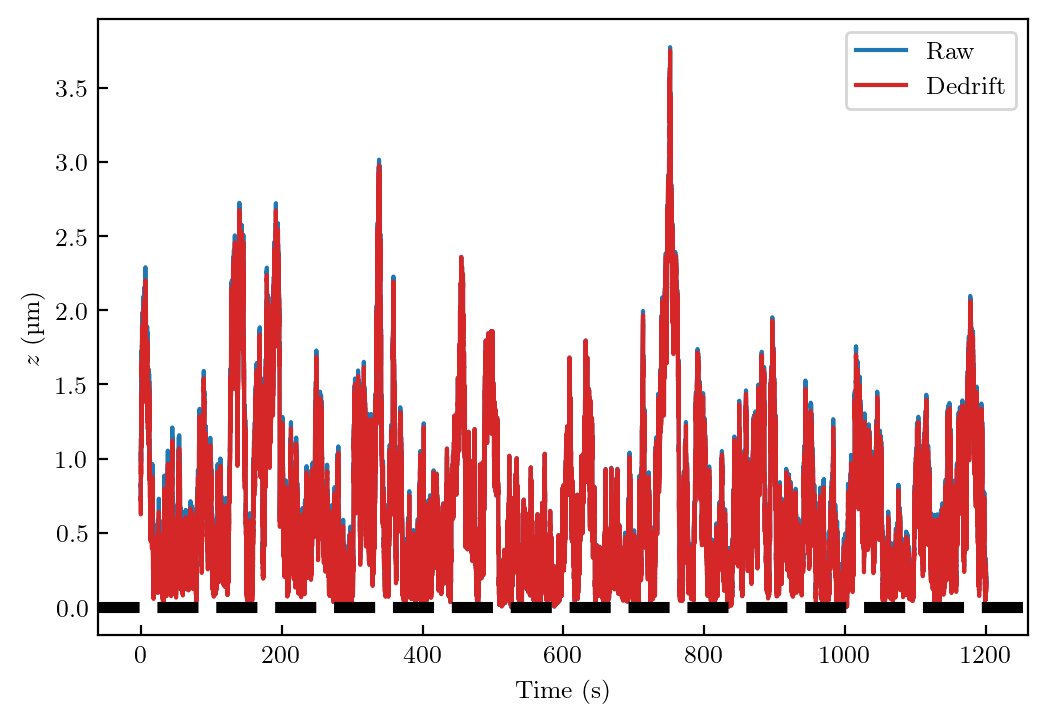

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, (z - np.min(z)) * 1e6, '-', c='tab:blue', label="Raw")
ax.plot(time, z_dedrift * 1e6, '-', c='tab:red', label="Dedrift")
ax.axhline(y=0, ls='--', color='k', linewidth=4)

ax.set_xlabel("Time (s)")
ax.set_ylabel("$z$ (µm)")

ax.legend()

plt.show()

In [44]:
# Save data

tosave["nb_points_to_dedrift"] = nb_points_to_dedrift
tosave["z_dedrift"] = np.copy(z_dedrift)

In [45]:
# filename

In [46]:
# savetraj = {
#     'x': xraw, 
#     'y': yraw,
#     'z': zraw, 
#     'fps': fps, 
# }

# savemat('traj_PRR_SI_rp_1p516_np_1p597_fps_60_calib_0p0513.mat', savetraj, appendmat=False)

# fig, ax = plt.subplots(1, 1, figsize=(7/2.54,5/2.54))

# ax.plot(time, (z - np.min(z)) * 1e6, '-', c='tab:red', linewidth=1)
# ax.axhline(y=0, ls='--', color='k', linewidth=1)

# ax.set_xlabel("$t$ (s)")
# ax.set_ylabel("$z$ (µm)")

# plt.tight_layout()
# plt.show()

# fig.savefig('fig_pres_z_raw_traj_2_20231114.pdf')

In [47]:
# savetraj['z']

# __Analysis of the Trajectory__ 

First, obversables are computed and basic properties are estimated (mean diffusion coefficient, noise levels, etc.). Some of the observables are also fitted independently to check that every observable are correct. 

Second, the multifitting procedure is performed.

# MSD

In [48]:
def correlations(x, t):
    res = np.zeros(len(t))
    std = np.zeros(len(t))
    for i, j in enumerate(t):
        #x_tau = x[j:] - np.mean(x[j:])
        #x_zer = x[0:-j] - np.mean(x[0:-j])
        #res[i] = np.nanmean((x_tau - x_zer)**n)
        dx = x[j:] - x[:-j]
        distribution = dx[j:] * dx[:-j]
        res[i] = np.nanmean(distribution)
    return res

In [49]:
delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 50000, 1000),
    )
)

delta_time_MSD = time[delta_frame_nb]

MSD_x, std_MSD_x = co.moment(2, x, delta_frame_nb, return_std = True, retrieve_mean = True) # Function in wrapper
MSD_y, std_MSD_y = co.moment(2, y, delta_frame_nb, return_std = True, retrieve_mean = True)
MSD_z, std_MSD_z = co.moment(2, z_dedrift, delta_frame_nb, return_std = True, retrieve_mean = True)

sta, sto = 0, 20
MSD_x_bis, MSD_y_bis, MSD_z_bis = np.copy(MSD_x), np.copy(MSD_y), np.copy(MSD_z)
MSD_x_bis[sta:sto] = MSD_x[sta:sto] + 2 * correlations(x, delta_frame_nb)[sta:sto]
MSD_y_bis[sta:sto] = MSD_y[sta:sto] + 2 * correlations(y, delta_frame_nb)[sta:sto]
MSD_z_bis[sta:sto] = MSD_z[sta:sto] + 2 * correlations(z, delta_frame_nb)[sta:sto]


# MSD_x, MSD_y, MSD_z = np.copy(MSD_x_bis), np.copy(MSD_y_bis), np.copy(MSD_z_bis)


MSD_para = (MSD_x + MSD_y) / 2
std_MSD_para = (std_MSD_x + std_MSD_y) / 2
MSD_perp = np.copy(MSD_z)
std_MSD_perp = np.copy(std_MSD_z)

In [50]:
D0 = 4e-21 / (6 * np.pi * eta_m * r)
print("D0 = {0:.3e} m^2".format(D0))

D0 = 1.547e-13 m^2


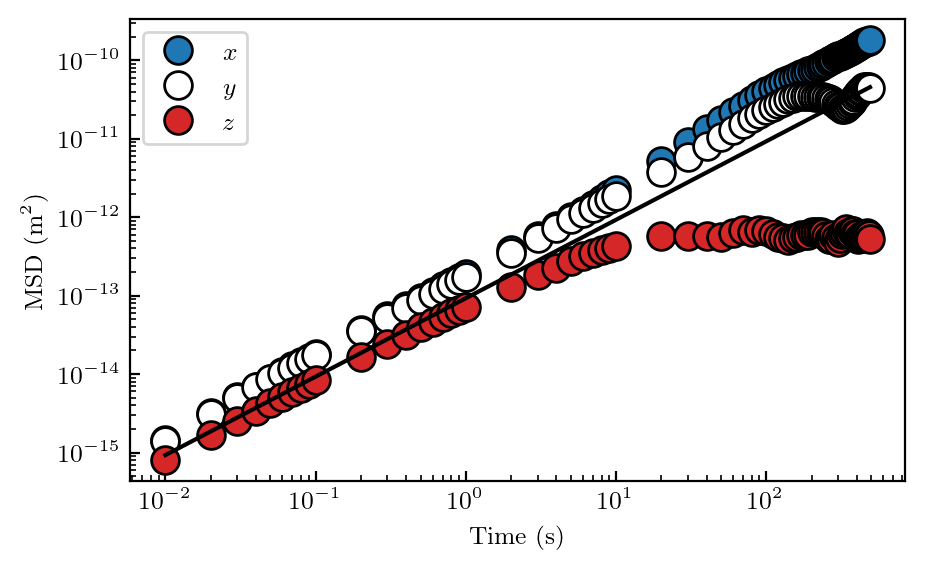

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

ax.plot(delta_time_MSD, MSD_x, 'o', markerfacecolor='tab:blue', markersize=10, markeredgecolor='k', markeredgewidth=1, label="$x$")
ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=10, markeredgecolor='k', markeredgewidth=1, label="$y$")
ax.plot(delta_time_MSD, MSD_z, 'o', markerfacecolor='tab:red', markersize=10, markeredgecolor='k', markeredgewidth=1, label="$z$")

ax.plot(delta_time_MSD, 2*0.3*D0*delta_time_MSD, ls='-', c='k')

# ax.plot(delta_time_MSD[delta_time_MSD > 1], plateau_x * np.ones(len(delta_time_MSD[delta_time_MSD > 1])), '--', c='k')
# ax.plot(delta_time_MSD[delta_time_MSD > 1], plateau_z * np.ones(len(delta_time_MSD[delta_time_MSD > 1])), '--', c='k')

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([0.001,0.05])
# ax.set_ylim([0,1e-14])

ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

In [52]:
# Fit the MSD 
# Short and long times

start_MSD_x = 0
stop_MSD_x = 10
start_MSD_z = 0
stop_MSD_z = 10
start_long_times = 150 # s
stop_long_times = 200

# Long times

# plateau_MSD_para = (np.nanmean(MSD_x[delta_time_MSD > start_long_times]) + np.nanmean(MSD_y[delta_time_MSD > start_long_times])) / 2
plateau_MSD_perp = np.nanmean(MSD_z[(delta_time_MSD > start_long_times) & (delta_time_MSD < stop_long_times)])

# Short times

def MSD_th(t, reduced_D, noiselevel, tau_e=0):
    return 2 * reduced_D * (1 - tau_e/3/t) * D0 * t + (2 * noiselevel) ** 2

popt_MSD_x, _ = curve_fit(
    MSD_th, 
    delta_time_MSD[start_MSD_x:stop_MSD_x], 
    MSD_x[start_MSD_x:stop_MSD_x], 
    p0 = [0.50, 0.], 
)
popt_MSD_y, _ = curve_fit(
    MSD_th, 
    delta_time_MSD[start_MSD_x:stop_MSD_x], 
    MSD_y[start_MSD_x:stop_MSD_x], 
    p0 = [0.50, 0.], 
)
popt_MSD_z, _ = curve_fit(
    MSD_th, 
    delta_time_MSD[start_MSD_z:stop_MSD_z], 
    MSD_z[start_MSD_z:stop_MSD_z], 
    p0 = [0.25, 0.], 
)

mean_D_para_from_MSD = (popt_MSD_x[0] + popt_MSD_y[0]) / 2
mean_D_perp_from_MSD = popt_MSD_z[0]
noise_level_para_from_MSD = (popt_MSD_x[1] + popt_MSD_y[1]) / 2
noise_level_perp_from_MSD = popt_MSD_z[1]

# if np.isnan(noise_level_para_from_MSD) or noise_level_para_from_MSD < 1e-9:
#     noise_level_para_from_MSD = 0.
# else:
#     pass
    
# if np.isnan(noise_level_perp_from_MSD) or noise_level_perp_from_MSD < 1e-9:
#     noise_level_perp_from_MSD = 0.
# else: 
#     pass

noiselevel_D_para_from_MSD = 1/2 * (2 * noise_level_para_from_MSD) ** 2 / (2 * 5/6 * 1/fps) / D0
noiselevel_D_perp_from_MSD = 1/2 * (2 * noise_level_perp_from_MSD) ** 2 / (2 * 5/6 * 1/fps) / D0

/tmp/ipykernel_173550/3701253853.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_MSD_x, _ = curve_fit(
/tmp/ipykernel_173550/3701253853.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_MSD_y, _ = curve_fit(
/tmp/ipykernel_173550/3701253853.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_MSD_z, _ = curve_fit(


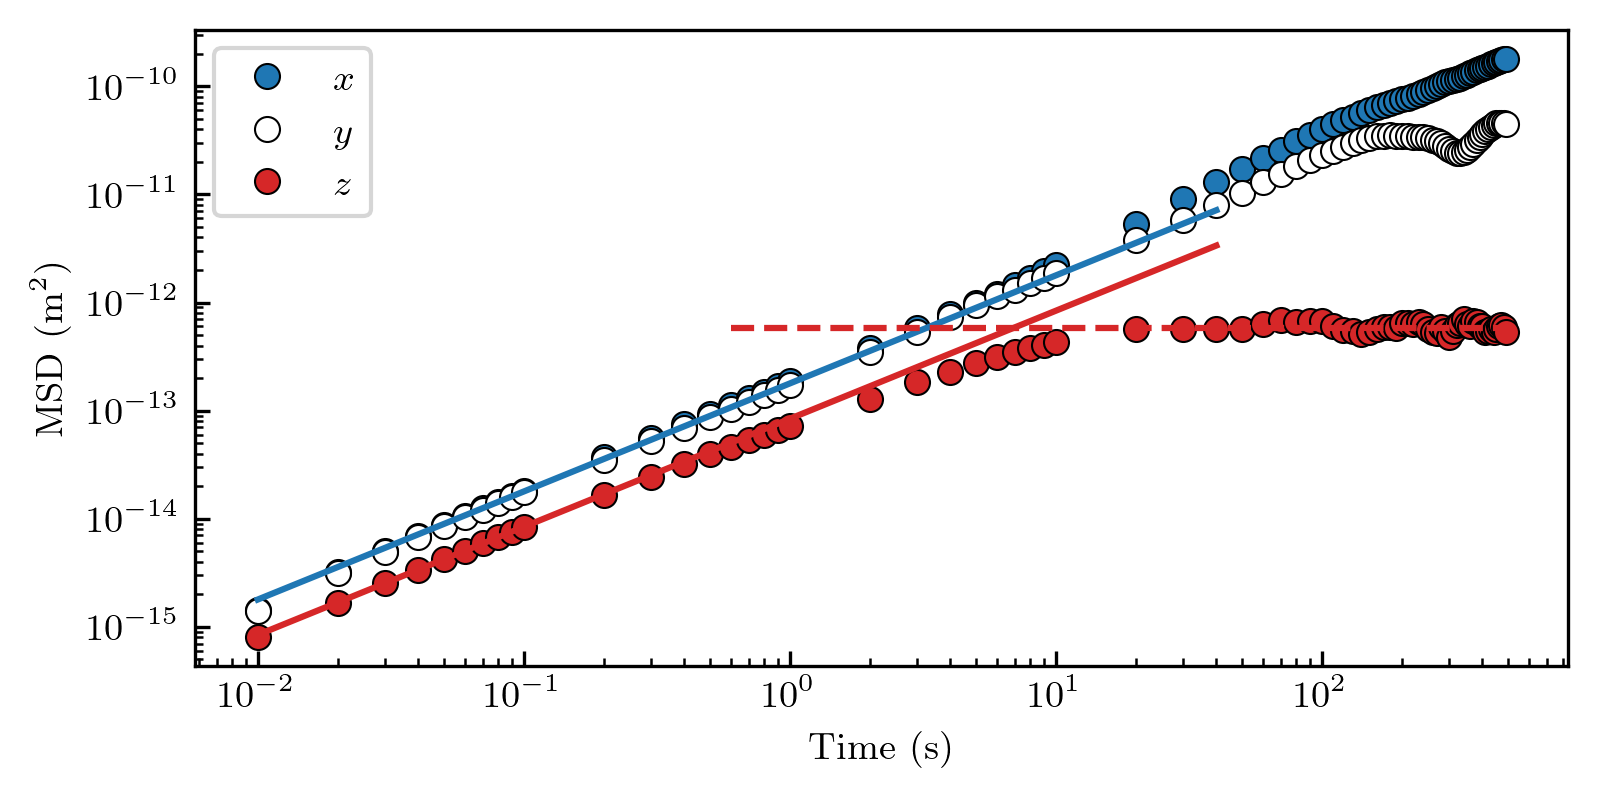

The measured mean diffusion coefficients are:
   0.569D0 in the parallel direction
   0.272D0 in the normal direction
FYI, D0 = 1.547e-13 m^2/s
The measured noise levels are:
   -0.000 nm in the parallel direction
   -0.000 nm in the normal direction


In [53]:
fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 7 / 2.54), dpi=300)

ax.plot(delta_time_MSD, MSD_x, 'o', markerfacecolor='tab:blue', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x$")
ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD, MSD_z, 'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

ax.plot(delta_time_MSD[delta_time_MSD < 50], MSD_th(delta_time_MSD[delta_time_MSD < 50], *popt_MSD_x), ls='-', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[delta_time_MSD < 50], MSD_th(delta_time_MSD[delta_time_MSD < 50], *popt_MSD_z), ls='-', c='tab:red', linewidth=1.5)
# ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_para * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_perp * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:red', linewidth=1.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

print("The measured mean diffusion coefficients are:")
print("   {0:.3f}D0 in the parallel direction".format(mean_D_para_from_MSD))
print("   {0:.3f}D0 in the normal direction".format(mean_D_perp_from_MSD))
print("FYI, D0 = {0:.3e} m^2/s".format(D0))
print("The measured noise levels are:")
print("   {0:.3f} nm in the parallel direction".format(noise_level_para_from_MSD * 1e9))
print("   {0:.3f} nm in the normal direction".format(noise_level_perp_from_MSD * 1e9))

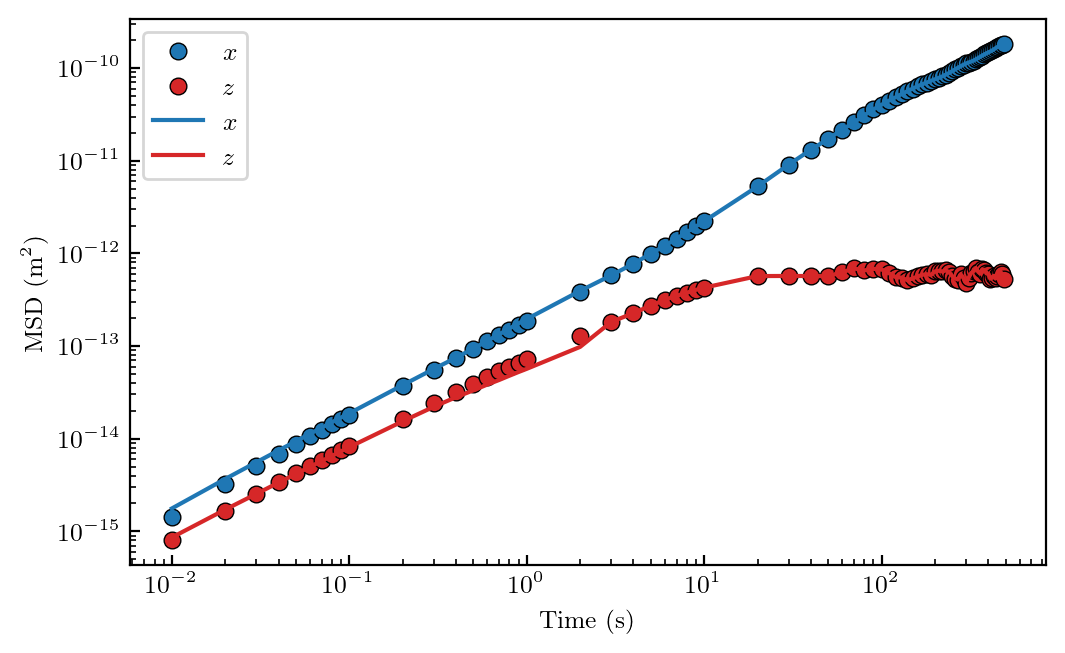

In [54]:
# Compare with and without correlation corrections

fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 9 / 2.54))

ax.plot(delta_time_MSD, MSD_x, 'o', markerfacecolor='tab:blue', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x$")
# ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD, MSD_z, 'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

ax.plot(delta_time_MSD, MSD_x_bis, '-', c='tab:blue', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x$")
# ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD, MSD_z_bis, '-', c='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

In [55]:
noiselevel_D_perp_from_MSD

np.float64(1.672596248365607e-11)

In [56]:
# Correct the MSD, by removing the noise levels

if garde_fou_1:
    # MSD_x += - (2 * noise_level_para_from_MSD * 1e-9) ** 2
    # MSD_y += - (2 * noise_level_para_from_MSD * 1e-9) ** 2
    # MSD_z += - (2 * noise_level_perp_from_MSD * 1e-9) ** 2
    MSD_para -= (2 * noise_level_para_from_MSD) ** 2
    MSD_perp -= (2 * noise_level_perp_from_MSD) ** 2
    # Don't get confused, those noise levels don't change the mean diffusion coefficients.
    # Because the mean diffusion coefficients were fitted by taking into account those noise levels: 
    # Fit with a * t + b and then remove b. So a (= mean diffusion coefficient) does not change.
    garde_fou_1 = False

In [57]:
# Save data

tosave["D0"] = D0

tosave["delta_frame_nb_MSD"] = np.copy(delta_frame_nb)
tosave["delta_time_MSD"] = np.copy(delta_time_MSD)

tosave["MSD_x"] = np.copy(MSD_x) # The noise levels are already removed from the MSD. 
tosave["MSD_y"] = np.copy(MSD_y)
tosave["MSD_z"] = np.copy(MSD_z)
tosave["std_MSD_x"] = np.copy(std_MSD_x)
tosave["std_MSD_y"] = np.copy(std_MSD_y)
tosave["std_MSD_z"] = np.copy(std_MSD_z)

tosave["MSD_para"] = np.copy(MSD_para)
tosave["MSD_perp"] = np.copy(MSD_perp)

tosave["mean_D_para_from_MSD"] = mean_D_para_from_MSD
tosave["noise_level_para_from_MSD"] = noise_level_para_from_MSD
tosave["noiselevel_D_para_from_MSD"] = noiselevel_D_para_from_MSD # Normalized by D0
tosave["mean_D_perp_from_MSD"] = mean_D_perp_from_MSD
tosave["noise_level_perp_from_MSD"] = noise_level_perp_from_MSD
tosave["noiselevel_D_perp_from_MSD"] = noiselevel_D_perp_from_MSD # Normalized by D0

In [58]:
def correlations(x, z, delta_frame_nb):
    dxdz = np.zeros(len(delta_frame_nb))
    for i, j in enumerate(delta_frame_nb):
        dx = x[j:] - x[:-j]
        dz = z[j:] - z[:-j]
        dxdz[i] = np.nanmean(dx * dz)
        dxdz = np.abs(dxdz)
    return dxdz

In [59]:
dxdz = correlations(x, z, delta_frame_nb)

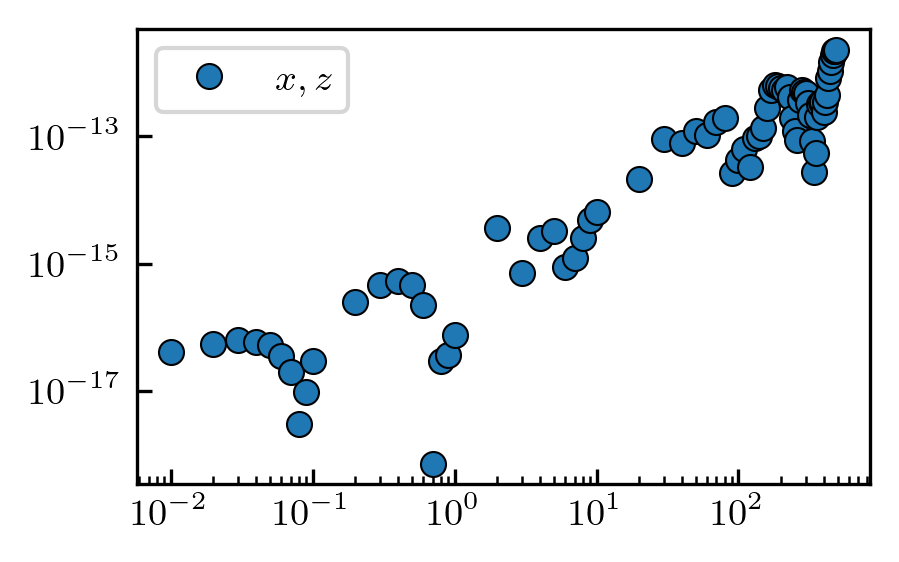

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (8 / 2.54, 5 / 2.54), dpi=300)

ax.plot(delta_time_MSD, dxdz, 'o', markerfacecolor='tab:blue', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x, z$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()

plt.show()

In [61]:
def _displacements_sorted(x, z, bins_z_edges, df=1):
    
    bins_z_centers = (bins_z_edges[1:] + bins_z_edges[:-1]) / 2
    
    dx_z = [[] for j in range(len(bins_z_centers))]
    dz_z = [[] for j in range(len(bins_z_centers))]
    
    dx = x[df:] - x[:-df]
    dz = z[df:] - z[:-df]
    
    zz = z[:-df]
    
    for i in range(len(bins_z_centers)):
        b1, b2 = bins_z_edges[i], bins_z_edges[i+1]
        dx_temp = dx[(b1<=zz) & (zz<b2)]
        dx_z[i] = dx_temp
        dz_temp = dz[(b1<=zz) & (zz<b2)]
        dz_z[i] = dz_temp
            
    return bins_z_centers, dx_z, dz_z

def _local_correlations(dx_z, dz_z):
    dxdz_z = np.zeros(len(dx_z))
    for i, dx_temp in enumerate(dx_z):
        dz_temp = dz_z[i]
        dxdz_z[i] = np.nanmean(dx_temp**1 * dz_temp**1)
    return dxdz_z

In [62]:
bins_z_edges = np.linspace(30e-9, 400e-9, 20)

In [63]:
bins_z_centers, dx_z, dz_z = _displacements_sorted(x, z, bins_z_edges, df=1)

dxdz_z = _local_correlations(dx_z, dz_z)

In [64]:
# fig, ax = plt.subplots(1, 1, figsize = (8 / 2.54, 5 / 2.54), dpi=300)

# ax.plot(bins_z_centers * 1e6, np.abs(dxdz_z), 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5)

# ax.set(
#     xscale='log', 
#     yscale='log', 
#     xlabel=r"$z$ (µm)", 
#     ylabel=r"$\langle \delta_\tau x \, \delta_\tau z \rangle$ (m$^2$)", 
# )

# plt.show()

# PDF

In [65]:
# Computation of Peq and Feq

# The error on the PDF and the equilibrium force is estimated by:
# Adding a nanometric noise to the trajectory, several times.

n_noisy = 100 # Number of iterations of the noise-adding procedure
min_distance = 50e-9 
max_distance = 2e-6
n_bins = 30

In [66]:
data_P_eq, data_F_eq = co.PeqFeq(z_dedrift, n_noisy, min_distance, max_distance, n_bins)
# PeqFeq returns two dictionnaries, containing data corresponding to Peq and Feq

x_pdf_z, width_pdf_z, y_pdf_z, std_y_pdf_z, err_y_pdf_z = data_P_eq.values()
x_F_eq, width_F_eq, y_F_eq, std_y_F_eq, err_y_F_eq = data_F_eq.values()

del data_P_eq, data_F_eq

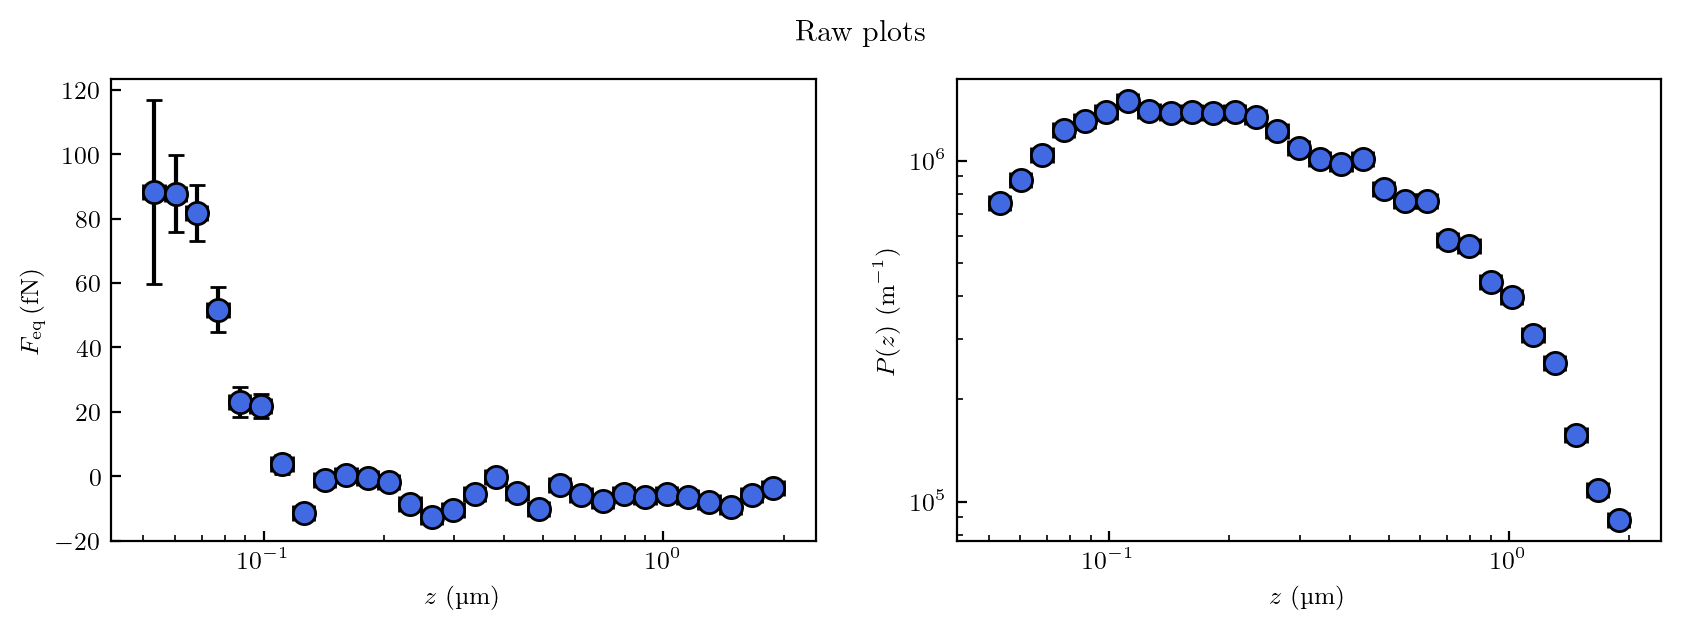

In [67]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,3))

ax1.errorbar(x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq * 1e15, xerr=width_F_eq/2*1e6, 
           ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
            ecolor='k', capsize=3,
           )
ax1.set_xlabel("$z$ (µm)")
ax1.set_ylabel("$F_{\mathrm{eq}} \, \mathrm{(fN)}$")
ax1.set_xscale("log")

ax2.errorbar(x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z / 2, xerr=width_pdf_z/2*1e6, 
           ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
            ecolor='k', capsize=3,
           )
ax2.set_xlabel("$z$ (µm)")
ax2.set_ylabel("$P(z)$ (m$^{-1}$)")
ax2.set_xscale("log")
ax2.set_yscale("log")

fig.suptitle("Raw plots")

plt.show()

In [328]:
# Find the weight directly on the experimental data
F_grav = np.nanmean([y_F_eq[i] for i in range(len(y_F_eq)) if x_F_eq[i] > 0.75e-6 and x_F_eq[i] < 2e-6])
lB_exp = 4e-21 / abs(F_grav)

lB_theory = 4e-21 / (4 / 3 * np.pi * r**3 * drho * 9.81)

print("Experimental weight = {0:.2f} fN".format(F_grav * 1e15))
print("Experimental Boltzmann length = {0:.1f} nm".format(lB_exp * 1e9))
print("Vs.")
print("Theoretical Boltzmann length = {0:.1f} nm".format(lB_theory * 1e9))

Experimental weight = -6.38 fN
Experimental Boltzmann length = 603.0 nm
Vs.
Theoretical Boltzmann length = 606.8 nm


In [329]:
# Theoretical expressions

# For the moment, lB is fixed in the theoretical equilibrium force.

def P_b_semi_theory(z, B, lD, z0=0):
    """
    z: in m
    """
    z = z - z0
    P_b = np.exp(-B * np.exp(-z / lD) - z / lB_exp)
    P_b[z < 0] = 0
    # Normalization of P_b
    P_b = P_b / np.trapezoid(P_b, z)
    return P_b

def F_eq_theory(x, B, lD, z0=0):
    x = x - z0
    res = 4e-21 * (B / lD * np.exp(- x / lD) - 1 / lB_exp)
    return res 

In [330]:
# Fit the PDF

p0_pdf_z = [5, 45e-9, 0]
popt_pdf_z, pcov_pdf_z = curve_fit(P_b_semi_theory, x_pdf_z, y_pdf_z, p0=p0_pdf_z)

offset_B_from_P_eq = popt_pdf_z[0]

/tmp/ipykernel_173550/1607190911.py:10: RuntimeWarning: overflow encountered in exp
  P_b = np.exp(-B * np.exp(-z / lD) - z / lB_exp)


In [335]:
popt_pdf_z = [4.9, 29e-9, 5e-9]

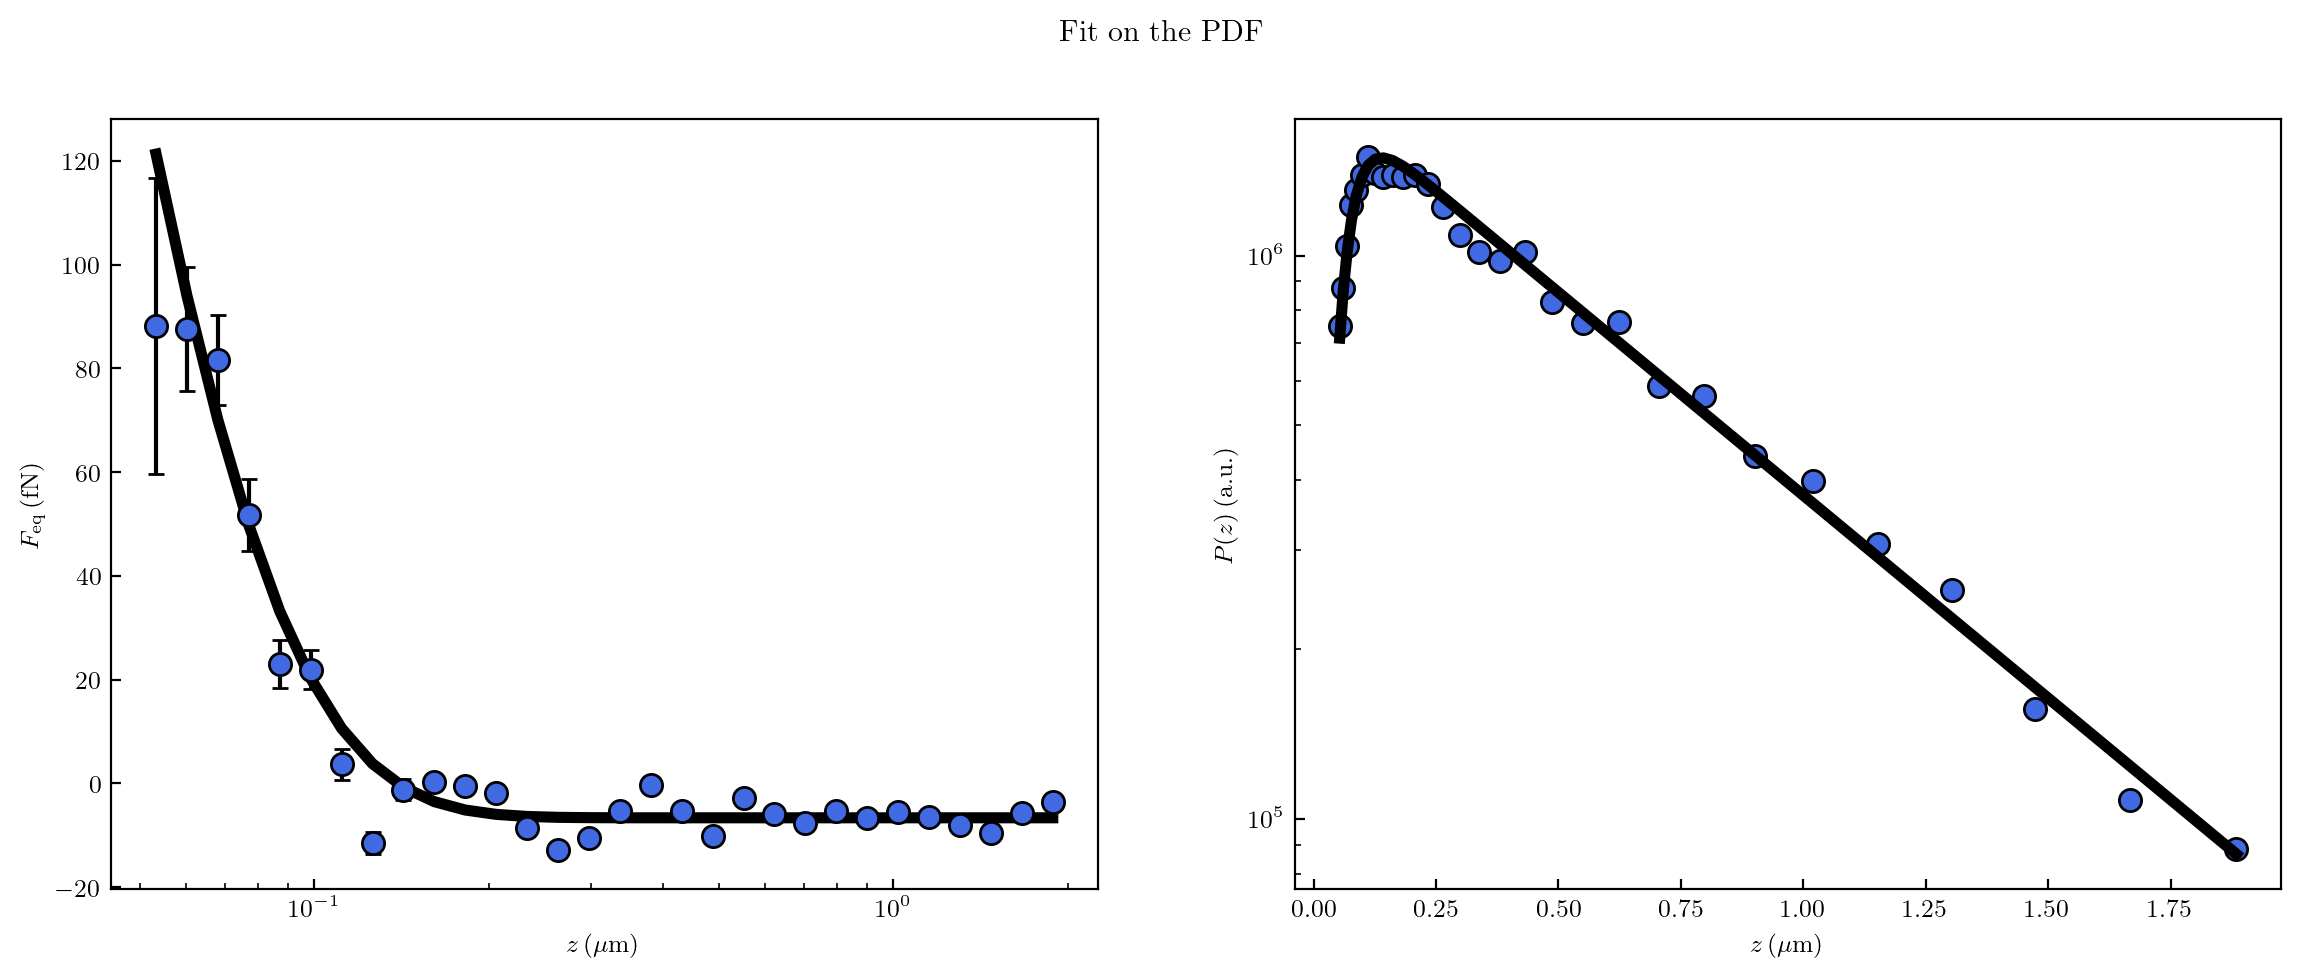

From the pdf: [B, lD, offset_pdf] = 
[4.9, 2.9e-08, 5e-09]


In [336]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,5))

ax1.errorbar(
    x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq * 1e15, 
    ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3,
)
ax1.plot(x_F_eq * 1e6, F_eq_theory(x_F_eq, *popt_pdf_z[:]) * 1e15, ls='-', c='k', linewidth=4)
# ax1.plot(x_F_eq * 1e6, F_eq_theory(x_F_eq, 0, 5, 22e-9) * 1e15, ls='-', c='k', linewidth=4)
ax1.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax1.set_ylabel("$F_{\mathrm{eq}} \, \mathrm{(fN)}$")
ax1.set_xscale("log")

ax2.errorbar(
    x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, 
    ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3,
    zorder=-1,
)
ax2.plot(x_pdf_z * 1e6, P_b_semi_theory(x_pdf_z, *popt_pdf_z[:]), ls='-', c='k', linewidth=4)
ax2.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax2.set_ylabel("$P(z) \, \mathrm{(a.u.)}$")
ax2.set_yscale("log")

fig.suptitle("Fit on the PDF")

plt.show()

print("From the pdf: [B, lD, offset_pdf] = ")
print(popt_pdf_z)

In [337]:
# Fit the force 

p0_F_eq = popt_pdf_z[:] #[4.8, 50e-9]
popt_F_eq, pcov_F_eq = curve_fit(F_eq_theory, x_F_eq, y_F_eq, p0=p0_F_eq)

# popt_F_eq = [5.2, 2.6e-08, 5e-09] #[5.3, 130e-9, 0] #

offset_B_from_F_eq = popt_F_eq[0]

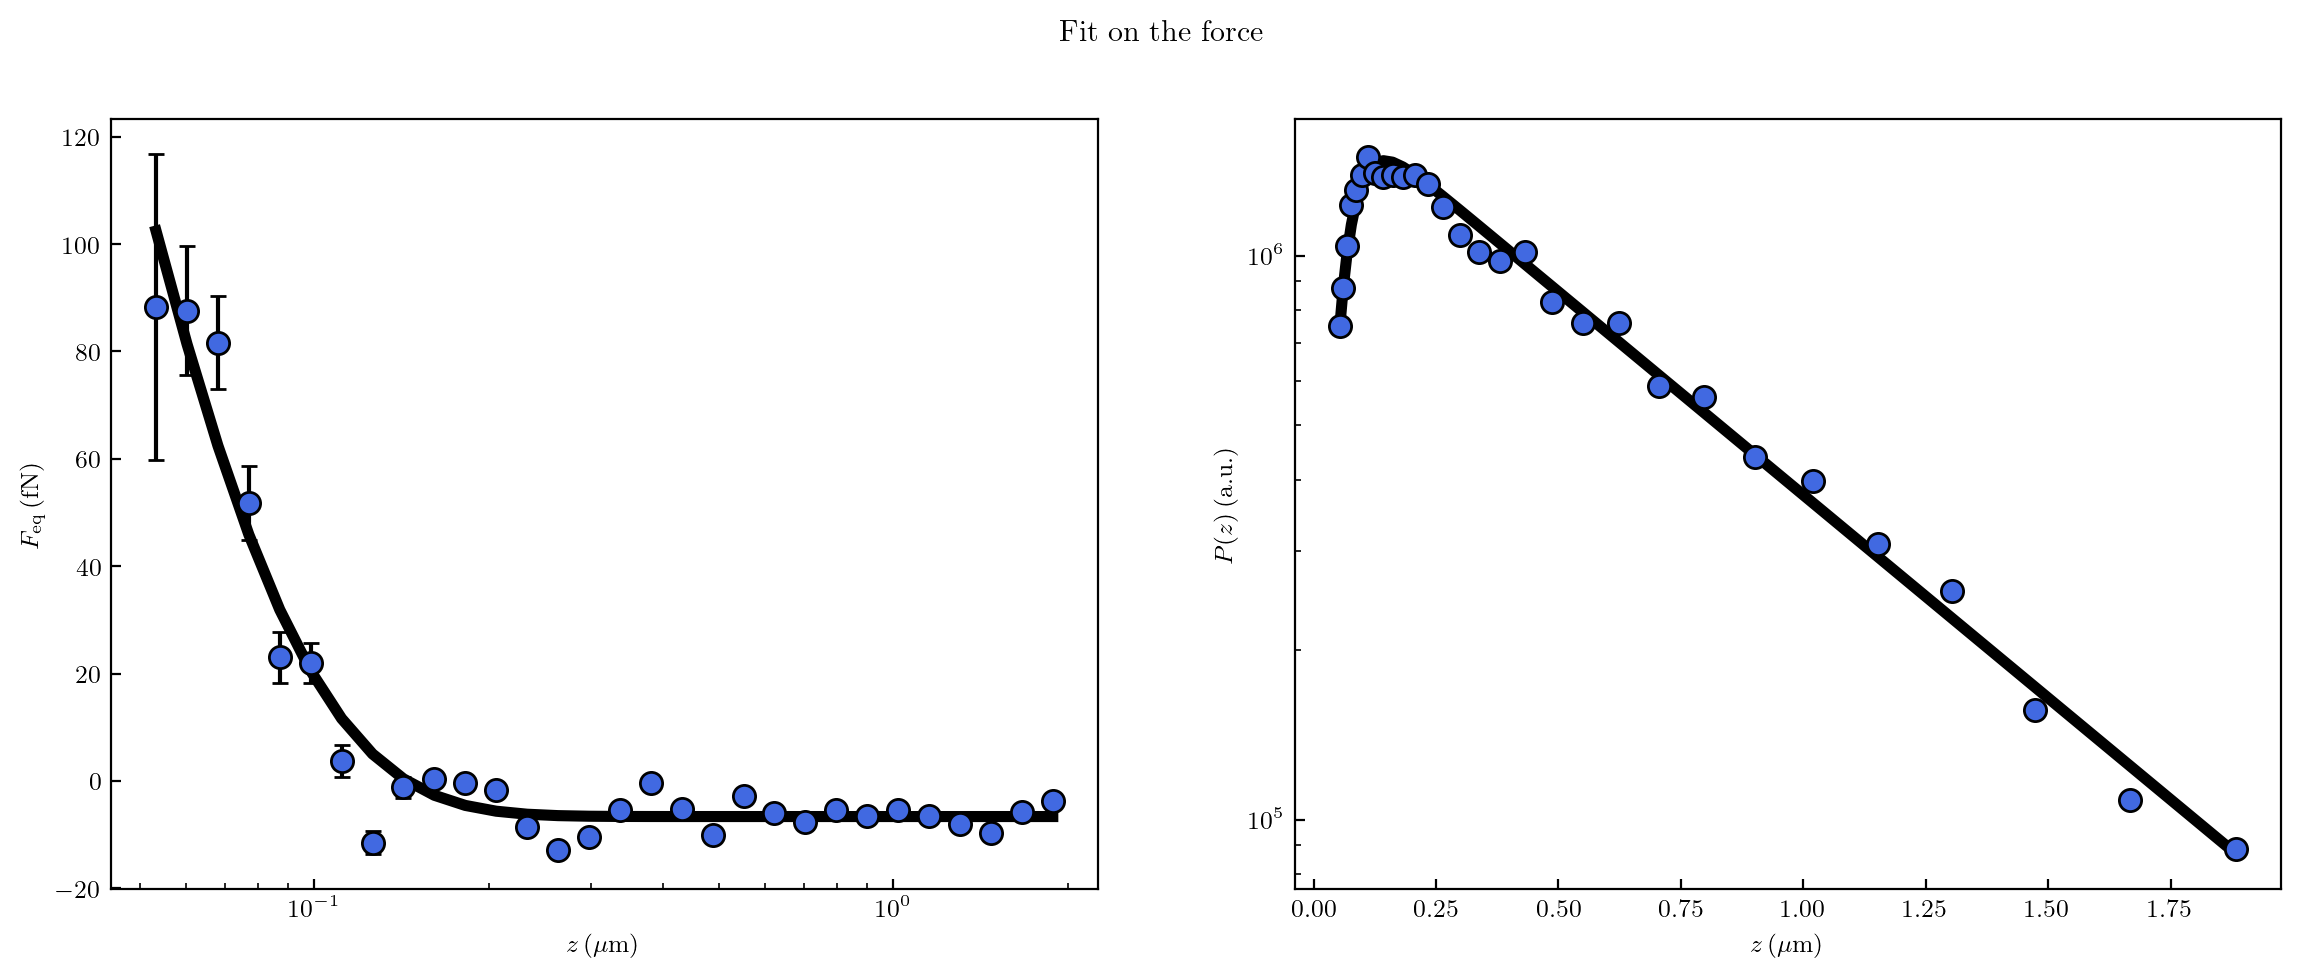

From the equilibrium force: [B, lD, offset_pdf] = 
[ 1.38530277e+01  3.25232512e-08 -3.61229880e-08]


In [338]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,5))

#ax1.plot(x_F_eq * 1e6, y_F_eq * 1e15, 'o', markerfacecolor='b', markersize=10, markeredgecolor='k', markeredgewidth=2)
ax1.errorbar(
    x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq * 1e15, 
    ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3,
)
ax1.plot(x_F_eq * 1e6, F_eq_theory(x_F_eq, *popt_F_eq) * 1e15, ls='-', c='k', linewidth=4)
ax1.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax1.set_ylabel("$F_{\mathrm{eq}} \, \mathrm{(fN)}$")
ax1.set_xscale("log")

ax2.errorbar(
    x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, 
    ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3,
)
ax2.plot(x_pdf_z * 1e6, P_b_semi_theory(x_pdf_z, *popt_F_eq), ls='-', c='k', linewidth=4)
ax2.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax2.set_ylabel("$P(z) \, \mathrm{(a.u.)}$")
ax2.set_yscale("log")

fig.suptitle("Fit on the force")

plt.show()

print("From the equilibrium force: [B, lD, offset_pdf] = ")
print(popt_F_eq)

In [75]:
# Check that the PDF is normed
print("Integral of the theoretical Peq = {0}".format(np.trapezoid(P_b_semi_theory(x_F_eq, *popt_F_eq), x_F_eq)))

Integral of the theoretical Peq = 1.0000000000000002


In [76]:
# Save data

tosave["min_distance"] = min_distance
tosave["max_distance"] = max_distance
tosave["n_bins"] = n_bins
tosave["n_noisy"] = n_noisy

tosave["x_pdf_z"] = np.copy(x_pdf_z)
tosave["width_pdf_z"] = np.copy(width_pdf_z)
tosave["y_pdf_z"] = np.copy(y_pdf_z)
tosave["err_y_pdf_z"] = np.copy(std_y_pdf_z)

tosave["x_F_eq"] = np.copy(x_F_eq)
tosave["width_F_eq"] = np.copy(width_F_eq)
tosave["y_F_eq"] = np.copy(y_F_eq)
tosave["err_y_F_eq"] = np.copy(std_y_F_eq)

tosave["lB_theory"] = lB_theory

## Mean Diffusion Coefficient: MSD vs. PDF

In [77]:
def Dz_z(z, b=0, nl=0):
    z = z + b
    res = (6 * z * z + 2 * r * z) / (6 * z * z + 9 * r * z + 2 * r * r)
    res += nl
    return res

def Dx_z(z, b=0, nl=0):
    z = z + b 
    res = 1 - 9/16 * (r / (z + r)) + 1/8 * (r / (z + r)) ** 3 - 45/256 * (r / (z + r)) ** 4 - 1/16 * (r / (z + r)) ** 5
    res += nl
    return res

def minimizer(x):
    b = x[0]
    
    xxx = np.linspace(10e-9, 5e-6, 1000)
    
    mean_D_para_from_pdf = np.trapezoid(Dx_z(xxx, b) * P_b_semi_theory(xxx, *popt_pdf_z[:2]), xxx)
    res = (mean_D_para_from_pdf - mean_D_para_from_MSD)**2 / mean_D_para_from_MSD**2
    
    mean_D_perp_from_pdf = np.trapezoid(Dz_z(xxx, b) * P_b_semi_theory(xxx, *popt_pdf_z[:2]), xxx)
    res += (mean_D_perp_from_pdf - mean_D_perp_from_MSD)**2 / mean_D_perp_from_MSD**2
    
    return res

In [78]:
minimizer([0])

np.float64(0.003083078154966632)

In [79]:
minimize_mean_D = minimize(
    minimizer, [0], 
    method="BFGS", 
    tol=1e-10, 
)

In [80]:
minimizer(minimize_mean_D.x)

np.float64(0.0001950724672345733)

In [81]:
b = minimize_mean_D.x[0]

xxx = np.linspace(10e-9, 5e-6, 1000)

mean_D_para_from_pdf = np.trapezoid(Dx_z(xxx, b) * P_b_semi_theory(xxx, *popt_pdf_z[:2]), xxx)
mean_D_perp_from_pdf = np.trapezoid(Dz_z(xxx, b) * P_b_semi_theory(xxx, *popt_pdf_z[:2]), xxx)

del xxx

print("Mean D para = {0:.3f}D0 (from MSD) and {1:.3f}D0 (from PDF)".format(mean_D_para_from_MSD, mean_D_para_from_pdf))
print("Mean D perp = {0:.3f}D0 (from MSD) and {1:.3f}D0 (from PDF)".format(mean_D_perp_from_MSD, mean_D_perp_from_pdf))
print("Estimated 'slip length' = {0:.1f} nm".format(b * 1e9))
print()
print("Be careful: this value assumes correct measurement of B, lD, lB")

Mean D para = 0.569D0 (from MSD) and 0.576D0 (from PDF)
Mean D perp = 0.272D0 (from MSD) and 0.271D0 (from PDF)
Estimated 'slip length' = 39.4 nm

Be careful: this value assumes correct measurement of B, lD, lB


## Diffusion as a Function of the Distance to the Wall

In [82]:
# Domain to plot the diffusion profile
z_min_force = min_distance #10e-9
z_max_force = max_distance #2e-6
N_bins_force = n_bins 

In [83]:
timestep_diffusion = 1

### Determine the optimal polynomial order for Ronceray

In [84]:
all_orders = True

In [85]:
if all_orders:

    pos = np.ones((len(x), 3))
    
    x_new = x - np.min(x)
    y_new = y - np.min(y)
    z_new = np.copy(z_dedrift)

    pos[:, 0] = x_new
    pos[:, 1] = y_new
    pos[:, 2] = z_new
    
    dt = timestep_diffusion / fps
    
    Dx1, Dy1, Dz1, z_D1 = Compute_diffusion(pos, dt, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=1, method="Vestergaard")
    Dx2, Dy2, Dz2, z_D2 = Compute_diffusion(pos, dt, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=2, method="Vestergaard")
    Dx3, Dy3, Dz3, z_D3 = Compute_diffusion(pos, dt, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=3, method="Vestergaard")
    Dx4, Dy4, Dz4, z_D4 = Compute_diffusion(pos, dt, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=4, method="Vestergaard")
    # Dx5, Dy5, Dz5, z_D5, err_Dz5 = Compute_diffusion(pos, dt, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=5, method="Vestergaard")
    
    del pos, x_new, y_new, z_new
    
    D_para_z1 = (Dx1 + Dy1) / 2 
    D_para_z2 = (Dx2 + Dy2) / 2 
    D_para_z3 = (Dx3 + Dy3) / 2 
    D_para_z4 = (Dx4 + Dy4) / 2 
    # D_para_z5 = (Dx5 + Dy5) / 2 

    D_perp_z1 = Dz1 
    D_perp_z2 = Dz2 
    D_perp_z3 = Dz3 
    D_perp_z4 = Dz4 
    # D_perp_z5 = Dz5 

In [101]:
# eta_m = 0.00093

In [103]:
# D0 = 4e-21 / (6*np.pi*eta_m*r)

In [104]:
def min_arrays(t1, t2):
    if t1[0] < t2[0]:
        return t1
    return t2

def max_arrays(t1, t2):
    if t1[0] < t2[0]:
        return t2
    return t1

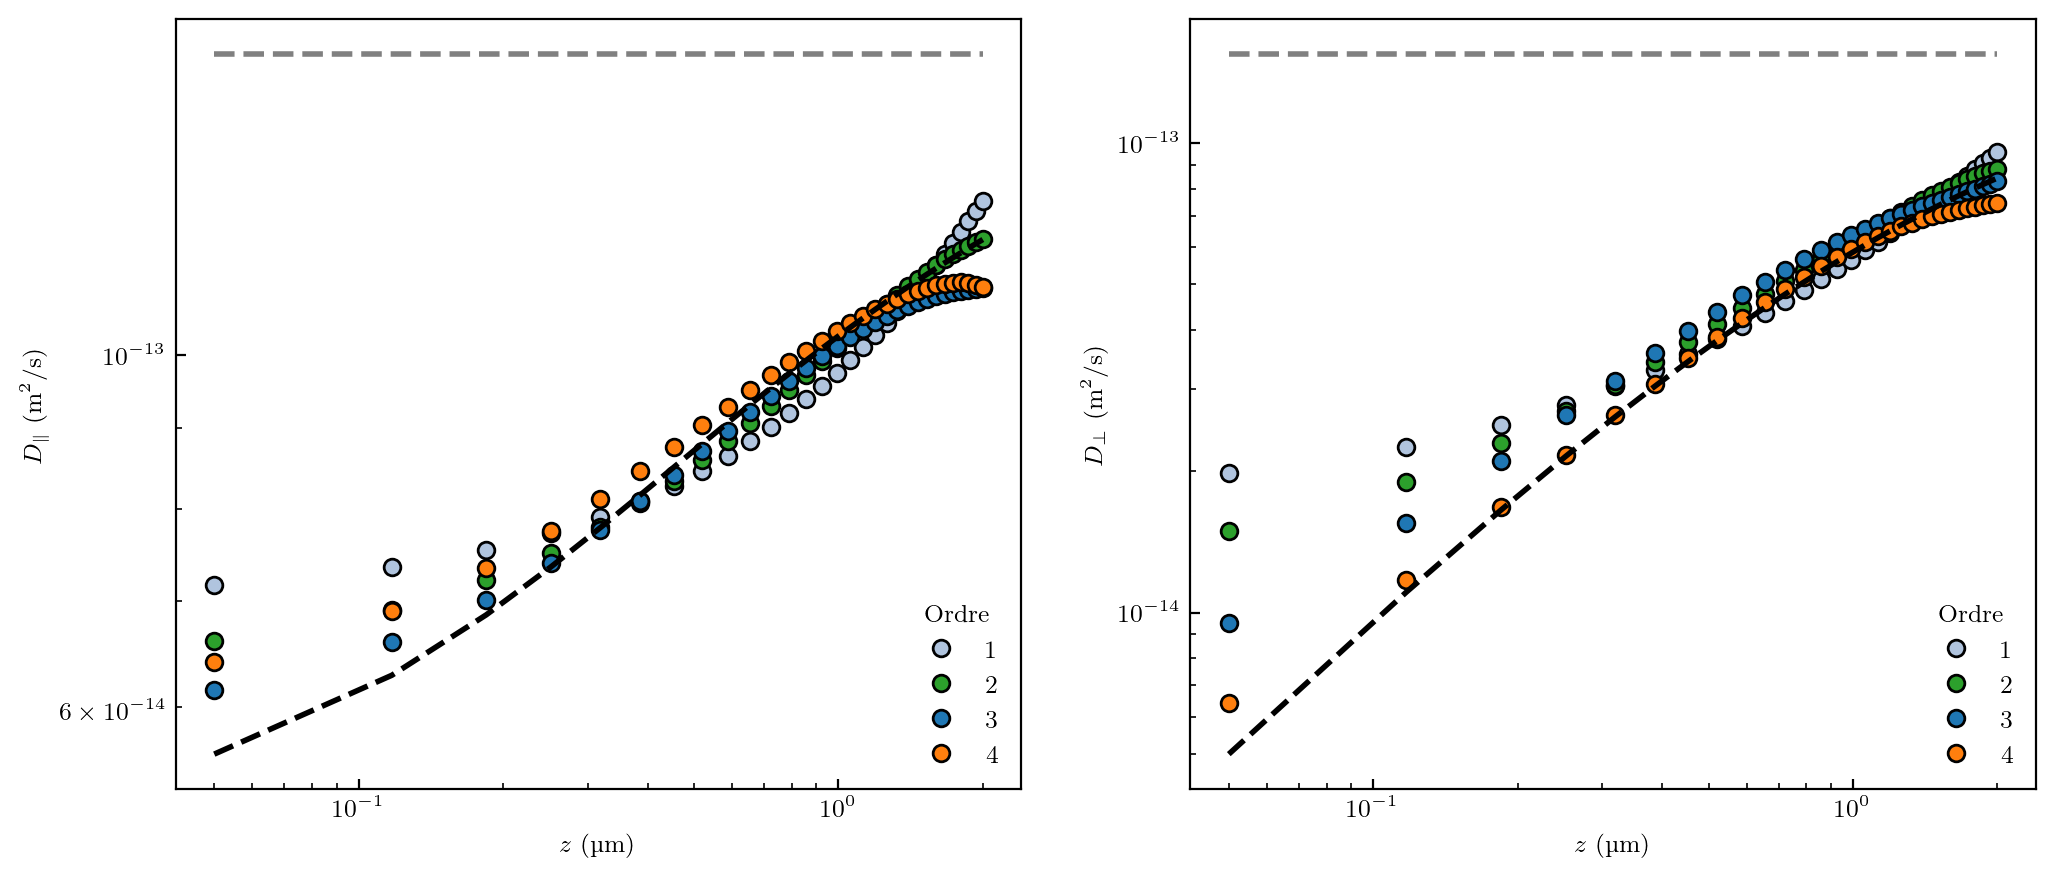

In [105]:
if all_orders:

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5))

    colors = ['lightsteelblue', 'tab:green', 'tab:blue', 'tab:orange', 'tab:red']

    ax1.plot(z_D1 * 1e6, D_para_z1, 'o', color=colors[0], label='1')
    ax1.plot(z_D2 * 1e6, D_para_z2, 'o', color=colors[1], label='2')
    ax1.plot(z_D3 * 1e6, D_para_z3, 'o', color=colors[2], label='3')
    ax1.plot(z_D4 * 1e6, D_para_z4, 'o', color=colors[3], label='4')
    # ax1.plot(z_D5 * 1e6, D_para_z5, 'o', color=colors[4], label='5')
    ax1.plot(z_D1 * 1e6, D0 * Dx_z(z_D1, 0, nl=0), ls='--', c='k', linewidth=2)
    ax1.plot(z_D1 * 1e6, D0 * np.ones(len(z_D1)), ls='--', c='gray', linewidth=2)
    # ax1.plot(r / z_D1 , - (D0 * Dx_z(z_D1, 0, nl=0) - D_para_z3) / D0 + 1, marker='o', c='k')
    # ax1.plot(r / z_D1, 3/8 * r / z_D1, '-.')

    # ax1.fill_between(
    #     z_D1 * 1e6, min_arrays(Dx1, Dy1), max_arrays(Dx1, Dy1), 
    #     alpha = 0.2, color=colors[0],
    # )
    # ax1.fill_between(
    #     z_D2 * 1e6, min_arrays(Dx2, Dy2), max_arrays(Dx2, Dy2), 
    #     alpha = 0.2, color=colors[1],
    # )
    # ax1.fill_between(
    #     z_D3 * 1e6, min_arrays(Dx3, Dy3), max_arrays(Dx3, Dy3), 
    #     alpha = 0.2, color=colors[2],
    # )
    # ax1.fill_between(
    #     z_D4 * 1e6, min_arrays(Dx4, Dy4), max_arrays(Dx4, Dy4), 
    #     alpha = 0.2, color=colors[3],
    # )
    # # ax1.fill_between(
    # #     z_D5 * 1e6, min_arrays(Dx5, Dy5), max_arrays(Dx5, Dy5), 
    # #     alpha = 0.2, color=colors[4],
    # # )

    ax1.legend(frameon=False, title='Ordre')
    
    ax1.set(
        xlabel="$z$ (µm)", 
        ylabel="$D_\parallel$ ($\mathrm{m^2/s}$)", 
        xscale='log', 
        yscale='log', 
    )

    ax2.plot(z_D1 * 1e6, D_perp_z1, 'o', color=colors[0], label='1')
    ax2.plot(z_D2 * 1e6, D_perp_z2 - 0.02 * D0 * 0, 'o', color=colors[1], label='2')
    ax2.plot(z_D3 * 1e6, D_perp_z3, 'o', color=colors[2], label='3')
    ax2.plot(z_D4 * 1e6, D_perp_z4, 'o', color=colors[3], label='4')
    # ax2.plot(z_D5 * 1e6, D_perp_z5, 'o', color=colors[4], label='5')
    ax2.plot(z_D1 * 1e6, D0 * Dz_z(z_D1, 0, nl=0), ls='--', c='k', linewidth=2)
    ax2.plot(z_D1 * 1e6, D0 * np.ones(len(z_D1)), ls='--', c='gray', linewidth=2)

    ax2.legend(frameon=False, title='Ordre')
    
    ax2.set(
        xlabel="$z$ (µm)", 
        ylabel="$D_\perp$ ($\mathrm{m^2/s}$)", 
        xscale='log', 
        yscale='log', 
    )

    plt.show()

In [106]:
# fig.savefig('diffusion_profile_several_orders_Ronceray.pdf')

In [107]:
# if all_orders:
    
#     # Normalize by D0
    
#     D_para_z1 = (Dx1 + Dy1) / 2 / D0
#     D_para_z2 = (Dx2 + Dy2) / 2 / D0
#     D_para_z3 = (Dx3 + Dy3) / 2 / D0
#     D_para_z4 = (Dx4 + Dy4) / 2 / D0
#     D_para_z5 = (Dx5 + Dy5) / 2 / D0

#     D_perp_z1 = Dz1 / D0
#     D_perp_z2 = Dz2 / D0
#     D_perp_z3 = Dz3 / D0
#     D_perp_z4 = Dz4 / D0
#     D_perp_z5 = Dz5 / D0

### Compute Diffusion Profiles

In [108]:
# Orders used to infer the diffusion profiles

order_perp = 4
order_para = 4

In [109]:
# Dx, Dy, Dz, z_D = Dx2, Dy2, Dz2, z_D2
# err_Dx = err_Dz2
# err_Dz = err_Dz2
# Dx, Dy, Dz, z_D = Dx3, Dy3, Dz3, z_D3
# err_Dx = err_Dz3
# err_Dz = err_Dz3
# Dx, Dy, Dz, z_D = Dx4, Dy4, Dz4, z_D4
# err_Dx = err_Dz4
# err_Dz = err_Dz4

In [110]:
# Define a trajectory input that Ronceray understands

pos = np.ones((len(x), 3))

x_new = x - np.min(x)
y_new = y - np.min(y)
z_new = np.copy(z_dedrift)

pos[:, 0] = x_new
pos[:, 1] = y_new
pos[:, 2] = z_new

# Compute the diffusion profiles, according to Ronceray's method 

def two_compute_diffusion(pos, fps, z_min, z_max, N_bins, order_perp, order_para, method="Vestergaard"):
    if order_perp == order_para:
        Dx, Dy, Dz, z_D = Compute_diffusion(
            pos, 1/fps, 
            z_min=z_min, z_max=z_max, N=N_bins, 
            ordre=order_perp, 
            method=method, 
        )
    else:
        Dx, Dy, _, _ = Compute_diffusion(
            pos, 1/fps, 
            z_min=z_min, z_max=z_max, N=N_bins, 
            ordre=order_para, 
            method=method, 
        )
        _, _, Dz, z_D = Compute_diffusion(
            pos, 1/fps, 
            z_min=z_min, z_max=z_max, N=N_bins, 
            ordre=order_perp, 
            method=method, 
        )
    return Dx, Dy, Dz, z_D

Dx, Dy, Dz, z_D = two_compute_diffusion(
    pos, fps/timestep_diffusion, z_min_force, z_max_force, N_bins_force, order_perp, order_para, method="Vestergaard",
)

# Check for the errors computation, does not work anymore

del pos, x_new, y_new, z_new

In [111]:
# err_Dx = np.sqrt(err_Dx) * mean_D_para_from_MSD * D0
# err_Dz = np.sqrt(err_Dz) * mean_D_perp_from_MSD * D0

In [112]:
# Determine the Vestergaard error (on the diffusion)

# Parallel, x
autocor_dx = x[1:] - x[:-1]
autocor_dx = autocor_dx - np.mean(autocor_dx)
sigma2_x = np.mean(autocor_dx[1:] * autocor_dx[:-1])
err_x = np.sqrt(sigma2_x)
# err_Dx_z = 2 * sigma2_x / (2 * 5/6 * 1/fps) / D0
err_Dx_z = sigma2_x / (2 * 1/fps) / D0

# Parallel, y
autocor_dy = y[1:] - y[:-1]
autocor_dy = autocor_dy - np.mean(autocor_dy)
sigma2_y = np.mean(autocor_dy[1:] * autocor_dy[:-1])
err_y = np.sqrt(sigma2_y)
# err_Dy_z = 2 * sigma2_y / (2 * 5/6 * 1/fps) / D0
err_Dy_z = sigma2_y / (2 * 1/fps) / D0

# # Perpendicular 
autocor_dz = z_dedrift[1:] - z_dedrift[:-1]
autocor_dz = autocor_dz - np.mean(autocor_dz)
sigma2_z = np.mean(autocor_dz[1:] * autocor_dz[:-1]) 
if sigma2_z < 0:
    sigma2_z = np.abs(sigma2_z)
    print("/!\ WARNING /!\ ")
    print("The Vestergaard error on the z-diffusion was negative!")
    print("The absolute value of this error was used instead")
    print()
err_z = np.sqrt(sigma2_z)
# err_Dz_z = 2 * sigma2_z / (2 * 5/6 * 1/fps) / D0
err_Dz_z = sigma2_z / (2 * 1/fps) / D0

print("Vestergaard error: ")
print("   - x: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_x*1e9, err_Dx_z))
print("   - y: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_y*1e9, err_Dy_z))
print("   - z: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_z*1e9, err_Dz_z))

Vestergaard error: 
   - x: on position = 12.8 nm and on diffusion = 0.05 D0
   - y: on position = 12.9 nm and on diffusion = 0.05 D0
   - z: on position = 5.4 nm and on diffusion = 0.01 D0


In [113]:
D_para_z = (Dx + Dy) / 2 / D0 #- err_Dx_z
D_perp_z = np.copy(Dz) / D0 #- err_Dz_z  #- noiselevel_D_perp_from_MSD

zlim = 500e-9

popt_D_para_z, pcov_D_para_z = curve_fit(lambda x, b: Dx_z(x, b, nl=0), z_D[z_D < zlim], D_para_z[z_D < zlim], p0=[1e-9])
popt_D_perp_z, pcov_D_perp_z = curve_fit(lambda x, b: Dz_z(x, b, nl=0), z_D[z_D < zlim], D_perp_z[z_D < zlim], p0=[1e-9])
# floc = lambda x, nl: Dz_z(x, b=0, nl=nl)
# popt_D_perp_z, pcov_D_perp_z = curve_fit(floc, z_D[z_D < 500e-9], D_perp_z[z_D < 500e-9], p0=[0.04])

offset_D_from_para = popt_D_para_z[0]
offset_D_from_perp = popt_D_perp_z[0]
offset_D_from_D_z = (offset_D_from_para + offset_D_from_perp) / 2

print("Offset on the diffusion:")
print("   From para: {0:.3f} nm".format(offset_D_from_para * 1e9))
print("   From perp: {0:.3f} nm".format(offset_D_from_perp * 1e9))
print("   Average: {0:.3f} nm".format(offset_D_from_D_z * 1e9))

Offset on the diffusion:
   From para: 68.824 nm
   From perp: 7.663 nm
   Average: 38.243 nm


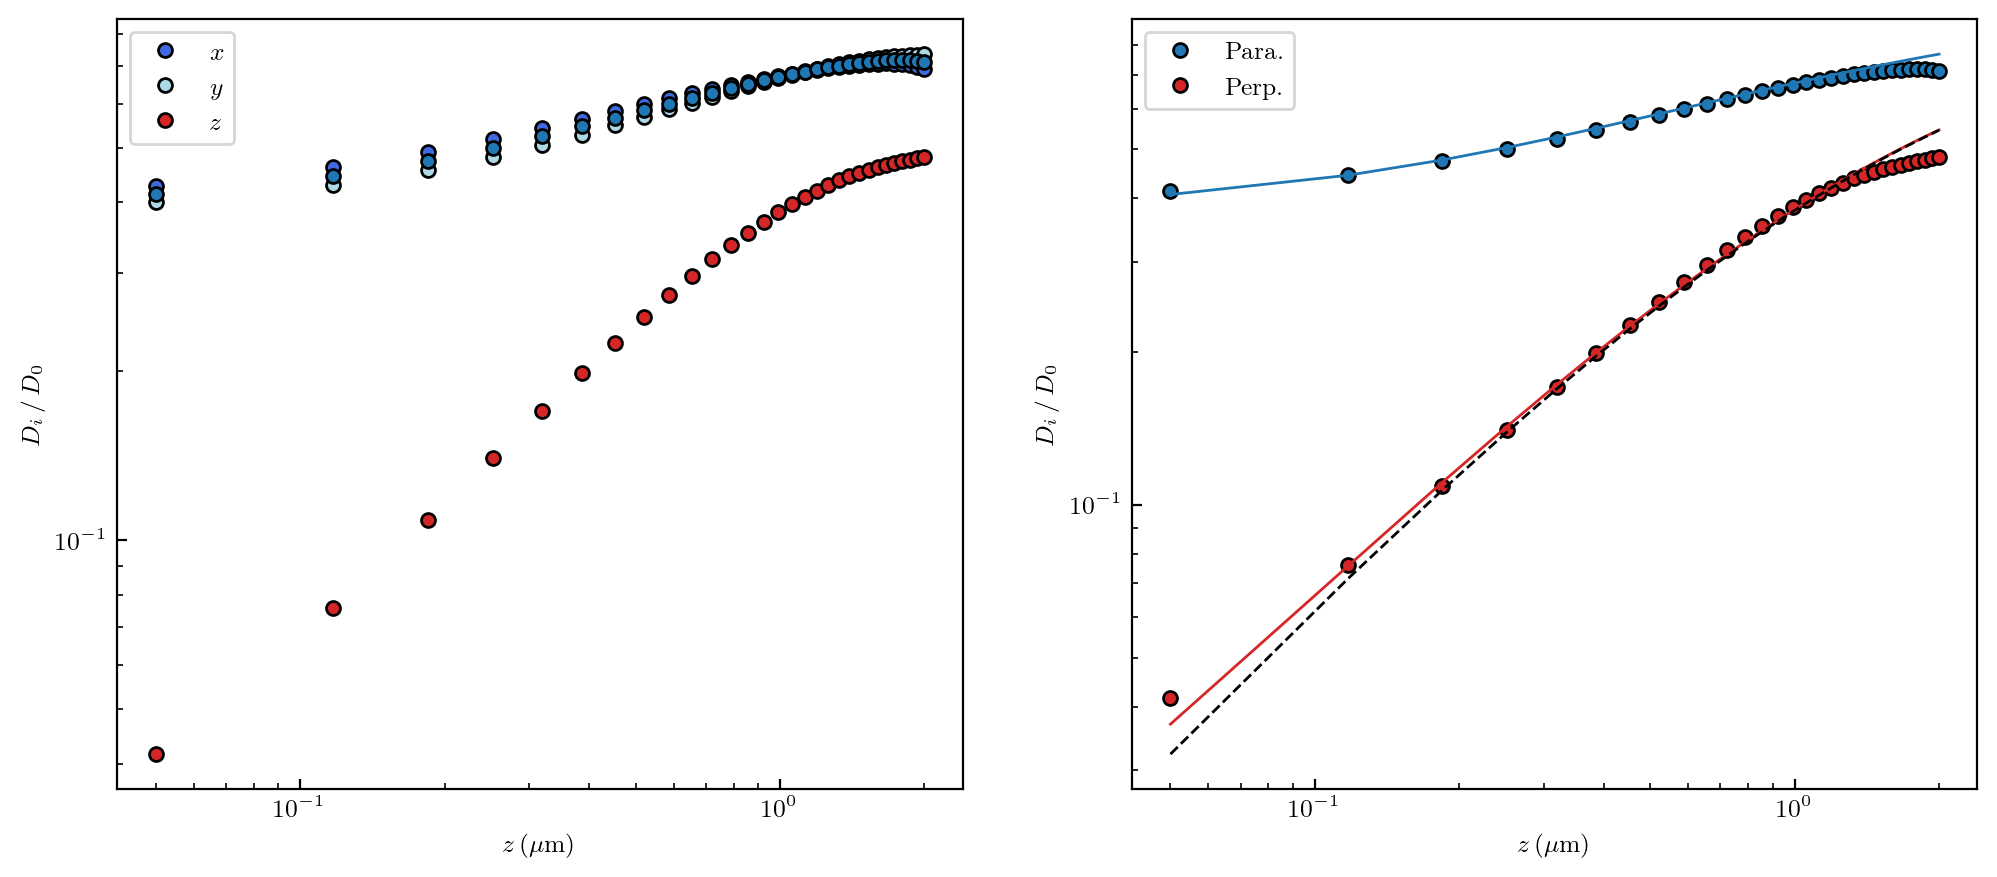

In [114]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(z_D * 1e6, Dx / D0, 'o', markerfacecolor='royalblue', markersize=5, markeredgecolor='k', markeredgewidth=1, label="$x$")
ax1.plot(z_D * 1e6, Dy / D0, 'o', markerfacecolor='lightblue', markersize=5, markeredgecolor='k', markeredgewidth=1, label="$y$")
ax1.plot(z_D * 1e6, D_para_z, 'o', markerfacecolor='tab:blue', markersize=5, markeredgecolor='k', markeredgewidth=1)
ax1.plot(z_D * 1e6, Dz / D0, 'o', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=1, label="$z$")
ax1.legend()
ax1.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax1.set_ylabel("$D_i \, / \, D_0$")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax2.plot(z_D * 1e6, D_para_z, 'o', markerfacecolor='tab:blue', markersize=5, markeredgecolor='k', markeredgewidth=1, label="Para.")
ax2.plot(z_D * 1e6, Dx_z(z_D, offset_D_from_para, nl=0), ls='-', c='tab:blue', linewidth=1)
ax2.plot(z_D * 1e6, D_perp_z, 'o', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=1, label="Perp.")
ax2.plot(z_D * 1e6, Dz_z(z_D, offset_D_from_perp, nl=0), ls='-', c='tab:red', linewidth=1)
# ax2.plot(z_D * 1e6, Dz_z(z_D, b=0, nl=offset_D_from_perp), ls='-', c='tab:red', linewidth=1)
ax2.plot(z_D * 1e6, Dz_z(z_D, 0., nl=0.), ls='--', c='k', linewidth=1)
ax2.legend()
ax2.set_xlabel("$z \, \mathrm{(\mu m)}$")
ax2.set_ylabel("$D_i \, / \, D_0$")
ax2.set_xscale("log")
ax2.set_yscale("log")

plt.show()

In [115]:
( np.nanmean(z_dedrift**2) * 0.65 ) ** 0.5 / 3

np.float64(2.2633334980154192e-07)

In [116]:
# Save data

tosave['order_perp'] = order_perp
tosave['order_para'] = order_para

tosave["z_D"] = np.copy(z_D)
tosave["D_para_z"] = np.copy(D_para_z)
tosave["D_perp_z"] = np.copy(D_perp_z)

tosave["Vestergaard_err_x"] = err_x
tosave["Vestergaard_err_y"] = err_y
tosave["Vestergaard_err_z"] = err_z
tosave["Vestergaard_err_Dx_z"] = err_Dx_z
tosave["Vestergaard_err_Dy_z"] = err_Dy_z
tosave["Vestergaard_err_Dz_z"] = err_Dz_z

## Define Range of Interest for Diffusive Properties

In [117]:
# Must keep the same bins as the Peq.
# Just troncate the bins of Peq = bins of D_i.

z_D_min = 0.
z_D_max = 0.7e-6 # max distance 

D_para_z = D_para_z[(z_D <= z_D_max)]
D_perp_z = D_perp_z[(z_D <= z_D_max)]
z_D = z_D[(z_D <= z_D_max)]

In [118]:
tosave["z_D_max"] = z_D_max

## Force, Using Only Experimental Points (Interpolation On the Diffusion Profiles)

In [119]:
#
#
#
#
#
#
#
#
#
#
# # # INTERPOLATION ON BRENNER
#
#
#
#
#
#
#
#
#
#

In [120]:
# Interpolation on the diffusion profile
# The order of the polynomial used should be the same as the order used in Ronceray's computation of the diffusion (Compute_diffusion)
 
coefs = np.polyfit(z_D, D_perp_z, order_perp) #, w=pdf_z/np.max(pdf_z))

# coefs = np.polyfit(z_D, Dz_z(z_D, 0., nl=0.), order_perp) 


# p = lambda x: coef3 * x**3 + coef2 * x**2 + coef1 * x + coef0
p = np.poly1d(coefs)
# Here, we have the experimental function Dz(z).
# dpdz = lambda x: 3 * coef3 * x**2 + 2 * coef2 * x + coef1
dpdz = np.polyder(p, 1)
# Here, we have the experimental derivative of Dz(z).

In [121]:
p

poly1d([ 1.45036505e+22, -2.94561625e+16, -1.50220807e+11,  5.35797277e+05,
        1.51955102e-02])

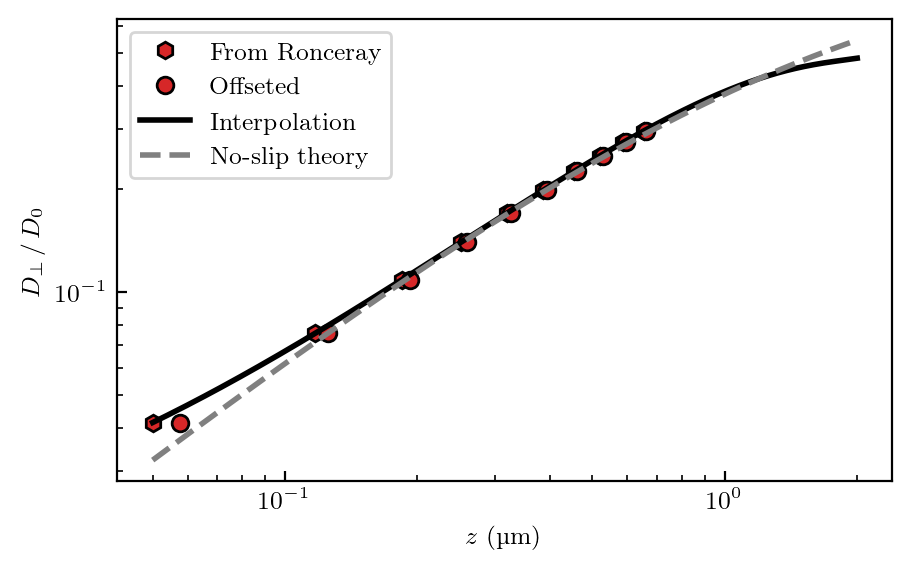

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

z_to_plot = np.linspace(z_min_force, z_max_force, 1000)

ax.plot(
    z_D * 1e6, D_perp_z, 
    'h', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=1, 
    label="From Ronceray", 
)
ax.plot(
    (z_D + offset_D_from_perp) * 1e6, D_perp_z, 
    'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=1, 
    label="Offseted", 
)
ax.plot(z_to_plot * 1e6, p(z_to_plot), ls='-', linewidth=2, c='k', label="Interpolation")
ax.plot(z_to_plot * 1e6, Dz_z(z_to_plot, 0, nl=0), ls='--', linewidth=2, c='gray', label="No-slip theory")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim([1e-2, 1])
#ax.set_ylim([5e-16, 4e-13])

ax.set_xlabel("$z$ (µm)")
ax.set_ylabel("$D_\perp \, / \, D_0$")

ax.legend()

plt.show()

### Binning For the Force Computation

In [123]:
# The total force is computed using diffusion profiles and drifts. 
# The total force must be computed using Ito's convention (i.e. using the left border of the chosen bins).
# In the mean time, the total force must be computed for the same set of z than the equilibrium force (i.e. for the same bins as the pdf). 
# So the bins centers of the pdf (i.e. the equilibrium force) are considered as the left of the bins of the total total force.
bins_left = x_pdf_z[:] 
bins_edges = np.concatenate((bins_left, np.array([x_pdf_z[-1] + width_pdf_z[-1] / 2])))
bins_width = bins_edges[1:] - bins_edges[:-1]

In [124]:
coefs = np.polyfit(z_D, D_perp_z, order_perp) #, w=pdf_z/np.max(pdf_z))
p_sfi = np.poly1d(coefs)
sfi = p_sfi(bins_left) * D0 # Dz(z)

coefs = np.polyfit(z_D, Dz_z(z_D, 0., nl=0.), order_perp) 
p_bre = np.poly1d(coefs)
bre = p_bre(bins_left) * D0

taumax_sfi = bins_width ** 2 / (2 * sfi) 
taumax_bre = bins_width ** 2 / (2 * bre) 

In [125]:
f_taumax = lambda x: np.poly1d(np.polyfit(bins_left[(bins_left <= z_D_max-0.1e-6)], taumax_sfi[(bins_left <= z_D_max-0.1e-6)], 5))(x) - 1/fps

epsilon = 10e-9

bin_min = fsolve(f_taumax, [200e-9], xtol=epsilon)[0]

In [126]:
f_taumax(100e-9)

np.float64(-0.0017686297721769603)

In [127]:
fsolve(f_taumax, [200e-9], xtol=epsilon)

array([1.17073816e-07])

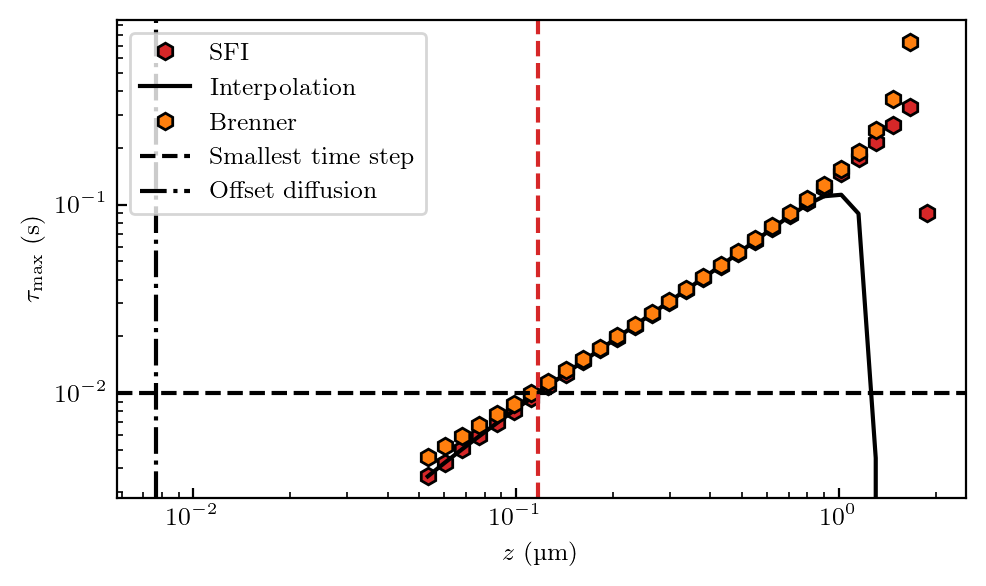

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

ax.plot(
    bins_left * 1e6, taumax_sfi, 
    'h', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=1, 
    label="SFI", 
)
ax.plot(
    bins_left * 1e6, f_taumax(bins_left) + 1/fps, 
    '-k',  
    label="Interpolation", 
)
ax.plot(
    bins_left * 1e6, taumax_bre, 
    'h', markerfacecolor='tab:orange', markersize=6, markeredgecolor='k', markeredgewidth=1, 
    label="Brenner", 
)
ax.axhline(y=timestep_diffusion/fps, ls='--', c='k', label='Smallest time step')
ax.axvline(x=offset_D_from_perp*1e6, ls='-.', c='k', label='Offset diffusion')
ax.axvline(x=bin_min*1e6, ls='--', c='tab:red')

ax.legend()

ax.set(
    xscale='log', 
    yscale='log', 
    xlabel="$z$ (µm)", 
    ylabel=r'$\tau_\mathrm{max}$ (s)', 
)

plt.tight_layout()
plt.show()

### Force

In [129]:
def ComputeForce(
    return_all=False, 
    z_D_max=1e-6, tau=timestep_diffusion, 
    p=p, dpdz=dpdz, z_dedrift=z_dedrift, x_pdf_z=x_pdf_z, eta_m=eta_m, r=r, fps=fps, 
):
    all_f = []
    
    if type(tau) in [int, np.int64, float]:
        tau_interval = np.arange(tau, tau+1)
    else:
        tau_interval = np.copy(tau)

    for i in range(10):

        bins_left = x_pdf_z[x_pdf_z <= z_D_max] # np.copy(x_pdf_z) 
        bins_edges = np.concatenate((bins_left, np.array([bins_left[-1] + width_pdf_z[len(bins_left)-1] / 2])))

        Dz_z_exp = p(bins_left) # Exp points interpolated
        Dz_z_prime_exp = dpdz(bins_left)

        vz, err_vz = co.vzz(
            bins_edges, z_dedrift + np.random.normal(loc=0, scale=3e-9, size=len(z_dedrift)), 
            times=tau_interval, 
            fps=fps, 
        )

        F1 = 6 * np.pi * eta_m * 1 / Dz_z_exp * r * vz # Drag term
        F2 = - 4e-21 * Dz_z_prime_exp / Dz_z_exp # Spurious drift term
        # F2 = - 4e-21 / bins_left # Spurious drift term
        f_tot = F1 + F2

        all_f.append(f_tot) 

    F_tot = np.nanmean(all_f, axis=0)
    # err_F_tot = np.nanstd(all_f, axis=0)
    err_F_tot = 2 * noise_level_perp_from_MSD / bins_left * F_tot

    del all_f, F1, F2, f_tot

    x_F_eq_trunc = x_F_eq[x_pdf_z <= z_D_max]
    y_F_eq_trunc = y_F_eq[x_pdf_z <= z_D_max]
    err_y_F_eq_trunc =  err_y_F_eq[x_pdf_z <= z_D_max]

    F_nc = F_tot - y_F_eq_trunc
    
    if not(return_all):
        return bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc
    else:
        return bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp

### First Time Step

In [130]:
z_D_max

7e-07

In [131]:
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(
    z_D_max=z_D_max, 
    tau=1, #np.arange(timestep_diffusion, timestep_diffusion+fps),  
    return_all=True, 
)

F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)

# Thermal noise 
tau_boxes = err_vz * 1/fps
F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z_exp * r / tau_boxes)

In [132]:
def v2_thermal(a, rho, kT):
    m = 4/3 * np.pi * a**3 * rho
    return kT / m

In [133]:
def F_EHD(z, gamma=70e-3, eta=0.001, a=r, rho=rho_m+drho, kT=4e-21): 
    Vsquared = v2_thermal(a, rho, kT)
    alpha = 1
    return 1e-27 * alpha * z**(-2)

# def F_EHD(z, gamma=70e-3, eta=0.001, a=r, rho=rho_m+drho, kT=4e-21): 
#     Vsquared = v2_thermal(a, rho, kT)
#     alpha = eta**2 * Vsquared / gamma * a**(3)
#     return 10 * alpha * z**(-2)

x_reference = np.copy(x_pdf_z) #np.linspace(z_min_force, z_max_force, 1000)
F_nc_ref = F_EHD(x_reference, gamma=3e-3, eta=0.001)

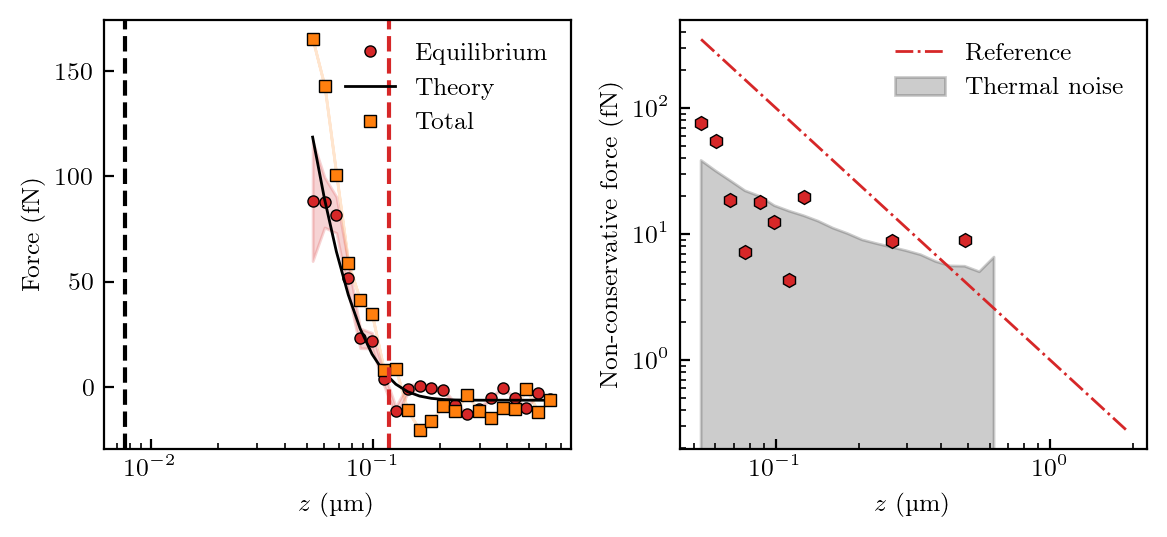

In [134]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15/2.54, 7/2.54))

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'o', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
ax1.fill_between(
    bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc)*1e15, 
    alpha = 0.2, color ="tab:red", 
    # label = "Thermal noise"
)
ax1.plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
ax1.fill_between(
    bins_left * 1e6, (F_tot - err_F_tot)*1e15, (F_tot + err_F_tot)*1e15, 
    alpha = 0.2, color ="tab:orange", 
    # label = "Thermal noise",
)
ax1.axvline(x=offset_D_from_perp*1e6, ls='--', c='k')
ax1.axvline(x=bin_min*1e6, ls='--', c='tab:red')
ax1.legend(frameon=False)
ax1.set(
    xlabel="$z$ (µm)", 
    ylabel="Force (fN)", 
    xscale='log', 
    yscale='linear', 
    # xlim=[0.1, None], 
    # ylim=[-200, 200], 
)

ax2.plot(bins_left * 1e6, F_nc * 1e15, 'h', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=0.5)
ax2.plot(x_reference * 1e6, F_nc_ref * 1e15, ls='-.', linewidth=1, c='tab:red', label="Reference")
ax2.axhline(y=0, xmin=0, xmax=len(bins_left), ls='--', c='k', linewidth=1)
ax2.fill_between(
    bins_left * 1e6, (np.zeros(len(bins_left)) - 1 * F_err_th)*1e15, (np.zeros(len(bins_left)) + 1 * F_err_th)*1e15, 
    alpha = 0.2, color ="k", label = "Thermal noise"
)
ax2.legend(frameon=False)
ax2.set(
    xlabel="$z$ (µm)", 
    ylabel="Non-conservative force (fN)", 
    xscale='log', 
    yscale='log', 
)

plt.tight_layout()
plt.show()

In [135]:
# fig, axes = plt.subplots(2, 1, figsize=(8/2.54, 8/2.54))

# axes[0].plot(
#     bins_left * 1e6, taumax_sfi, 
#     'h', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=1, 
#     label="SFI", 
# )
# # axes[0].plot(
# #     bins_left * 1e6, f_taumax(bins_left) + 1/fps, 
# #     '-k',  
# #     label="Interpolation", 
# # )
# axes[0].axhline(y=timestep_diffusion/fps, ls='--', c='k', label='Smallest time step')
# # axes[0].axvline(x=offset_D_from_perp*1e6, ls='--', c='k', label='Offset diffusion')
# axes[0].axvline(x=bin_min*1e6, ls='--', c='tab:red')

# axes[0].set(ylabel=r'$\tau_\mathrm{bin}$ (s)', xscale='log', yscale='log')

# axes[1].plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'o', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
# axes[1].plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
# axes[1].fill_between(
#     bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc)*1e15, 
#     alpha = 0.2, color ="tab:red", 
#     # label = "Thermal noise"
# )
# axes[1].plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
# axes[1].fill_between(
#     bins_left * 1e6, (F_tot - err_F_tot)*1e15, (F_tot + err_F_tot)*1e15, 
#     alpha = 0.2, color ="tab:orange", 
#     # label = "Thermal noise",
# )
# # axes[1].axvline(x=offset_D_from_perp*1e6, ls='--', c='k')
# axes[1].axvline(x=bin_min*1e6, ls='--', c='tab:red')
# axes[1].legend(frameon=False)

# axes[1].set(xlabel=r"$z \, \mathrm{(\mu m)}$", ylabel='Forces (fN)', xscale='log', yscale='linear')

# plt.tight_layout()
# plt.show()

In [136]:
# fig.savefig('tau_bins_z_larger_bins.pdf')

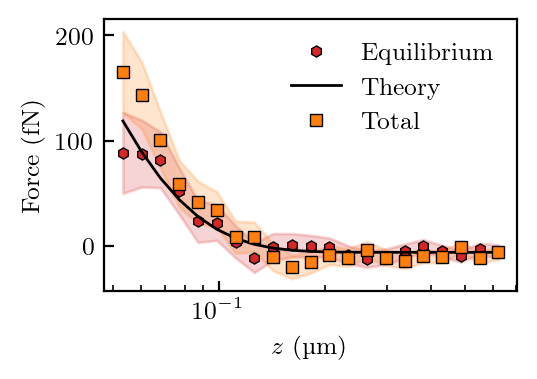

In [137]:
fig, ax1 = plt.subplots(1, 1, figsize=(7/2.54, 5/2.54))

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'h', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
ax1.plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
# ax1.fill_between(
#     bins_left * 1e6, (F_eq_theoretical - F_err_th)*1e15, (F_eq_theoretical + F_err_th)*1e15, 
#     alpha = 0.2, color ="tab:red", label = "Thermal noise"
# )
ax1.fill_between(
    bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc * 0 - F_err_th)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc * 0 + F_err_th)*1e15, 
    alpha = 0.2, color ="tab:red", 
    # label = "Thermal noise"
)
ax1.fill_between(
    bins_left * 1e6, (F_tot - F_err_th)*1e15, (F_tot + F_err_th)*1e15, 
    alpha = 0.2, color ="tab:orange", 
    # label = "Thermal noise",
)
ax1.legend(frameon=False)
ax1.set_xlabel("$z$ (µm)")
ax1.set_ylabel("Force (fN)")
ax1.set_xscale("log")
ax1.set_yscale("linear")

plt.tight_layout()
plt.show()

In [138]:
# fig.savefig('F_tot_PS3um_in_water_PDMS_34_ordre_Ronceray_4.pdf')

In [139]:
# tosave['fitted_z0'] = 7e-9
# tosave['x_F_nc'] = np.copy(bins_left - 7e-9)
# tosave['y_F_nc'] = np.copy(F_nc)

In [140]:
# savemat("data_exp_BEFORE_MULTIFIT_{0}_exp_{1}_analysis_{2}_filename_{3}.mat".format(exp_kind.split()[0], date, date_auj, filename[:-4]), tosave, appendmat=True)

### Force as a Function of the Time Step

In [141]:
# AMELIORER LE CALCUL DE FORCE MOYENNE 
# Pour l'instant, moyenne calculée pour z inferieur au max de proba

In [142]:
# tau = np.arange(0, 20, 1) + timestep_diffusion
tau = np.concatenate(
    (
        np.arange(0, 10, 1), 
        np.arange(10, 20, 5),
        # np.arange(20, 100, 10), 
    )
) + timestep_diffusion
ttt = tau / fps

# Get all data from the first time
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=tau[0], return_all=True)

# Initialize saving
F_tot_tau = np.zeros((len(bins_left), len(tau)), dtype=float)
F_nc_tau = np.zeros((len(bins_left), len(tau)), dtype=float)
F_tot_tau[:,0] = np.copy(F_tot)
F_nc_tau[:,0] = np.copy(F_nc)

for i in range(1, len(tau)):
    _, F_tot, err_F_tot, _, _, F_nc = ComputeForce(z_D_max=z_D_max, tau=tau[i], return_all=False)
    F_tot_tau[:,i] = np.copy(F_tot)
    F_nc_tau[:,i] = np.copy(F_nc)

z_Pmax = x_pdf_z[y_pdf_z == np.max(y_pdf_z)]    

mean_F_tot_tau = np.nanmean(F_tot_tau[(bins_left <= z_Pmax),:], axis=0)
mean_F_nc_tau = np.nanmean(F_nc_tau[(bins_left <= z_Pmax),:], axis=0)
# mean_F_nc_tau = np.nanmean(F_nc_tau[0:2,:], axis=0)

In [143]:
ssave = {
    'fps': fps, 
    'tau': tau, 
    'ttt': ttt, 
    'bins_left': bins_left, 
    'y_F_eq_trunc': y_F_eq_trunc, 
    'err_y_F_eq_trunc': err_y_F_eq_trunc, 
    'F_eq_theoretical': F_eq_theoretical, 
    'F_tot_tau': F_tot_tau, 
    'F_nc_tau': F_nc_tau, 
    'mean_F_tot_tau': mean_F_tot_tau, 
    'mean_F_nc_tau': mean_F_nc_tau, 
}
# savemat('force_tau_'+filename, ssave)

/tmp/ipykernel_173550/1022274991.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax1.plot(bins_left * 1e6, F_tot_tau[:,i] * 1e15, 's', markersize=4, c=mpl.cm.get_cmap(cmap)(i))


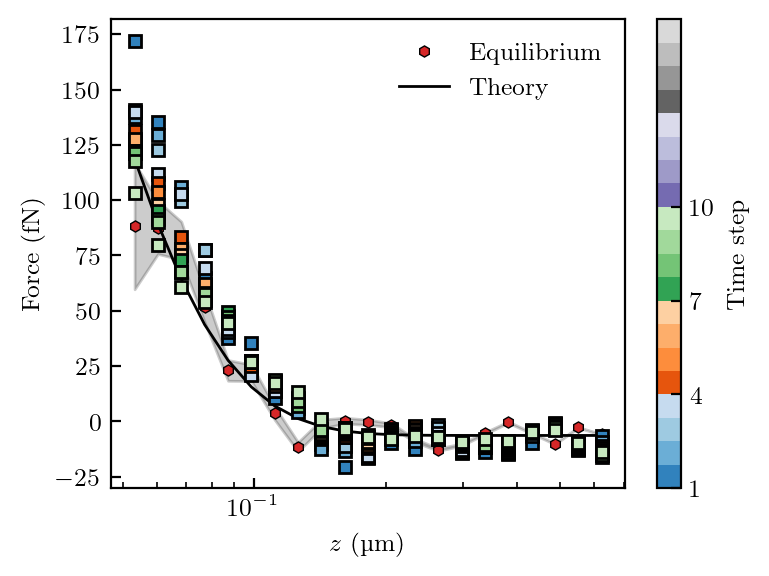

In [144]:
fig, ax1 = plt.subplots(1, 1, figsize=(10/2.54, 7.5/2.54))

cmap = 'tab20c'
vmin = tau[0] #- timestep_diffusion
vmax = tau[-1] #- timestep_diffusion

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'h', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
for i in range(len(tau)):
    ax1.plot(bins_left * 1e6, F_tot_tau[:,i] * 1e15, 's', markersize=4, c=mpl.cm.get_cmap(cmap)(i))
ax1.fill_between(
    bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc)*1e15, 
    alpha = 0.2, color ="k", 
    # label = "Thermal noise"
)

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax1, ticks=tau[::3], label='Time step')

ax1.legend(frameon=False)
ax1.set(
    xlabel="$z$ (µm)", 
    ylabel="Force (fN)", 
    xscale='log', 
    yscale='linear', 
)

plt.tight_layout()
plt.show()

In [145]:
# fig.savefig('F_tot_tau_PS3um_in_water_PDMS_34_ordre_Ronceray_4.pdf')

In [146]:
x_pdf_z

array([5.32710545e-08, 6.02411555e-08, 6.81232397e-08, 7.70366330e-08,
       8.71162741e-08, 9.85147575e-08, 1.11404643e-07, 1.25981070e-07,
       1.42464708e-07, 1.61105101e-07, 1.82184444e-07, 2.06021854e-07,
       2.32978203e-07, 2.63461579e-07, 2.97933467e-07, 3.36915731e-07,
       3.80998521e-07, 4.30849198e-07, 4.87222447e-07, 5.50971695e-07,
       6.23062034e-07, 7.04584829e-07, 7.96774245e-07, 9.01025926e-07,
       1.01891812e-06, 1.15223559e-06, 1.30299661e-06, 1.47348353e-06,
       1.66627733e-06, 1.88429669e-06])

In [147]:
# exp_decrease_F_tot = lambda x, xc: mean_F_tot_tau[5]*np.exp(-(x - ttt[5])/xc)
# popt_F_tot_tau, _ = curve_fit(exp_decrease_F_tot, ttt[(ttt>0.05) & (ttt<0.15)], mean_F_tot_tau[(ttt>0.05) & (ttt<0.15)])
# print(popt_F_tot_tau)
i = 8
tmin, tmax = 0, 0.2 # s
tau0_nc = ttt[i]
F_nc_0 = mean_F_nc_tau[i]
exp_decrease_F_nc = lambda x, xc1: F_nc_0 * (np.exp(-(x - tau0_nc)/xc1))
# exp_decrease_F_nc = lambda x, xc1: F_nc_0 * (xc1 / (x - tau0_nc)) ** 1
popt_F_nc_tau, _ = curve_fit(exp_decrease_F_nc, ttt[(ttt>tmin) & (ttt<tmax)], mean_F_nc_tau[(ttt>tmin) & (ttt<tmax)])
print(popt_F_nc_tau)
tau_c_F_nc = popt_F_nc_tau[0]

[0.09010889]


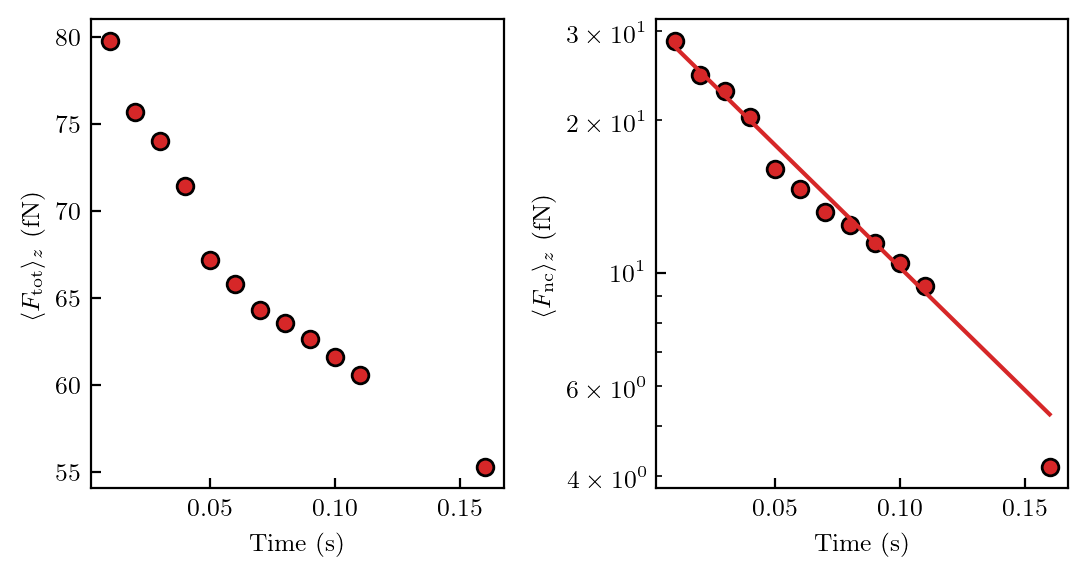

In [148]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14/2.54, 7.5/2.54))

ax1.plot(ttt, mean_F_tot_tau * 1e15, 'o', c='tab:red')
# ax1.plot(ttt, exp_decrease_F_tot(ttt, *popt_F_tot_tau) * 1e15, '-', c='tab:red')
ax2.plot(ttt, mean_F_nc_tau * 1e15, 'o', c='tab:red')
ax2.plot(ttt, exp_decrease_F_nc(ttt, *popt_F_nc_tau) * 1e15, '-', c='tab:red')

ax1.set(
    xscale='linear', 
    yscale='linear',
    xlabel='Time (s)', 
    ylabel=r"$\langle F_\mathrm{tot} \rangle_z$ (fN)", 
)
ax2.set(
    xscale='linear', 
    yscale='log',
    xlabel='Time (s)', 
    ylabel=r"$\langle F_\mathrm{nc} \rangle_z$ (fN)", 
)

plt.tight_layout()
plt.show()

### Extrapolation of the force to tau = 0

In [149]:
# A REFAIRE 
# CORRIGER F_NC CALCULÉE À TAU POUR AVOIR F_NC À TAU=0 

In [150]:
# tautau = 3
# tt = tautau / fps
# bins_left, F_tot, err_F_tot, y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=0.8e-6, tau=tautau, return_all=True)
# F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)

# F_nc_corrected = F_nc * np.exp(tt/tau_c_F_nc)

In [151]:
# Force Corrected 
tautau = 8
tt = tautau / fps
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=tautau, return_all=True)
F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
F_nc_corrected = F_nc * np.exp(tt/tau_c_F_nc)

# Smallest Time Step
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=timestep_diffusion, return_all=True)
F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
# Thermal noise 
tau_boxes = err_vz * 1/fps
F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z_exp * r / tau_boxes)

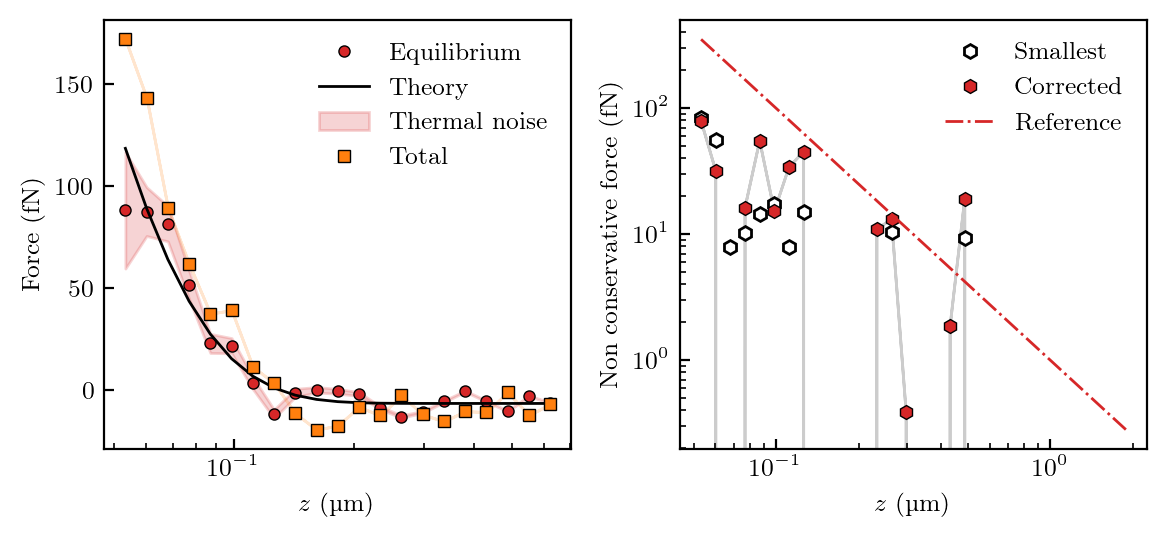

Gauche = non corrigé et smallest time step. Droite = corrigé


In [152]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15/2.54, 7/2.54))

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'o', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
ax1.fill_between(
    bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc)*1e15, 
    alpha = 0.2, color ="tab:red", label = "Thermal noise"
)
ax1.plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
ax1.fill_between(
    bins_left * 1e6, (F_tot - err_F_tot)*1e15, (F_tot + err_F_tot)*1e15, 
    alpha = 0.2, color ="tab:orange", 
    # label = "Thermal noise",
)
ax1.legend(frameon=False)
ax1.set(
    xlabel='$z$ (µm)', 
    ylabel='Force (fN)', 
    xscale='log', 
    yscale='linear', 
)

ax2.plot(bins_left * 1e6, F_nc * 1e15, 'h', markerfacecolor='w', markersize=5, markeredgecolor='k', markeredgewidth=1, label='Smallest')
ax2.plot(bins_left * 1e6, F_nc_corrected * 1e15, 'h', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=0.5, label='Corrected')
ax2.plot(x_reference * 1e6, F_nc_ref * 1e15, ls='-.', linewidth=1, c='tab:red', label="Reference")
# ax2.fill_between(
#     bins_left * 1e6, (np.zeros(len(bins_left)) - 1 * F_err_th)*1e15, (np.zeros(len(bins_left)) + 1 * F_err_th)*1e15, 
#     alpha = 0.2, color ="k", label = "Thermal noise"
# )
ax2.fill_between(
    bins_left * 1e6, (F_nc_corrected - err_F_tot) * 1e15, (F_nc_corrected + err_F_tot) * 1e15, 
    alpha = 0.2, color ="k", 
    # label = "Thermal noise"
)
ax2.legend(frameon=False)
ax2.set(
    xlabel='$z$ (µm)', 
    ylabel='Non conservative force (fN)', 
    xscale='log', 
    yscale='log', 
)

plt.tight_layout()
plt.show()

print('Gauche = non corrigé et smallest time step. Droite = corrigé')

In [153]:
# fig.savefig('essai_ansatz_force_tau_AR1000_water_EG30_{}.pdf'.format(filename[:-4]))

In [154]:
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=timestep_diffusion, return_all=True)
F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
# Thermal noise 
tau_boxes = err_vz * 1/fps
F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z_exp * r / tau_boxes)

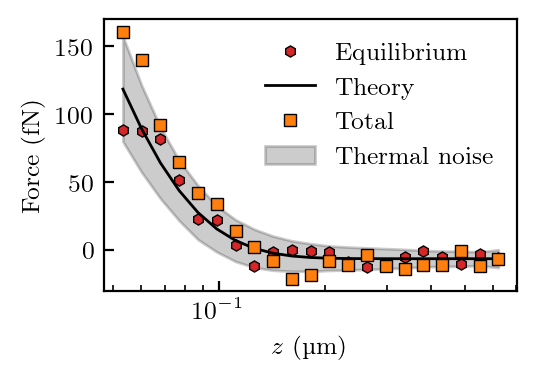

In [155]:
fig, ax1 = plt.subplots(1, 1, figsize=(7/2.54, 5/2.54))

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'h', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
ax1.plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
ax1.fill_between(
    bins_left * 1e6, (F_eq_theoretical - F_err_th)*1e15, (F_eq_theoretical + F_err_th)*1e15, 
    alpha = 0.2, color ="k", label = "Thermal noise"
)
ax1.legend(frameon=False)
ax1.set_xlabel("$z$ (µm)")
ax1.set_ylabel("Force (fN)")
ax1.set_xscale("log")
ax1.set_yscale("linear")

plt.tight_layout()
plt.show()

In [156]:
# fig.savefig('./fig_raw_force_traj_2_20231114.pdf')

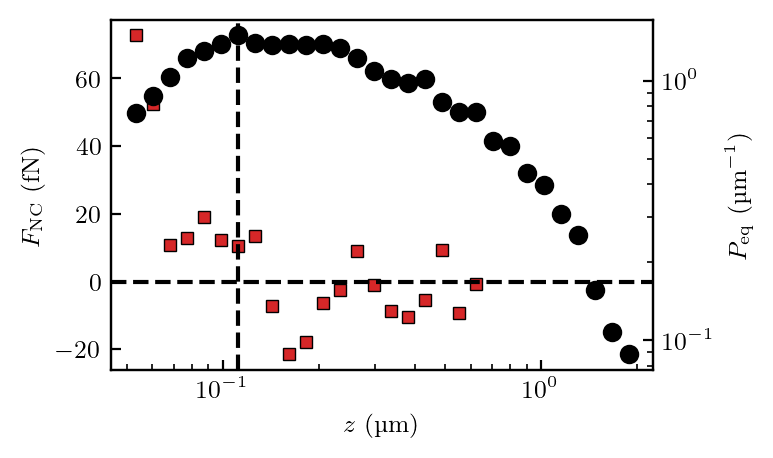

In [157]:
# Non-conservative force

fig, ax1 = plt.subplots(1, 1, figsize=(10/2.54, 6/2.54))

ax1.plot(bins_left * 1e6, F_nc * 1e15, 's', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5)
# ax1.fill_between(
#     bins_left * 1e6, (0 - F_err_th)*1e15, (0 + F_err_th)*1e15, 
#     alpha = 0.2, color ="k", label = "Thermal noise"
# )
ax1.axhline(y=0, ls='--', c='k')

ax1.set(
    xlabel='$z$ (µm)', 
    ylabel='$F_\mathrm{NC}$ (fN)', 
    xscale='log', 
    yscale='linear', 
)

ax2 = ax1.twinx()

ax2.plot(x_pdf_z * 1e6, y_pdf_z * 1e-6, 'o', c='k')
z_Pmax = x_pdf_z[y_pdf_z == np.max(y_pdf_z)]
ax2.axvline(x=z_Pmax * 1e6, ls='--', c='k')

ax2.set(
    yscale='log', 
    ylabel=r'$P_\mathrm{eq}$ (µm$^{-1}$)', 
)

plt.tight_layout()
plt.show()

In [158]:
# fig.savefig('fig_pres_Fnc_Peq_{0}_{1}.pdf'.format(date, filename[:-4]))

# Multifitting Time

## Functions For the Multifit (Only Related to Equilibrium)

In [159]:
# (Semi) Theoretical PDF and Force

def _P_eq(z, B, lD, lB):
    return np.exp(-B * np.exp(-z / lD) - z / lB)

def P_eq(z, z0, B, lD, lB, normalize=True):
    z = z - z0
    if type(z) == float:
        if z < 0:
            res = 0
        return _P_eq(z, B, lD, lB)
    res = _P_eq(z, B, lD, lB)
    res[z < 0] = 0
    if normalize:
        res = res / np.trapezoid(res, z) # Ok because it is a change of variable
    return res

def F_eq(z, z0, B, lD, lB):
    z = np.copy(z)
    z = z - z0  
    res = 4e-21 * (B / lD * np.exp(-z / lD) - 1 / lB)
    return res

In [160]:
# Displacement Probability at Long Time

def _P_dz_long(dz, z, B, lD, lB, normalize=False):
    res = P_eq(z, 0, B, lD, lB, normalize=normalize) 
    res = res * P_eq(z+dz, 0, B, lD, lB, normalize=normalize)
    return res

def P_dz_long(dz, B, lD, lB):
    z = np.linspace(1e-9, 20e-6, 2000)
    if type(dz) == float: # For one single dz
        integrande = _P_dz_long(dz, z, B, lD, lB)
        res = np.trapezoid(integrande, z)  
    else: # For the whole probability distribution
        res = np.array([np.trapezoid(_P_dz_long(elem, z, B, lD, lB), z) for elem in dz])
        res = res / np.trapezoid(res, dz) 
    return res

In [161]:
# Confined Diffusion: Plateau MSD

def plateau(B, lD, lB):
    dz = np.linspace(-10e-6, 10e-6, 1000)
    integrande = dz**2 * P_dz_long(dz, B, lD, lB)
    res = np.trapezoid(integrande, dz)
    return res

In [162]:
# Fourth-cumulant (perpendicular motion) at long times

def K4z_long(B, lD, lB):
    dz = np.linspace(-10e-6, 10e-6, 1000)
    
    integrande = dz**4 * P_dz_long(dz, B, lD, lB)
    res = np.trapezoid(integrande, dz)
    
    integrande = dz**2 * P_dz_long(dz, B, lD, lB)
    res -= 3 * np.trapezoid(integrande, dz) ** 2
    # res -= 3 * plateau(B, lD, lB) ** 2
    
    return res

## Compute Late Time Observables and Test Those Functions

In [163]:
lB_exp

np.float64(6.270407878970369e-07)

In [164]:
lB_theory

6.067987024525671e-07

In [165]:
popt_F_eq

[5.2, 2.6e-08, 5e-09]

In [166]:
z0 = 5e-9
B = 5.2
lD = 26e-9
lB = 620e-9
b = 20e-9

In [167]:
# Experimental Data: Displacement Probability at Long Times

t_start = 60
t_end = 250
I = np.arange(t_start * fps, t_end * fps, 1)
bins = 20

limit_dz = 3 * np.sqrt(plateau_MSD_perp)

hists = np.zeros((bins, len(I)))
bins_centers = np.zeros((bins, len(I)))

for n, i in enumerate(I):
    i = int(i)
    displacement = z_dedrift[0:-i] - z_dedrift[i:] # SI
    hist, bins_center = co.pdf(displacement[np.abs(displacement) <= limit_dz], bins=bins)
    # hist, bins_center = co.pdf(displacement[np.abs(displacement) <= 3e-6], bins=bins)
    #hist, bins_center = pdf(displacement[~np.isnan(displacement[np.abs(displacement)])], bins=bins)
    hists[:, n] = hist
    bins_centers[:, n] = bins_center

proba_deltaz_long = np.mean(hists, axis=1)
bins_centers_long = np.mean(bins_centers, axis=1)
err_proba_deltaz_long = np.std(hists, axis=1)
err_bins_centers_long = np.std(bins_centers, axis=1)

# Extra Step to Ensure PDF Normalization
proba_deltaz_long = proba_deltaz_long / np.trapezoid(proba_deltaz_long, bins_centers_long)
err_proba_deltaz_long = err_proba_deltaz_long / np.trapezoid(proba_deltaz_long, bins_centers_long)

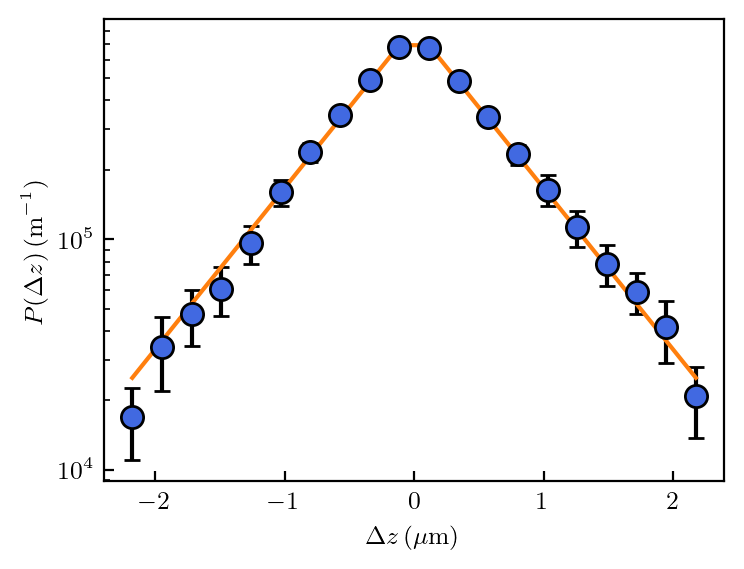

In [168]:
# Theoretical approximation
proba_deltaz_long_theory = P_dz_long(bins_centers_long, B, lD, lB)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.errorbar(bins_centers_long * 1e6, proba_deltaz_long, yerr=err_proba_deltaz_long, xerr=err_bins_centers_long,
            ls='', marker='o', markersize=8, markerfacecolor='royalblue', markeredgewidth=1, markeredgecolor='k', 
            ecolor='k', capsize=3,
           )
ax.plot(bins_centers_long * 1e6, proba_deltaz_long_theory, '-')

ax.set_yscale("log")

ax.set_xlabel("$\Delta z \, \mathrm{(\mu m)}$")
ax.set_ylabel("$P(\Delta z) \, \mathrm{(m^{-1})}$")

plt.show()

In [169]:
print("Verif Normalization")
print('Integral of P(\Delta z) = {}'.format(np.trapezoid(proba_deltaz_long_theory[:], bins_centers_long[:])))

Verif Normalization
Integral of P(\Delta z) = 0.9999999999999998


Theoretical saturation value = 7.71e-13 m^2/s


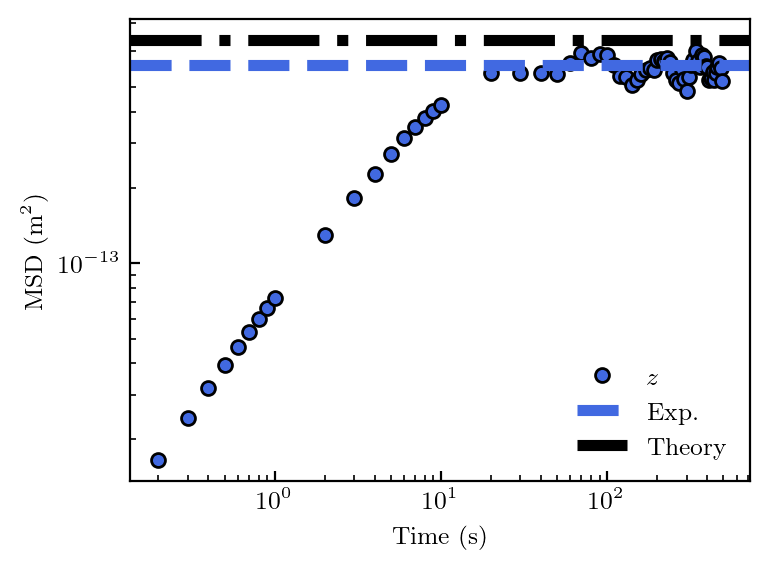

In [170]:
# Experimental Data: Plateau of MSDz

plateau_MSDz_exp = np.mean(MSD_z[(delta_time_MSD > t_start) & (delta_time_MSD < t_end)])
plateau_MSDz_th = plateau(B, lD, lB)
print("Theoretical saturation value = {0:.2e} m^2/s".format(plateau_MSDz_th))

# Figure
fig, ax = plt.subplots(1, 1, figsize = (4, 3))

ax.plot(
    delta_time_MSD[delta_time_MSD > 0.1], MSD_z[delta_time_MSD > 0.1], 
    'o', markerfacecolor='royalblue', 
    markersize=5, markeredgecolor='k', markeredgewidth=1, 
    label="$z$", 
)
ax.axhline(y=plateau_MSDz_exp, ls='--', color='royalblue', linewidth=4, label="Exp.")
ax.axhline(y=plateau_MSDz_th, ls='-.', color='k', linewidth=4, label="Theory")

ax.legend(frameon=False)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD $\mathrm{(m^2)}$")

plt.show()

## Functions for the Multifit (Related to Diffusion)

<sup><ins>Rk:</ins> The hypothesis of noise level on the diffusion may be true. Indeed, the noise level on the z-position measured on the MSD of z (see beginning of this notebook) is not negligible. Typically, Maxime found a noise level in the nanometer range while found a noise levels close to 10 nm. Such a noise level corresponds to a $0.05 \, D_0$ noise level on the diffusion constants and on the diffusion profiles. A possibility to investigate the noise level hypothesis is to set the offset on the diffusion profiles to the offset on the equilibrium probability density function (i.e. to suppose a non-slip boundary condition) and then to fit a noise level instead of the offset. However, since the noise level on the z-position is already measured from the MSD of z, I use the corresponding "diffusion noise level" on the diffusion theoretical expressions. Then, the offset is still the fitted parameter.</sup>

In [171]:
print(' /!\ Check noise levels: if too high, maybe there was an error before!')
print('Para')
print('{0:.2e} D0'.format(noiselevel_D_para_from_MSD))
print('Perp')
print('{0:.2e} D0'.format(noiselevel_D_perp_from_MSD))

 /!\ Check noise levels: if too high, maybe there was an error before!
Para
2.45e-11 D0
Perp
1.67e-11 D0


In [172]:
# Define the theoretical functions of the diffusion profiles 

# The default value of the noise levels are the one obtained from the MSD.
nl_D_para = noiselevel_D_para_from_MSD # Normalized by D0
nl_D_perp = noiselevel_D_perp_from_MSD

# nl_D_para = 0
# nl_D_perp = 0

# Normalized parallel diffusion profile, from Faxen, with a noise level
def Dpara_z(z, b, z0=0, nl=0):
    z = z - z0 + b # Sign + according to usual convention in fluid mechanics.
    xi = r / (z + r)
    res = 1 - 9/16 * xi + 1/8 * xi ** 3 - 45/256 * xi ** 4 - 1/16 * xi ** 5
    res += nl
    return res

# Normalized perpendicular diffusion profile, using Padé's approximation, with a noise level
def Dperp_z(z, b, z0=0, nl=0):
    z = z - z0 + b
    res = (6 * z ** 2 + 2 * r * z) / (6 * z ** 2 + 9 * r * z + 2 * r ** 2)
    res += nl
    return res

In [173]:
# Displacement probability, at short times

z_to_integrate = np.linspace(1e-9, 15e-6, 1000)

def c_P_Dz(B, lD, lB, b):
    zz = np.copy(z_to_integrate)
    P_D = Dperp_z(zz, b) * D0 * P_eq(zz, 0, B, lD, lB)
    return Dperp_z(zz, b) * D0, P_D / np.trapezoid(P_D, zz)

# def _P_dz_short(dz, dt, B, lD, lB, b): # un dz
#     D_z, P_D = c_P_Dz(B, lD, lB, b)
#     P = np.trapz(P_D / np.sqrt(4 * np.pi * D_z * dt) * np.exp(-(dz ** 2) / (4 * D_z * dt)), D_z)
#     return P

def _P_dz_short(dz, dt, B, lD, lB, b): # un dz
    D_z, P_D = c_P_Dz(B, lD, lB, b)
    P_D[D_z <= 0] = 0
    D_z[D_z <= 0] = np.abs(D_z[D_z <= 0])
    # for i in range(len(P_D)):
    #     if D_z[i] == 0:
    #         P_D[i] = 0
    #         D_z[i] = D0
    #     if D_z[i] < 0:
    #         D_z[i] = np.abs(D_z[i])
    P = np.trapezoid(P_D / np.sqrt(4 * np.pi * D_z * dt) * np.exp(-(dz ** 2) / (4 * D_z * dt)), D_z)
    return P

def P_dz_short(dz, dt, B, lD, lB, b=0):
    P = [_P_dz_short(elem, dt, B, lD, lB, b) for elem in dz]
    P = np.array(P)
    P = P / np.trapezoid(P, dz)
    return P

def c_P_Dx(B, lD, lB, b):
    zz = np.copy(z_to_integrate)
    P_D = Dpara_z(zz, b) * D0 * P_eq(zz, 0, B, lD, lB)
    return Dpara_z(zz, b) * D0, P_D / np.trapezoid(P_D, zz)

def _P_dx_short(dx, dt, B, lD, lB, b):
    D_x, P_D = c_P_Dx(B, lD, lB, b)
    P = np.trapezoid(P_D / np.sqrt(4 * np.pi * D_x * dt) * np.exp(-(dx ** 2) / (4 * D_x * dt)), D_x)
    return P

def P_dx_short(dx, dt, B, lD, lB, b=0):
    P = [_P_dx_short(elem, dt, B, lD, lB, b) for elem in dx]
    P = np.array(P)
    P = P / np.trapezoid(P, dx)
    return P

def gaussian(x, a):
    return np.exp(- a * x ** 2)

In [174]:
# Fourth-cumulant (parallel motion) at short times

def K4x_short(dt, B, lD, lB, b=0, want_more=False):
    zz = np.copy(z_to_integrate)
    mean_D = np.trapezoid(Dpara_z(zz, b) * P_eq(zz, 0, B, lD, lB), zz)
    mean_D_squared = np.trapezoid(Dpara_z(zz, b)**2 * P_eq(zz, 0, B, lD, lB), zz)

    coef = 12 * (mean_D_squared  - mean_D**2) * D0 ** 2
    res = coef * dt**2
    
    if not(want_more):
        return res
    else:
        return res, mean_D, mean_D_squared, coef

In [175]:
# Fourth-cumulant (perpendicular motion) at short times

def K4z_short(dt, B, lD, lB, b=0, want_more=False):
    zz = np.copy(z_to_integrate)
    mean_D = np.trapezoid(Dperp_z(zz, b) * P_eq(zz, 0, B, lD, lB), zz)
    mean_D_squared = np.trapezoid(Dperp_z(zz, b)**2 * P_eq(zz, 0, B, lD, lB), zz)

    coef = 12 * (mean_D_squared  - mean_D**2) * D0 ** 2
    res = coef * dt**2
    
    if not(want_more):
        return res
    else:
        return res, mean_D, mean_D_squared, coef

In [176]:
# To store data of the displacement probabilities at short time
to_store = {}

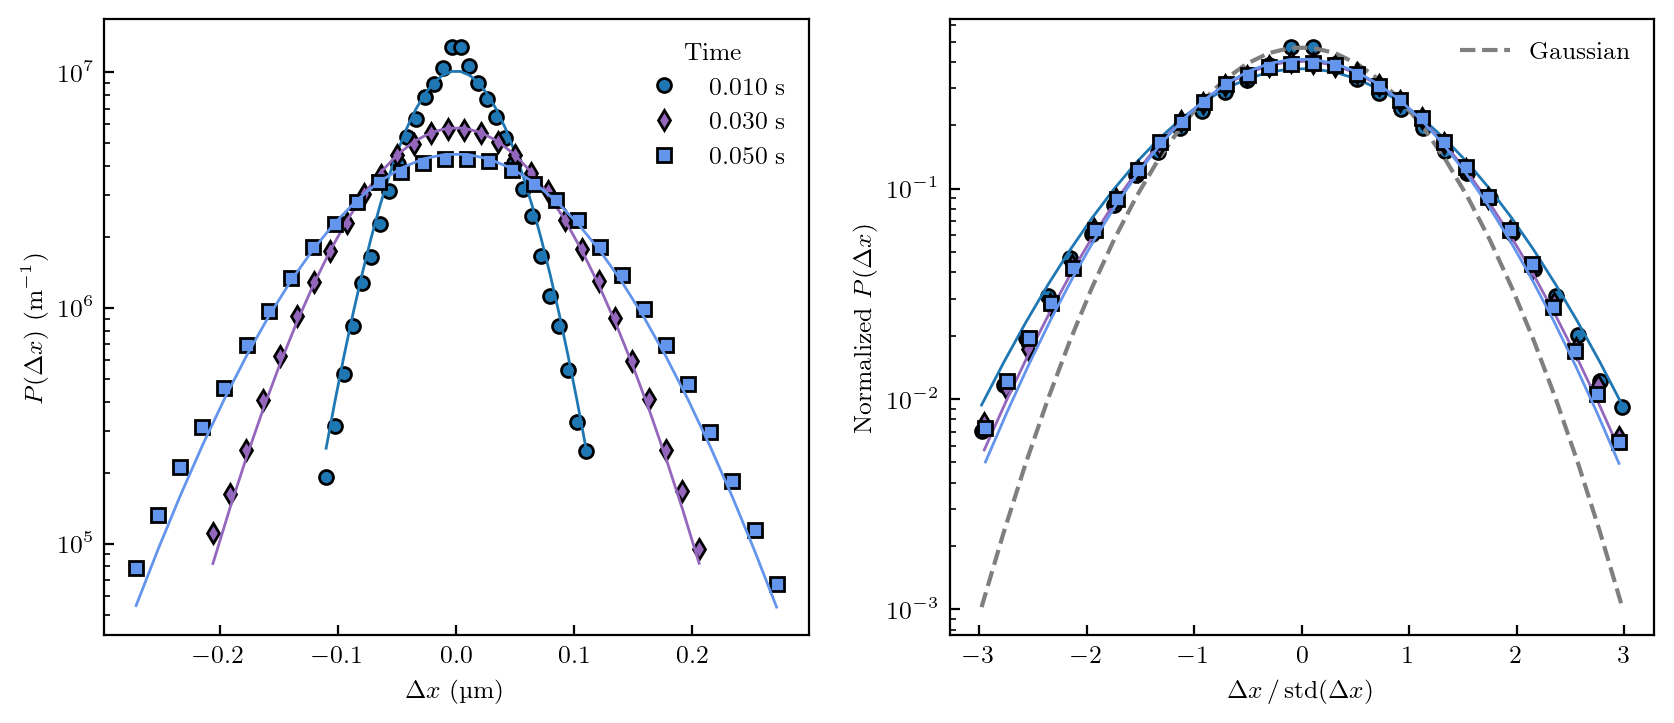

In [177]:
# Experimental data: probability of x-displacement at short times

timesteps_dx = [1, 3, 5]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes[0], axes[1]
colors = ['tab:blue', 'tab:purple', 'cornflowerblue', 'indigo', 'lightsteelblue']
markers = ['o', 'd', 's', 'h', 'D']

for n, i in enumerate(timesteps_dx):
    dx = x[i:] - x[:-i]
    
    cutoff = 3 * np.std(dx)
    index = np.abs(dx) < cutoff
    dx = dx[index]
    
    hist, bins_center = co.pdf(dx[~np.isnan(dx)], bins=30)
    hist = hist / np.trapezoid(hist, bins_center)
    bins_center_norm = bins_center / np.std(dx)
    hist_norm = hist * np.std(dx) #/ np.trapezoid(hist, bins_center / np.std(dx))
    hist_theory = P_dx_short(bins_center, time[i], B, lD, lB, b)
    to_store["proba_dx_short_t_{}".format(i)] = [np.copy(bins_center), np.copy(hist)]
    to_store["normalized_proba_dx_short_t_{}".format(i)] = [np.copy(bins_center_norm), np.copy(hist_norm)]
    ax1.plot(bins_center * 1e6, hist, 
             ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
             label="{:.3f} s".format(time[i]), 
            )
    ax1.plot(bins_center * 1e6, hist_theory, 
             ls='-', linewidth=1, color=colors[n], 
            )
    ax2.plot(bins_center_norm, hist_norm, 
             ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
            )

    hist_norm_theory = hist_theory / np.trapezoid(hist_theory, bins_center_norm)
    popt_gauss, pcov_gauss = curve_fit(gaussian, bins_center_norm, hist_norm / np.max(hist_norm), p0=[1])
    gaussian_x = gaussian(bins_center_norm, *popt_gauss) * np.max(hist_norm)
    to_store["gaussian_x"] = [np.copy(bins_center_norm), np.copy(gaussian_x)]
    ax2.plot(bins_center_norm, hist_norm_theory, 
             ls='-', linewidth=1, color=colors[n], 
             # label="Short time theory", 
            )
    if n == 0:
        ax2.plot(bins_center_norm, gaussian_x,  ls='--', color='tab:gray', label="Gaussian", )
        
ax1.legend(title="Time", frameon=False)
ax1.set_yscale("log")
ax2.legend(frameon=False)
ax2.set_yscale("log")
# ax2.set_ylim([1e-5, 1])

ax1.set_xlabel("$\Delta x$ (µm)")
ax1.set_ylabel("$P(\Delta x)$ (m$^{-1}$)")
ax2.set_xlabel("$\Delta x \, / \, \mathrm{std}(\Delta x)$")
ax2.set_ylabel("Normalized $P(\Delta x)$")

plt.show()

In [178]:
b = 100e-9

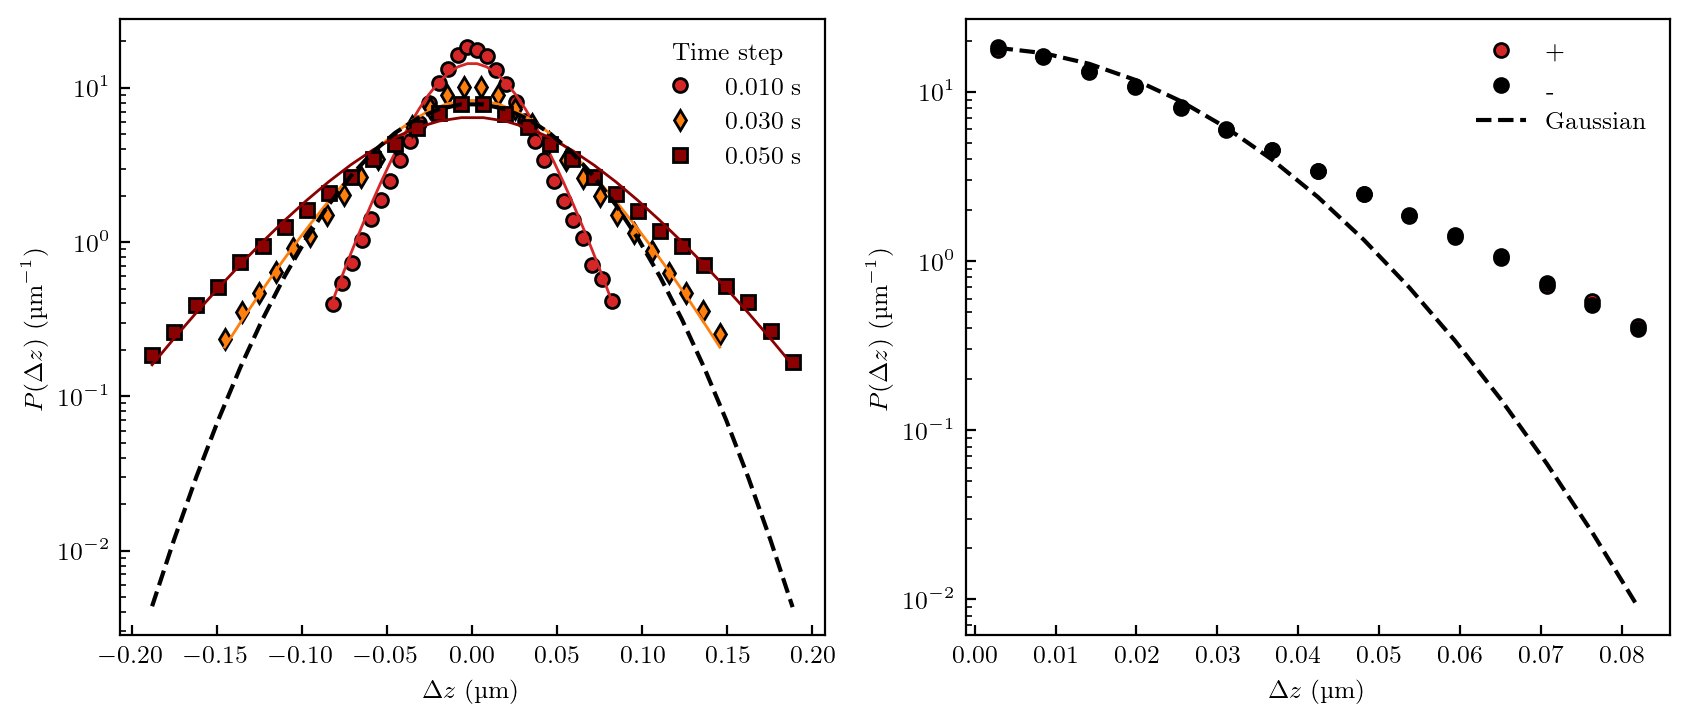

In [179]:
# Experimental data: probability of z-displacement at short times

timesteps_dz = [1, 3, 5]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes[0], axes[1]
colors = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']
markers = ['o', 'd', 's', 'h', 'D']

for n, i in enumerate(timesteps_dz):
    # Compute all the displacements over i timesteps 
    dz = z_dedrift[i:] - z_dedrift[:-i]
    # Select certain distances
    # dz = dz[ (z_dedrift[:-i] > 0.03e-6) & (z_dedrift[:-i] <= 0.08e-6) ]
    # Keep only the ones smaller than a given cut-off
    cutoff = 3 * np.std(dz)
    index = np.abs(dz) < cutoff
    dz = dz[index]
    # Compute the distributions (and normalized distributions)
    hist, bins_center = co.pdf(dz[~np.isnan(dz)], bins=30)
    hist = hist / np.trapezoid(hist, bins_center)
    # Normalize with standard deviations
    bins_center_norm = bins_center / np.std(dz)
    hist_norm = hist / np.trapezoid(hist, bins_center / np.std(dz))
    hist_theory = P_dz_short(bins_center, time[i], B, lD, lB, b)
    to_store["proba_dz_short_t_{}".format(i)] = [bins_center, hist]
    to_store["normalized_proba_dz_short_t_{}".format(i)] = [bins_center / np.std(dz), hist / np.trapezoid(hist, bins_center / np.std(dz))]
    # Plot
    ax1.plot(bins_center * 1e6, hist * 1e-6, 
             ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
             label="{:.3f} s".format(time[i]), 
            )
    ax1.plot(bins_center * 1e6, hist_theory * 1e-6, 
             ls='-', linewidth=1, color=colors[n], 
            )
    # To check if the distributions are symmetric 
    if n == 0:
        ax2.plot(bins_center[bins_center>=0] * 1e6, hist[bins_center>=0] * 1e-6, 
                 ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
                 label='+', 
                )
        ax2.plot(- bins_center[bins_center<0] * 1e6, hist[bins_center<0] * 1e-6, 
                 ls='', marker=markers[n], markersize=5, markerfacecolor='k', markeredgewidth=1, markeredgecolor='k', 
                 label='-', 
                )
        popt, pcov = curve_fit(gaussian, bins_center, hist/np.max(hist), p0=[1e12])
        gauss = gaussian(bins_center, *popt) * np.max(hist)
        ax2.plot(bins_center[bins_center > 0] * 1e6, gauss[bins_center > 0] * 1e-6, '--k', label='Gaussian')
    
    if n == len(timesteps_dz) - 1:
        hist_norm_theory = hist_theory / np.trapezoid(hist_theory, bins_center/np.std(dz))
        popt_gauss, pcov_gauss = curve_fit(gaussian, bins_center/np.std(dz), hist_norm / np.max(hist_norm), p0=[1])
        gaussian_z = gaussian(bins_center_norm, *popt_gauss) * np.max(hist_norm)
        to_store["gaussian_z"] = [np.copy(bins_center_norm), np.copy(gaussian_z)]
        # ax2.plot(bins_center / np.std(dz), hist_norm_theory, 
        #          ls='-', linewidth=1, color='tab:red', 
        #          label="Short time theory (arbitrary)", 
        #         )
        # ax2.plot(bins_center/np.std(dz), gaussian_z, ls='--', color='tab:gray', label="Gaussian")
        
        popt, pcov = curve_fit(gaussian, bins_center, hist/np.max(hist), p0=[1e12])
        gauss = gaussian(bins_center, *popt) * np.max(hist)
        ax1.plot(bins_center * 1e6, gauss * 1e-6, '--k')
        
ax1.legend(title="Time step", frameon=False)
ax1.set(
    yscale='log', 
    # xlim=[-0.1, 4.5],
    # ylim=[1e-5, 1],
    xlabel="$\Delta z$ (µm)", 
    ylabel="$P(\Delta z)$ (µm$^{-1}$)", 
)
ax2.legend(frameon=False)
ax2.set(
    yscale='log', 
    # xlim=[-0.1, 4.5],
    # ylim=[1e-5, 1],
    xlabel="$\Delta z$ (µm)", 
    ylabel="$P(\Delta z)$ (µm$^{-1}$)", 
)

plt.show()

In [180]:
# # Experimental data: probability of z-displacement at short times
# # Restricted to a certain gap range.

# # Keep displacements only in between the lower and upper boundaries
# lower_z = 0.1e-6
# upper_z = 0.2e-6

# tau_watched = 0

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# ax1, ax2 = axes[0], axes[1]
# colors = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']
# markers = ['o', 'd', 's', 'h', 'D']

# for n, i in enumerate(timesteps_dz):
#     # Compute all the displacements over i timesteps 
#     dz = z_dedrift[i:] - z_dedrift[:-i]
#     # Select certain distances
#     dz = dz[ (z_dedrift[:-i] > lower_z) & (z_dedrift[:-i] <= upper_z) ]
#     # Keep only the ones smaller than a given cut-off
#     cutoff = 3 * np.std(dz)
#     index = np.abs(dz) < cutoff
#     dz = dz[index]
#     # Compute the distributions (and normalized distributions)
#     hist, bins_center = co.pdf(dz[~np.isnan(dz)], bins=20)
#     hist = hist / np.trapezoid(hist, bins_center)
#     # Normalize with standard deviations
#     bins_center_norm = bins_center / np.std(dz)
#     hist_norm = hist / np.trapezoid(hist, bins_center / np.std(dz))
#     # Plot
#     ax1.plot(bins_center * 1e6, hist * 1e-6, 
#              ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
#              label="{:.3f} s".format(time[i]), 
#             )
#     # Compare negative and positive displacements
#     # To check if the distributions are symmetric 
#     if n == tau_watched:
#         # Positive displacements
#         ax2.plot(bins_center[bins_center>=0] * 1e6, hist[bins_center>=0] * 1e-6, 
#                  ls='', marker=markers[n], markersize=5, markerfacecolor=colors[n], markeredgewidth=1, markeredgecolor='k', 
#                  label='+', 
#                 )
#         # Negative displacements
#         ax2.plot(- bins_center[bins_center<0] * 1e6, hist[bins_center<0] * 1e-6, 
#                  ls='', marker=markers[n], markersize=5, markerfacecolor='k', markeredgewidth=1, markeredgecolor='k', 
#                  label='-', 
#                 )
        
# ax1.legend(title="Time step", frameon=False)
# ax1.set(
#     yscale='log', 
#     # xlim=[-0.1, 4.5],
#     # ylim=[1e-5, 1],
#     xlabel="$\Delta z$ (µm)", 
#     ylabel="$P(\Delta z)$ (µm$^{-1}$)", 
# )
# ax2.legend(frameon=False, title="Time step = {} s".format(timesteps_dz[tau_watched] / fps))
# ax2.set(
#     yscale='log', 
#     # xlim=[-0.1, 4.5],
#     # ylim=[1e-5, 1],
#     xlabel="$\Delta z$ (µm)", 
#     ylabel="$P(\Delta z)$ (µm$^{-1}$)", 
# )

# plt.show()

In [181]:
# Compute the fourth-order cumulant

xbis = np.copy(x)
ybis = np.copy(y)
zbis = np.copy(z_dedrift)

# Difference in time steps
delta_frame_nb = np.concatenate(
    (np.arange(1,10, 1), 
     np.arange(10,100, 10), 
     np.arange(100,1000, 100), 
     np.arange(1000,15000, 1000))
)

# To get the corresponding dt, use the array time
# time[delta_frame_nb]
dtime_C4 = time[delta_frame_nb]

# Fourth-order cumulant (experimental)
C4_x, std_C4_x = co.cumulant4(xbis, delta_frame_nb, return_std=True) # In m^4
C4_y, std_C4_y = co.cumulant4(ybis, delta_frame_nb, return_std=True)
C4_z, std_C4_z = co.cumulant4(zbis, delta_frame_nb, return_std=True)

del xbis, ybis, zbis

In [182]:
C4_perp = np.copy(C4_z)


# Remove outliers (due to a lack of statistics), only for the transverse motion

# x_C4_para = np.zeros(len(C4_x))
C4_para = np.zeros(len(C4_x))
err_C4_para = np.zeros(len(C4_x))

for i, cx in enumerate(C4_x):
    cy = C4_y[i]
    d_frame_nb = delta_frame_nb[i]
    dt = dtime_C4[i]
    
    if cx > 0 and cy > 0:
        c = (cx + cy) / 2 
        #err = (std_C4_x[i] + std_C4_y[i]) / 2 
        err = abs(cx - cy) / 2
    elif cx > 0 and cy <= 0:
        c = cx
        #err = std_C4_x[i] / 2
        err = abs(cx - cy) / 4
    elif cx <= 0 and cy > 0:
        c = cy 
        #err = std_C4_y[i] / 2
        err = abs(cx - cy) / 4
    else:
        c = 0
        err = 0
    
    if err > c:
        c = 0 
        err = 0
    
    # x_C4_para[i] = dt
    C4_para[i] = c
    err_C4_para[i] = err


# Take into account the uncertainty on x, y and z

# The uncertainty on the position measurement leads to a noise level on the computation of the C4.
# The error on the position is estimated with the Vestergaard method = err_x
# The C4 is a sum of two terms. The noise level due to these two terms are added.
noiselevel_C4_para = 4 * (2*err_x)**4 
noiselevel_C4_perp = 4 * (2*err_z)**4

# The uncertainty can't be less than this noise level!
for i in range(len(err_C4_para)):
    if err_C4_para[i] < noiselevel_C4_para:
        err_C4_para[i] = noiselevel_C4_para

        
# Remove noise levels
C4_para = C4_para - noiselevel_C4_para * 1
C4_perp = C4_perp - noiselevel_C4_perp * 1

In [183]:
# Theory

# x_C4_para_th = np.copy(x_C4_para)
C4_para_th, mD_para, mD2_para, coef_para = K4x_short(dtime_C4, B, lD, lB, b, want_more=True)

# x_C4_perp_th = np.copy(x_C4_perp)
C4_perp_th = K4z_short(dtime_C4, B, lD, lB, b)

plateau_C4_perp = K4z_long(B, lD, lB)

# Some checking
print("Some checking:")
print("Mean D para from MSD : {0:.3f}".format(mean_D_para_from_MSD))
print("Mean D para from Peq : {0:.3f}".format(mD_para))
print()
print("Theory parallel: quadratic coef = {0:.3e} m^4/s".format(coef_para))

Some checking:
Mean D para from MSD : 0.569
Mean D para from Peq : 0.592

Theory parallel: quadratic coef = 2.895e-27 m^4/s


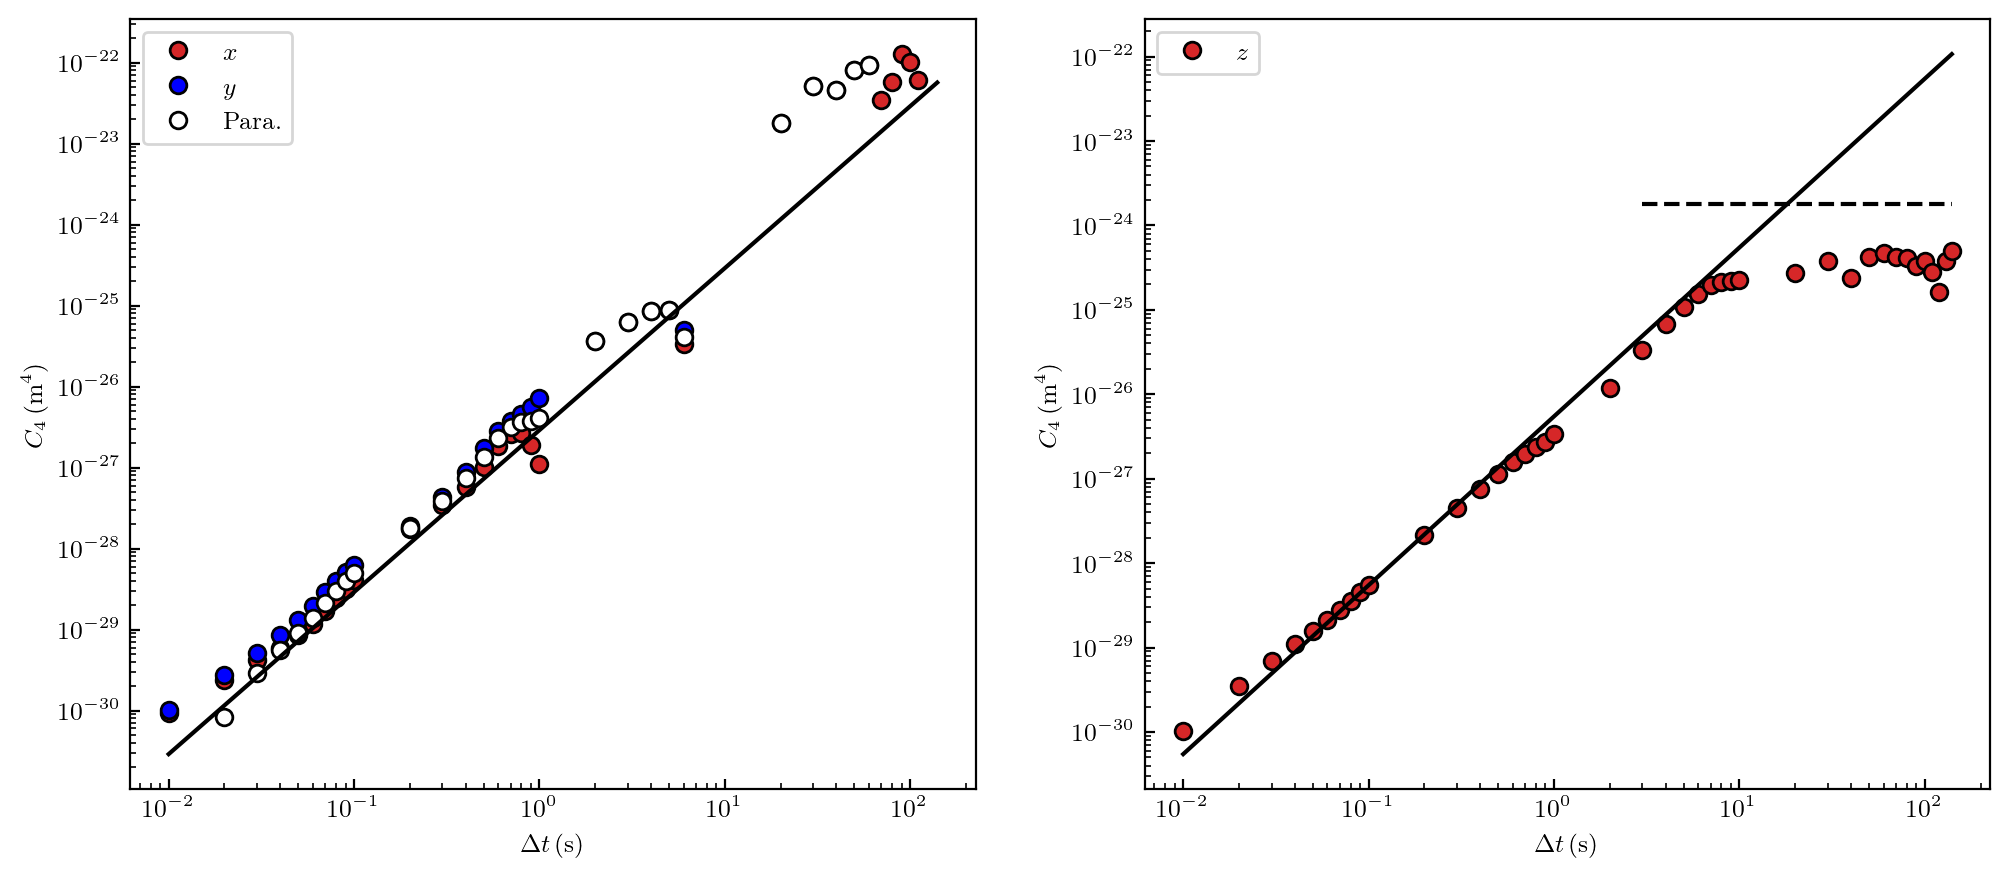

In [184]:
# Plot fourth-order cumulant 
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axx, axz = axes[0], axes[1]

axx.plot(
    dtime_C4[C4_x>0], C4_x[C4_x>0], 
    ls='', marker='o', markersize=6, markerfacecolor='tab:red', 
    markeredgewidth=1, markeredgecolor='k',  
    label='$x$', 
)
axx.plot(
    dtime_C4[C4_y>0], C4_y[C4_y>0], 
    ls='', marker='o', markersize=6, markerfacecolor='b', 
    markeredgewidth=1, markeredgecolor='k', 
    label='$y$', 
)
axx.plot(
    dtime_C4, C4_para, 
    ls='', marker='o', markersize=6, markerfacecolor='w', 
    markeredgewidth=1, markeredgecolor='k', 
    label='Para.', 
)
axx.plot(
    dtime_C4, C4_para_th, 
    ls='-', linewidth=1.5, color='k', 
)

axz.plot(
    dtime_C4, C4_perp, 
    ls='', marker='o', markersize=6, markerfacecolor='tab:red', 
    markeredgewidth=1, markeredgecolor='k', 
    label='$z$', 
)
axz.plot(
    dtime_C4, C4_perp_th, 
    ls='-', linewidth=1.5, color='k', 
)
axz.plot(
    dtime_C4[dtime_C4 > 2], plateau_C4_perp * np.ones(len(dtime_C4[dtime_C4 > 2])), 
    ls='--', linewidth=1.5, color='k', 
)


axx.legend()
axz.legend()

axx.set_xlabel("$\Delta t \, \mathrm{(s)}$")
axx.set_ylabel("$C_4 \, \mathrm{(m^4)}$")
axz.set_xlabel("$\Delta t \, \mathrm{(s)}$")
axz.set_ylabel("$C_4 \, \mathrm{(m^4)}$")

axx.set_xscale("log")
axx.set_yscale("log")
axz.set_xscale("log")
axz.set_yscale("log")

plt.show()

In [185]:
# Save data

tosave["delta_frame_nb_C4"] = np.copy(delta_frame_nb)
tosave['dtime_C4'] = np.copy(dtime_C4)

tosave["C4_para"] = np.copy(C4_para)
tosave["err_C4_para"] = np.copy(err_C4_para)
tosave["noiselevel_C4_para"] = noiselevel_C4_para

tosave["C4_perp"] = np.copy(C4_perp)

## Multifit

In [186]:
def nan_converter(chi):
    if np.isnan(chi):
        return 0.1
    else:
        return chi

def inf_converter(chi):
    if np.isinf(chi):
        return 0.1
    # elif chi > 1000:
    #     return 0
    else:
        return chi
    
def get_power(chi):
    return 1

In [187]:
def chi_lin(value, estimator): 
    return np.nanmean((value - estimator) ** 2 / estimator ** 2)

def chi_log(value, estimator):
    return np.nanmean((np.log(np.abs(value)) - np.log(np.abs(estimator))) ** 2 / np.log(np.abs(estimator)) ** 2)

def chi_linlog(value, estimator, log=False):
    if log:
        return chi_log(value, estimator)
    else:
        return chi_lin(value, estimator)

In [188]:
def minimize_Peq(B, lD, lB, z0):
    value_Peq = np.copy(y_pdf_z)
    estimator_Peq = P_eq(x_pdf_z, z0, B, lD, lB)
    # chi_Peq = np.nanmean((value_Peq - estimator_Peq) ** 2 / estimator_Peq ** 2)
    # chi_Peq = np.nanmean(np.log(np.abs(value_Peq - estimator_Peq)) ** 2 / np.log(np.abs(estimator_Peq)) ** 2)
    chi_Peq = chi_linlog(value_Peq, estimator_Peq, log=True)
    chi_Peq = inf_converter(nan_converter(chi_Peq))
    return chi_Peq

def minimize_Feq(B, lD, lB, z0):
    value_Feq = np.copy(y_F_eq)
    estimator_Feq = F_eq(x_F_eq, z0, B, lD, lB)
    # chi_Feq = np.nanmean((value_Feq - estimator_Feq) ** 2 / estimator_Feq ** 2)
    chi_Feq = chi_linlog(value_Feq, estimator_Feq, log=True)
    chi_Feq = inf_converter(nan_converter(chi_Feq))
    return chi_Feq

def minimize_deltaz_long(B, lD, lB):
    value_deltaz_long = np.copy(proba_deltaz_long)
    estimator_deltaz_long = P_dz_long(bins_centers_long, B, lD, lB)
    chi_deltaz_long = np.nanmean((value_deltaz_long - estimator_deltaz_long) ** 2 / estimator_deltaz_long ** 2)
    chi_deltaz_long = inf_converter(nan_converter(chi_deltaz_long))
    return chi_deltaz_long

def minimize_plateau_msdz(B, lD, lB):
    value_plateau_msdz = plateau_MSDz_exp
    estimator_plateau_msdz = plateau(B, lD, lB)
    chi_plateau_msdz = (value_plateau_msdz - estimator_plateau_msdz) ** 2 / estimator_plateau_msdz ** 2
    chi_plateau_msdz = inf_converter(chi_plateau_msdz)
    return chi_plateau_msdz

def minimize_mean_Dpara(B, lD, lB, z0, b):
    value_mean_Dpara = mean_D_para_from_MSD #- err_Dx_z/2
    xxx = np.linspace(10e-9, 10e-6, 1000)
    estimator_mean_Dpara = np.trapezoid(P_eq(xxx, z0, B, lD, lB) * Dpara_z(xxx, b), xxx)
    chi_mean_Dpara = (value_mean_Dpara - estimator_mean_Dpara) ** 2 / estimator_mean_Dpara ** 2 
    return chi_mean_Dpara

def minimize_mean_Dperp(B, lD, lB, z0, b):
    value_mean_Dperp = mean_D_perp_from_MSD #- err_Dz_z
    xxx = np.linspace(10e-9, 10e-6, 1000)
    estimator_mean_Dperp = np.trapezoid(P_eq(xxx, z0, B, lD, lB) * Dperp_z(xxx, b), xxx)
    chi_mean_Dperp = (value_mean_Dperp - estimator_mean_Dperp) ** 2 / estimator_mean_Dperp ** 2 
    return chi_mean_Dperp

def minimize_Dpara_z(z0, b, nl=0, z_max=1e-6):
    value_Dpara_z = D_para_z[z_D < z_max]
    estimator_Dpara_z = Dpara_z(z_D[z_D < z_max], b, z0, nl) 
    chi_Dpara_z = np.nanmean((value_Dpara_z - estimator_Dpara_z) ** 2 / estimator_Dpara_z ** 2)
    chi_Dpara_z = inf_converter(nan_converter(chi_Dpara_z))
    return chi_Dpara_z

def minimize_Dperp_z(z0, b, nl=0, z_max=1e-6):
    value_Dperp_z = D_perp_z[z_D < z_max]
    estimator_Dperp_z = Dperp_z(z_D[z_D < z_max], b, z0, nl) 
    chi_Dperp_z = np.nanmean((value_Dperp_z - estimator_Dperp_z) ** 2 / estimator_Dperp_z ** 2)
    chi_Dperp_z = inf_converter(nan_converter(chi_Dperp_z))
    return chi_Dperp_z

def minimize_displacement_x_short(B, lD, lB, b):
    chi_displacement_x_short = 0
    for n, i in enumerate(timesteps_dx):
        bins_center, value_dx = np.copy(to_store["proba_dx_short_t_{}".format(i)])
        estimator_dx = P_dx_short(bins_center, time[i], B, lD, lB, b)
        chi_dx = np.nanmean((value_dx - estimator_dx) ** 2 / estimator_dx ** 2)
        chi_dx = inf_converter(nan_converter(chi_dx))
        chi_displacement_x_short += chi_dx
    return chi_displacement_x_short

def minimize_displacement_z_short(B, lD, lB, b):
    chi_displacement_z_short = 0
    for n, i in enumerate(timesteps_dz):
        # Get experimental values 
        bins_center, value_dz = np.copy(to_store["proba_dz_short_t_{}".format(i)])
        # Consider only values near the center of the distribution
        max_bin = 3 * np.sqrt(np.abs(MSD_perp[i-1]))
        value_dz = value_dz[np.abs(bins_center) <= max_bin]
        bins_center = bins_center[np.abs(bins_center) <= max_bin]
        # Theory
        estimator_dz = P_dz_short(bins_center, time[i], B, lD, lB, b)
        # Chi
        chi_dz = np.nanmean((value_dz - estimator_dz) ** 2 / estimator_dz ** 2)
        chi_dz = inf_converter(nan_converter(chi_dz))
        chi_displacement_z_short += chi_dz
    return chi_displacement_z_short

def minimize_C4z_short(B, lD, lB, z0, b):
    value_C4z_short = C4_perp[dtime_C4 < 1]
    estimator_C4z_short = K4z_short(dtime_C4[dtime_C4 < 1], B, lD, lB, b)
    chi_C4z_short = np.nanmean((value_C4z_short - estimator_C4z_short)**2 / (estimator_C4z_short)**2)
    return chi_C4z_short

def minimize_C4z_long(B, lD, lB):
    value_C4z_long = np.nanmean(C4_perp[dtime_C4 > 20])
    estimator_C4z_long = K4z_long(B, lD, lB)
    chi_C4z_long = (value_C4z_long - estimator_C4z_long)**2 / (estimator_C4z_long)**2
    return chi_C4z_long

In [400]:
# Fit several observables at the same time

def powerful_minimizer(x):
    
    z0 = x[0]
    B = x[1]
    lD = x[2]
    lB = x[3]
    b = x[4]
    
    # Peq
    chi_Peq = minimize_Peq(B, lD, lB, z0)

    # Feq
    chi_Feq = minimize_Feq(B, lD, lB, z0)
    
    # Vertical displacement probability, at long time
    chi_deltaz_long = minimize_deltaz_long(B, lD, lB)
    
    # Saturation of MSDz
    chi_plateau_msdz = minimize_plateau_msdz(B, lD, lB)
    
    # Mean diffusion coefficients
    # Parallel
    chi_mean_Dpara = minimize_mean_Dpara(B, lD, lB, z0=0, b=b) 
    # Perpendicular
    chi_mean_Dperp = minimize_mean_Dperp(B, lD, lB, z0=0, b=b)
    
    # Diffusion profiles
    # Parallel
    chi_Dpara_z = minimize_Dpara_z(z0, b)
    # Perpendicular
    chi_Dperp_z = minimize_Dperp_z(z0, b)
    
    # Displacements at short times
    # Parallel
    chi_displacement_x_short = minimize_displacement_x_short(B, lD, lB, b=b)
    # Perpendicular
    chi_displacement_z_short = minimize_displacement_z_short(B, lD, lB, b=b)
    
    # C4 z at short times 
    chi_C4z_short = minimize_C4z_short(B, lD, lB, z0=0, b=b)
    
    # C4 z at long times
    chi_C4z_long = minimize_C4z_long(B, lD, lB)
    
    # Sum 
    res = 0
    res += chi_Peq * 1e6
    res += chi_Feq * 1e4
    res += chi_deltaz_long * 1
    res += chi_plateau_msdz * 1
    res += chi_mean_Dpara * 1
    res += chi_mean_Dperp * 1
    # res += chi_Dpara_z * 1
    res += chi_Dperp_z * 1
    # res += chi_displacement_z_short * 1e-4
    res += chi_displacement_x_short * 1e-4
    # res += chi_C4z_short * 0.01
    # res += chi_C4z_long * 1
    
    # print(res)
    
    return res 

### One Multifit

In [401]:
# Initial guess

z0 = 1e-9
B = 4.3
lD = 35e-9
lB = 600e-9
b = 15e-9

x0 = [z0, B, lD, lB, b]

print('Objective function initially = {}'.format(powerful_minimizer(x0)))

Objective function initially = 39.13207837961962


In [402]:
bounds = [(-50e-9, 50e-9), (2, 10), (lD-10e-9, lD+10e-9), (lB-50e-9, lB+50e-9), (0., 300e-9)]

emetbrown = minimize(
    powerful_minimizer, x0, 
    method="Nelder-Mead", 
    tol=1e-2, 
    bounds=bounds, 
    options={'maxiter':1000, 'maxfev':1000, 'adaptive':True}, 
)
# emetbrown = minimize(
#     powerful_minimizer, x0, 
#     method="BFGS", 
#     jac='2-point', 
#     tol=1, 
#     options={'maxiter':1000, 'disp':True, 'gtol':1}, 
# )

print("Success?")
if emetbrown.success:
    print("Yes dude!")
else:
    print("No bro.")
    print(emetbrown.message)
    print("Don't worry, try again!")

print()
print("How many function evaluations?")
print("{} man!".format(emetbrown.nfev)) 
print('Minimizer:')
print('Objective function = {}'.format(powerful_minimizer(emetbrown.x)))

Success?
Yes dude!

How many function evaluations?
147 man!
Minimizer:
Objective function = 32.11839634047616


In [403]:
# emetbrown.x = np.array([20e-9, 4.5, 45e-9, 550e-9, 150e-9])
powerful_minimizer(emetbrown.x)

np.float64(32.11839634047616)

In [404]:
fitted_z0, fitted_B, fitted_lD, fitted_lB, fitted_b = emetbrown.x

In [405]:
print("Result of the multi-fit:")
print()
print('B = {}'.format(emetbrown.x[1]))
print('lD = {} nm'.format(emetbrown.x[2]*1e9))
print('lB = {} nm'.format(emetbrown.x[3]*1e9))
print()
print('z0 = {} nm'.format(emetbrown.x[0]*1e9))
print('b = {} nm'.format(emetbrown.x[4]*1e9))

Result of the multi-fit:

B = 3.953784666946464
lD = 33.879973218196305 nm
lB = 603.5270470897827 nm

z0 = 1.0194027977111408 nm
b = 16.371155390364443 nm


In [406]:
lB_theory

6.067987024525671e-07

In [407]:
plateau_MSDz_theory = plateau(fitted_B, fitted_lD, fitted_lB)

xxx = np.linspace(1e-9, 20e-6, 5000)

mean_D_para_from_multifit = np.trapezoid(P_eq(xxx, 0, *emetbrown.x[1:-1]) * Dpara_z(xxx, fitted_b), xxx)
mean_D_perp_from_multifit = np.trapezoid(P_eq(xxx, 0, *emetbrown.x[1:-1]) * Dperp_z(xxx, fitted_b), xxx)

z_D_to_plot_theory = np.linspace(10e-9, 3e-6, 1000)

In [408]:
print("Mean diffusion coefficients")

print()

print(mean_D_para_from_MSD)
print(mean_D_para_from_multifit)

print() 

print(mean_D_perp_from_MSD)
print(mean_D_perp_from_multifit)

Mean diffusion coefficients

0.5686188896516047
0.5673130493926953

0.2719411118808092
0.2598725661876256


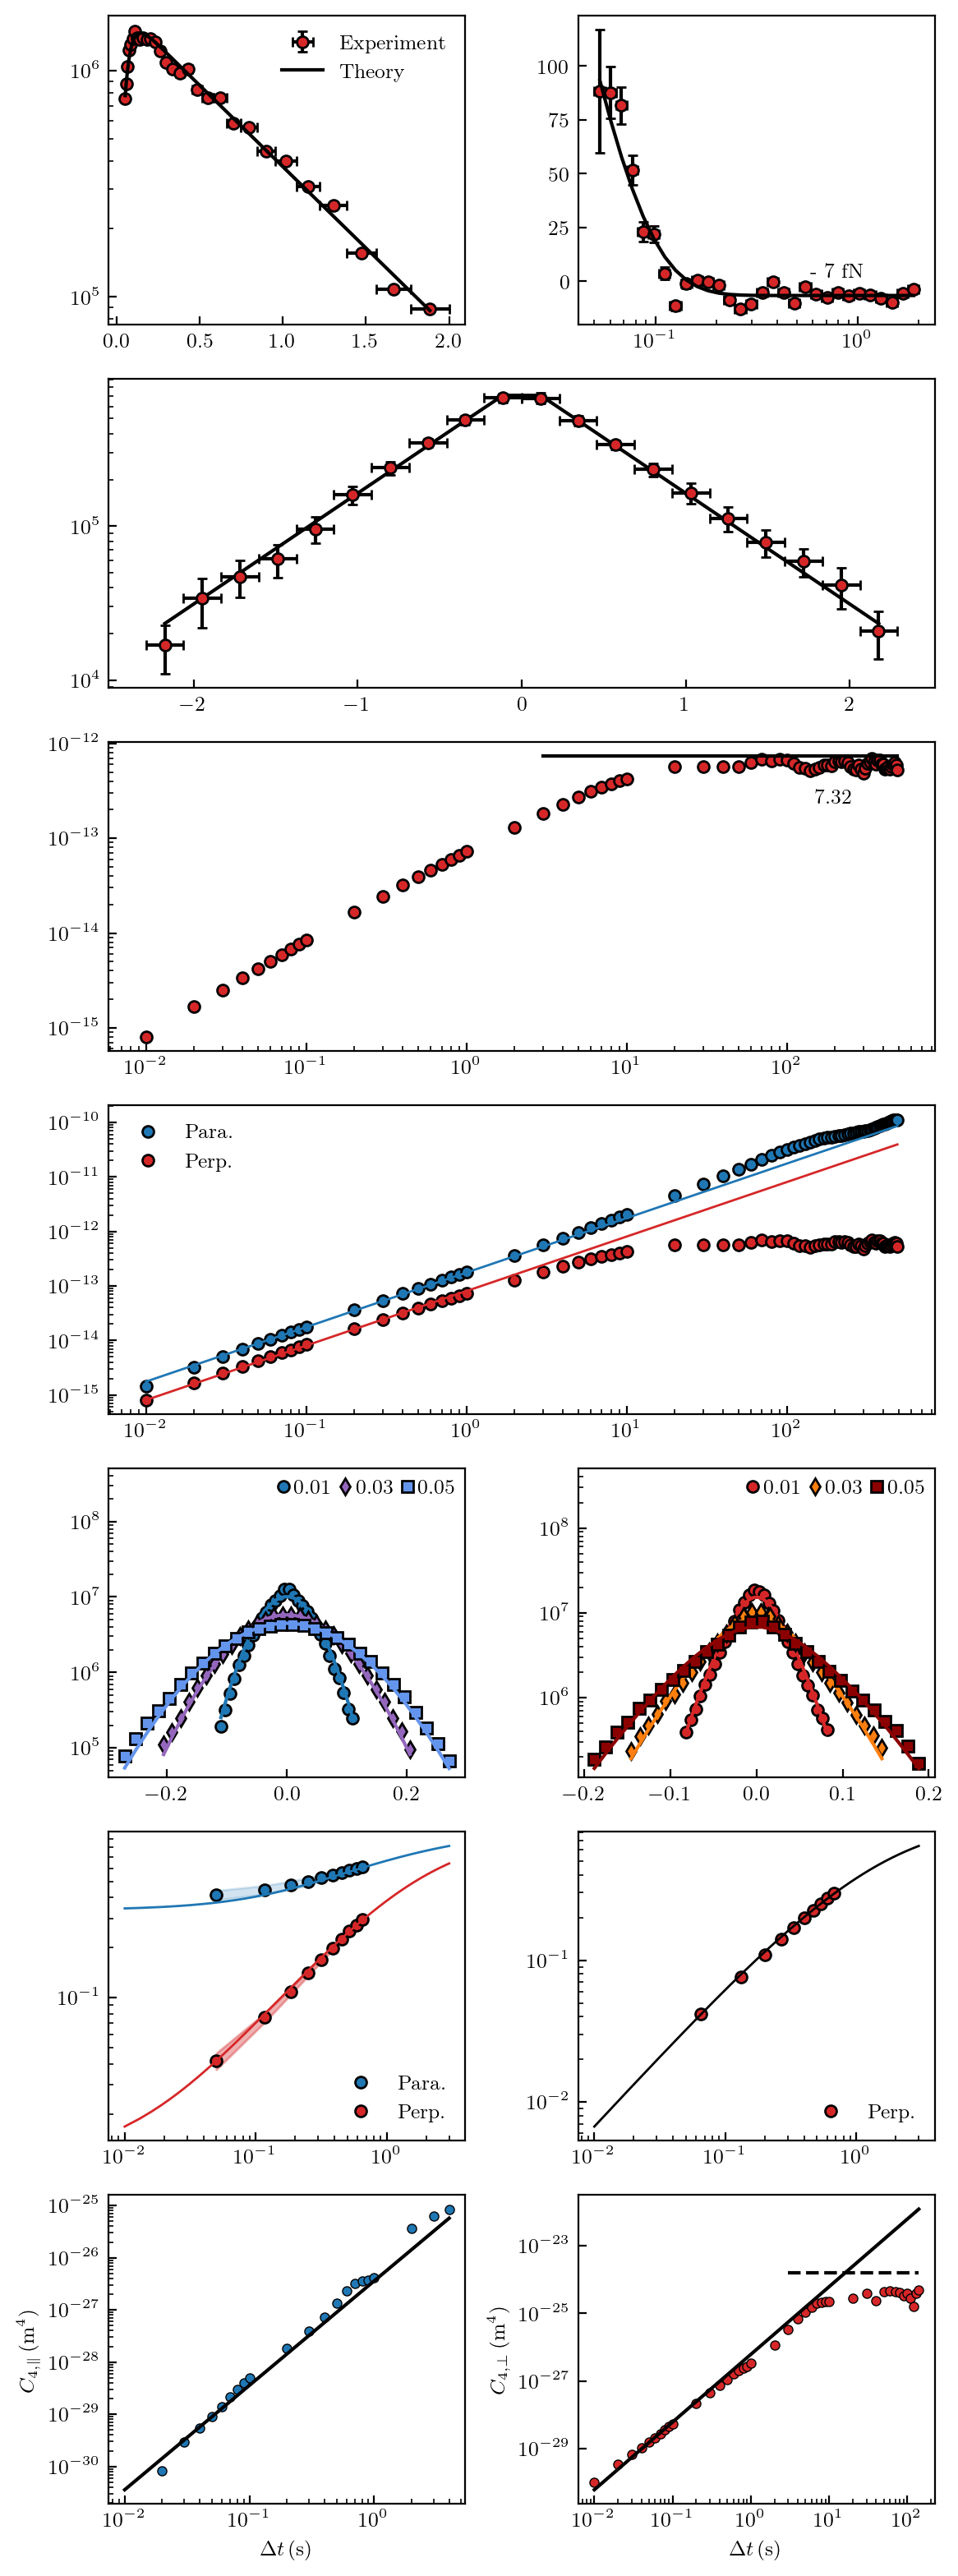

In [409]:
fig = plt.figure(figsize=(15/2.54, 40/2.54), dpi = 200)

nb_lin = 7
nb_col = 2

markers = ['o', 'd', 's', 'h', 'D']
colors_blue = ['tab:blue', 'tab:purple', 'cornflowerblue', 'indigo', 'lightsteelblue']
colors_red = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']


# =============================================================================
# Peq
# =============================================================================


ax1 = fig.add_subplot(nb_lin, nb_col, 1)

# The y error bar = 2\sigma. So contains 95% of the possible curves. 

ax1.errorbar(
    x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, xerr=width_pdf_z/2*1e6, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=2, 
    label="Experiment", 
)
ax1.errorbar(
    x_pdf_z * 1e6, P_eq(x_pdf_z, *emetbrown.x[:-1]), yerr=0, 
    ls='-', color='k', 
    ecolor='w', capsize=0, 
    label="Theory", 
)
ax1.legend(frameon=False)
ax1.set_yscale("log")


# =============================================================================
# Feq
# =============================================================================


ax2 = fig.add_subplot(nb_lin, nb_col, 2)

ax2.errorbar(
    x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq*1e15, xerr=width_F_eq/2*1e6, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=2
)
ax2.errorbar(
    x_F_eq * 1e6, F_eq(x_pdf_z, *emetbrown.x[:-1]) * 1e15, yerr=0, 
    ls='-', color='k', 
    ecolor='w', capsize=0, 
)
ax2.annotate(" - {0:.0f} fN".format(4e-21/fitted_lB*1e15), 
             xy=(1, 10),  xycoords='data', xytext=(0.8, 0.2), textcoords='axes fraction', color='k', 
             #arrowprops=dict(facecolor='white', shrink=0.05), 
             horizontalalignment='right', verticalalignment='top', 
            )
ax2.set_xscale("log")


# =============================================================================
# Displacements at long time
# =============================================================================


ax3 = fig.add_subplot(nb_lin, nb_col, (3, 4))

ax3.errorbar(bins_centers_long * 1e6, proba_deltaz_long, yerr=err_proba_deltaz_long, xerr=np.mean(bins_centers_long[1:]-bins_centers_long[:-1])/2*1e6, 
             ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
             ecolor='k', capsize=2, 
            )
ax3.plot(bins_centers_long * 1e6, P_dz_long(bins_centers_long, *emetbrown.x[1:-1]), 
         ls='-', color='k', 
        )

ax3.set_yscale("log")


# =============================================================================
# Plateau of the MSDz
# =============================================================================


ax4 = fig.add_subplot(nb_lin, nb_col, (5, 6))

ax4.plot(
    delta_time_MSD, MSD_z, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=1,  
)
plotplateau = np.ones(len(delta_time_MSD[delta_time_MSD > 2])) * plateau_MSDz_theory
ax4.plot(delta_time_MSD[delta_time_MSD > 2], plotplateau, ls='-', color='k')

ax4.annotate(
    "{0:.2f}".format(plateau_MSDz_theory*1e13), 
    xy=(1e1, 1e-13),  xycoords='data', xytext=(0.9, 0.85), textcoords='axes fraction', color='k', 
    #arrowprops=dict(facecolor='white', shrink=0.05), 
    horizontalalignment='right', verticalalignment='top', 
)

ax4.set(
    xscale="log", 
    yscale="log", 
)


# =============================================================================
# MSD
# =============================================================================


ax5 = fig.add_subplot(nb_lin, nb_col, (7, 8))

ax5.plot(delta_time_MSD, MSD_para,
         ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
         label="Para.", 
        )
ax5.plot(delta_time_MSD, 2 * mean_D_para_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:blue')
ax5.plot(delta_time_MSD, MSD_perp,
         ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
         label="Perp.", 
        )
ax5.plot(delta_time_MSD, 2 * mean_D_perp_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:red')
ax5.legend(frameon=False)
ax5.set_xscale("log")
ax5.set_yscale("log")


# =============================================================================
# Displacement at short time, parallel motion
# =============================================================================


ax6 = fig.add_subplot(nb_lin, nb_col, 9)

for n, i in enumerate(timesteps_dx):
    bins_center, hist = to_store["proba_dx_short_t_{}".format(i)]
    theory_hist = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax6.plot(
        bins_center * 1e6, hist, 
        ls='', marker=markers[n], markersize=5, markerfacecolor=colors_blue[n], markeredgewidth=1, markeredgecolor='k', 
        label = round(i/fps, 3), 
    )
    ax6.plot(bins_center * 1e6, theory_hist, ls='-', color=colors_blue[n])
# ax6.plot(to_store["gaussian_z"][0], to_store["gaussian_z"][1], ls='--', color="dimgrey", label="Gaussian")
# ax6.plot(bins_center_dz_norm, theory_normalized_proba_dz_short, ls='-', color='tab:red', label="Short time theory")

ax6.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)

ax6.set(
    yscale="log", 
    ylim=[None, 5e8], 
    # xlabel=r"$\Delta x \, (\mathrm{\mu m})$", 
    # ylabel=r"$P_{\mathrm{short}}(\Delta x) \, \mathrm{(\mu m ^{-1})}$", 
)


# =============================================================================
# Displacement at short time, perpendicular motion
# =============================================================================


ax7 = fig.add_subplot(nb_lin, nb_col, 10)

for n, i in enumerate(timesteps_dz):
    bins_center, hist = to_store["proba_dz_short_t_{}".format(i)]
    theory_hist = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax7.plot(
        bins_center * 1e6, hist, 
        ls='', marker=markers[n], markersize=5, markerfacecolor=colors_red[n], markeredgewidth=1, markeredgecolor='k', 
        label = round(i/fps, 3), 
    )
    ax7.plot(bins_center * 1e6, theory_hist, ls='-', color=colors_red[n])
# ax7.plot(to_store["gaussian_z"][0], to_store["gaussian_z"][1], ls='--', color="dimgrey", label="Gaussian")
# ax7.plot(bins_center_dz_norm, theory_normalized_proba_dz_short, ls='-', color='tab:red', label="Short time theory")

ax7.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)

ax7.set(
    yscale="log", 
    ylim=[None, 5e8], 
    # xlabel=r"$\Delta z \, (\mathrm{\mu m})$", 
    # ylabel=r"$P_{\mathrm{short}}(\Delta z) \, \mathrm{(\mu m ^{-1})}$", 
)


# =============================================================================
# Diffusion profile (1)
# =============================================================================


ax8 = fig.add_subplot(nb_lin, nb_col, 11)

# Parallel
ax8.plot(
    z_D * 1e6, D_para_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
    label="Para.", 
)
ax8.fill_between(
    z_D * 1e6, D_para_z - 1/2 * err_Dx_z, D_para_z + 1/2 * err_Dx_z, 
    color='tab:blue', alpha=0.2, 
)
ax8.plot(
    z_D_to_plot_theory * 1e6, Dpara_z(z_D_to_plot_theory, fitted_b, z0=fitted_z0, nl=noiselevel_D_para_from_MSD * 0), 
    ls='-', linewidth=1, color='tab:blue', 
)

# Perpendicular
ax8.plot(
    z_D * 1e6, D_perp_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
    label="Perp.", 
)
ax8.fill_between(
    z_D * 1e6, D_perp_z - 1/2 * err_Dz_z, D_perp_z + 1/2 * err_Dz_z, 
    color='tab:red', alpha=0.2, 
)
ax8.plot(
    z_D_to_plot_theory * 1e6, Dperp_z(z_D_to_plot_theory, fitted_b, z0=fitted_z0, nl=noiselevel_D_perp_from_MSD * 0), 
    ls='-', linewidth=1, color='tab:red', 
)

ax8.legend(frameon=False, loc='lower right')
ax8.set_xscale("log")
ax8.set_yscale("log")


# =============================================================================
# Diffusion profile (2)
# =============================================================================


ax9 = fig.add_subplot(nb_lin, nb_col, 12)

ax9.plot(
    (z_D - fitted_z0 + fitted_b) * 1e6, D_perp_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
    label="Perp.", 
)
ax8.fill_between(
    z_D * 1e6, D_perp_z - 1/2 * err_Dz_z, D_perp_z + 1/2 * err_Dz_z, 
    color='tab:red', alpha=0.2, 
)
ax9.plot(
    z_D_to_plot_theory * 1e6, Dperp_z(z_D_to_plot_theory, b=0, z0=0, nl=0), 
    ls='-', linewidth=1, color='k', 
)

ax9.legend(frameon=False, loc='lower right')

ax9.set(
    xscale="log", 
    yscale="log", 
)


# =============================================================================
# Fourth cumulant: transverse
# =============================================================================


ax10 = fig.add_subplot(nb_lin, nb_col, 13)

ax10.plot(
    dtime_C4[dtime_C4 < 5], C4_para[dtime_C4 < 5], 
    ls='', marker='o', markersize=4, markerfacecolor='tab:blue', 
    markeredgewidth=0.5, markeredgecolor='k', 
    label='Para.', 
)
ax10.plot(
    dtime_C4[dtime_C4 < 5], K4x_short(dtime_C4[dtime_C4 < 5], fitted_B, fitted_lD, fitted_lB, b=fitted_b), 
    ls='-', linewidth=1.5, color='k', 
)

ax10.set(
    xscale="log", 
    yscale="log", 
    xlabel="$\Delta t \, \mathrm{(s)}$", 
    ylabel="$C_{4,\parallel} \, \mathrm{(m^4)}$", 
)


# =============================================================================
# Fourth cumulant: normal
# =============================================================================


ax11 = fig.add_subplot(nb_lin, nb_col, 14)

ax11.plot(
    dtime_C4, C4_perp, 
    ls='', marker='o', markersize=4, markerfacecolor='tab:red', 
    markeredgewidth=0.5, markeredgecolor='k', 
    label='$z$', 
)
ax11.plot(
    dtime_C4, K4z_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, b=fitted_b), 
    ls='-', linewidth=1.5, color='k', 
)
ax11.plot(
    dtime_C4[dtime_C4 > 2], K4z_long(fitted_B, fitted_lD, fitted_lB) * np.ones(len(dtime_C4[dtime_C4 > 2])), 
    ls='--', linewidth=1.5, color='k', 
)

ax11.set(
    xscale="log", 
    yscale="log", 
    xlabel="$\Delta t \, \mathrm{(s)}$", 
    ylabel="$C_{4,\perp} \, \mathrm{(m^4)}$", 
)


# =============================================================================
# Layout
# =============================================================================


fig.tight_layout()

plt.show()

In [410]:
# fig.savefig('test1.pdf')

### Several Multifit

In [411]:
# New initial guess for the multifit?

# what2do = input('New initial guess? ')
# if what2do == 'y' or what2do == 'yes':
#     x0 = emetbrown.x[:]

x0 = emetbrown.x[:]

In [412]:
x0

array([1.01940280e-09, 3.95378467e+00, 3.38799732e-08, 6.03527047e-07,
       1.63711554e-08])

In [413]:
# Perform several multifits, changing the initial guess.
# The goal is to attest the stability of the minimum found.

n_multifits = 5

max_iter = 4 * 200
max_fev = 4 * 200

In [414]:
doc = [] # Will contain all the successful multifittings
marty = [] # Res of the successful multifittings
einstein = [] # Initial guesses
lorraine = [] # Success or not
n_success = 0

for i in range(n_multifits):
    
    print(i)
    
    # Random changes on the initial guess
    if i == 0:
        x00 = np.copy(x0)
    else:
        random = np.random.normal(loc=0, scale=1, size=(1,5))
        x00 = x0 + random * np.array([3e-9, 0.5, 2e-9, 3e-9, 3e-9])
        # random = np.random.normal(loc=0, scale=1, size=(1,4))
        # x00 = np.zeros(5)
        # x00[1:] = x0[1:] + random * np.array([0.5, 5e-9, 20e-9, 0.])
        x00 = x00.squeeze()
    einstein.append(x00)
    
    print('Initial guess = {}'.format(x00))
    
    # Multifit
    emmett = minimize(
        powerful_minimizer, x00, 
        method="Nelder-Mead", 
        tol=1e-2,
        bounds=bounds, # The bounds should be the same ones as for the first multifit.
        options={'maxiter':int(max_iter), 'maxfev':int(max_fev), 'adaptive':True}, 
    )
    
    print('Success? {}'.format(emmett.success))
    
    # Save results
    lorraine.append(emmett.success)
    if emmett.success:
        doc.append(emmett)
        marty.append(emmett.x)
        n_success += 1 
        
        print('Result = {}'.format(emmett.x))
        
    print()

marty = np.array(marty)

print('Number of successful fittings = {}'.format(n_success))

0
Initial guess = [1.01940280e-09 3.95378467e+00 3.38799732e-08 6.03527047e-07
 1.63711554e-08]
Success? True
Result = [1.01940280e-09 3.95378467e+00 3.38799732e-08 6.03527047e-07
 1.63711554e-08]

1
Initial guess = [3.13624461e-10 4.56378355e+00 3.30280644e-08 6.02981235e-07
 2.04665218e-08]
Success? True
Result = [2.43391154e-10 5.14025824e+00 2.96171331e-08 6.07447731e-07
 2.25244032e-08]

2
Initial guess = [1.97999675e-10 4.47703943e+00 3.63143599e-08 6.04308893e-07
 1.50388376e-08]
Success? True
Result = [2.00407940e-10 5.15049984e+00 2.96115840e-08 6.07424577e-07
 1.54019568e-08]

3
Initial guess = [1.37300295e-09 3.49943377e+00 3.82953720e-08 6.01580586e-07
 1.61764995e-08]
Success? True
Result = [1.14123281e-09 3.93982905e+00 3.38884329e-08 6.03588991e-07
 1.69500089e-08]

4
Initial guess = [1.15159893e-09 4.62179362e+00 3.10755641e-08 6.04153857e-07
 1.75126371e-08]
Success? True
Result = [1.15677553e-09 4.98975778e+00 2.96060407e-08 6.07381771e-07
 1.73254698e-08]

Number of 

In [415]:
for i in range(len(marty[:,0])):
    print(powerful_minimizer(marty[i,:]))

32.11839634047616
31.562663860885994
31.56117218796443
32.11843589257295
31.561213191624287


In [416]:
marty

array([[1.01940280e-09, 3.95378467e+00, 3.38799732e-08, 6.03527047e-07,
        1.63711554e-08],
       [2.43391154e-10, 5.14025824e+00, 2.96171331e-08, 6.07447731e-07,
        2.25244032e-08],
       [2.00407940e-10, 5.15049984e+00, 2.96115840e-08, 6.07424577e-07,
        1.54019568e-08],
       [1.14123281e-09, 3.93982905e+00, 3.38884329e-08, 6.03588991e-07,
        1.69500089e-08],
       [1.15677553e-09, 4.98975778e+00, 2.96060407e-08, 6.07381771e-07,
        1.73254698e-08]])

In [417]:
outliers_index = input('Outliers index (usual numerotation)? ')
outliers_index = np.array([int(i) for i in outliers_index.split()])
outliers_index -= 1

for i in outliers_index:
    lorraine[i] = False
    n_success -= 1
    marty[i,:] = np.ones((1, 5)) * np.nan

Outliers index (usual numerotation)?  1 4


In [418]:
marty

array([[           nan,            nan,            nan,            nan,
                   nan],
       [2.43391154e-10, 5.14025824e+00, 2.96171331e-08, 6.07447731e-07,
        2.25244032e-08],
       [2.00407940e-10, 5.15049984e+00, 2.96115840e-08, 6.07424577e-07,
        1.54019568e-08],
       [           nan,            nan,            nan,            nan,
                   nan],
       [1.15677553e-09, 4.98975778e+00, 2.96060407e-08, 6.07381771e-07,
        1.73254698e-08]])

In [419]:
class AverageMultifits():
    def __init__(self, x=np.zeros(5), stdx=np.zeros(5), n_multifits=n_multifits, n_success=n_success):
        self.x = x
        self.stdx = stdx
        self.n_multifits = n_multifits
        self.n_success = n_success

In [420]:
emetbrown = AverageMultifits(np.nanmean(marty, axis=0), np.nanstd(marty, axis=0))

In [421]:
emetbrown.x

array([5.33524875e-10, 5.09350528e+00, 2.96115859e-08, 6.07418026e-07,
       1.84172766e-08])

In [422]:
emetbrown.stdx

array([4.41053983e-10, 7.34796192e-02, 4.52844054e-12, 2.73237157e-11,
       3.00847048e-09])

In [423]:
#####

###

# Pause here the click and collect

###

####

In [424]:
fitted_z0, fitted_B, fitted_lD, fitted_lB, fitted_b = emetbrown.x

In [425]:
print("Result of the multi-fit:")
print()
print('B = {}'.format(emetbrown.x[1]))
print('lD = {} nm'.format(emetbrown.x[2]*1e9))
print('lB = {} nm'.format(emetbrown.x[3]*1e9))
print()
print('z0 = {} nm'.format(emetbrown.x[0]*1e9))
print('b = {} nm'.format(emetbrown.x[4]*1e9))

Result of the multi-fit:

B = 5.093505283232869
lD = 29.611585942195834 nm
lB = 607.418026497948 nm

z0 = 0.5335248747260064 nm
b = 18.417276594505132 nm


In [426]:
plateau_MSDz_theory = plateau(fitted_B, fitted_lD, fitted_lB)

xxx = np.linspace(10e-9, 10e-6, 1000)

mean_D_para_from_multifit = np.trapezoid(P_eq(xxx, 0, *emetbrown.x[1:-1]) * Dpara_z(xxx, fitted_b), xxx)
mean_D_perp_from_multifit = np.trapezoid(P_eq(xxx, 0, *emetbrown.x[1:-1]) * Dperp_z(xxx, fitted_b), xxx)

z_D_to_plot_theory = np.linspace(0.007e-6, 3e-6, 1000)

In [427]:
print("Mean diffusion coefficients")

print()

print(mean_D_para_from_MSD)
print(mean_D_para_from_multifit)

print() 

print(mean_D_perp_from_MSD)
print(mean_D_perp_from_multifit)

Mean diffusion coefficients

0.5686188896516047
0.5686787138644432

0.2719411118808092
0.26152239807970845


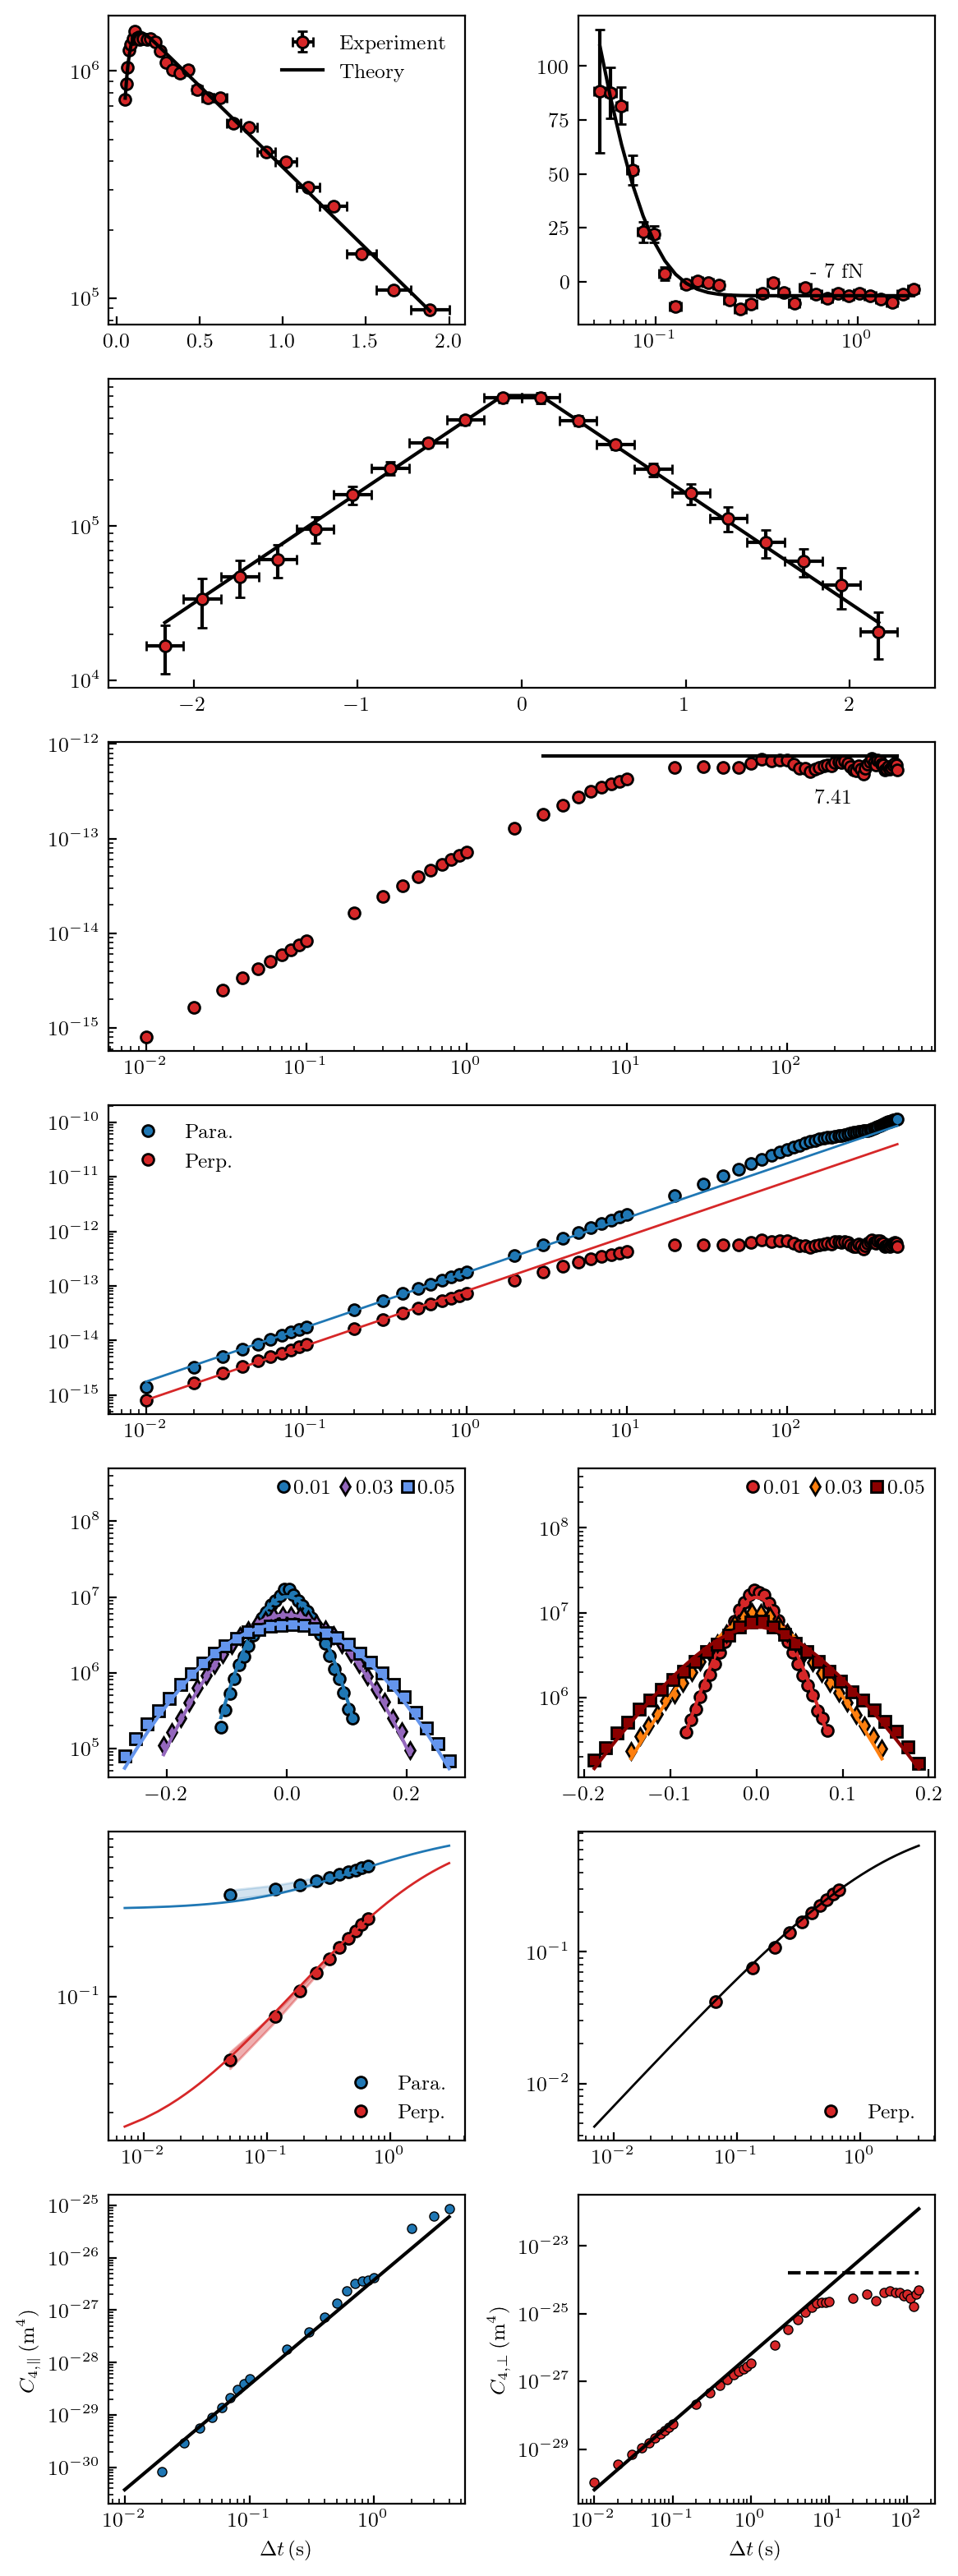

In [428]:
fig = plt.figure(figsize=(15/2.54, 40/2.54), dpi = 200)

nb_lin = 7
nb_col = 2

markers = ['o', 'd', 's', 'h', 'D']
colors_blue = ['tab:blue', 'tab:purple', 'cornflowerblue', 'indigo', 'lightsteelblue']
colors_red = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']


# =============================================================================
# Peq
# =============================================================================


ax1 = fig.add_subplot(nb_lin, nb_col, 1)

# The y error bar = 2\sigma. So contains 95% of the possible curves. 

ax1.errorbar(
    x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, xerr=width_pdf_z/2*1e6, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=2, 
    label="Experiment", 
)
ax1.errorbar(
    x_pdf_z * 1e6, P_eq(x_pdf_z, *emetbrown.x[:-1]), yerr=0, 
    ls='-', color='k', 
    ecolor='w', capsize=0, 
    label="Theory", 
)
ax1.legend(frameon=False)
ax1.set_yscale("log")


# =============================================================================
# Feq
# =============================================================================


ax2 = fig.add_subplot(nb_lin, nb_col, 2)

ax2.errorbar(
    x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq*1e15, xerr=width_F_eq/2*1e6, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=2
)
ax2.errorbar(
    x_F_eq * 1e6, F_eq(x_pdf_z, *emetbrown.x[:-1]) * 1e15, yerr=0, 
    ls='-', color='k', 
    ecolor='w', capsize=0, 
)
ax2.annotate(" - {0:.0f} fN".format(4e-21/fitted_lB*1e15), 
             xy=(1, 10),  xycoords='data', xytext=(0.8, 0.2), textcoords='axes fraction', color='k', 
             #arrowprops=dict(facecolor='white', shrink=0.05), 
             horizontalalignment='right', verticalalignment='top', 
            )
ax2.set_xscale("log")


# =============================================================================
# Displacements at long time
# =============================================================================


ax3 = fig.add_subplot(nb_lin, nb_col, (3, 4))

ax3.errorbar(bins_centers_long * 1e6, proba_deltaz_long, yerr=err_proba_deltaz_long, xerr=np.mean(bins_centers_long[1:]-bins_centers_long[:-1])/2*1e6, 
             ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
             ecolor='k', capsize=2, 
            )
ax3.plot(bins_centers_long * 1e6, P_dz_long(bins_centers_long, *emetbrown.x[1:-1]), 
         ls='-', color='k', 
        )

ax3.set_yscale("log")


# =============================================================================
# Plateau of the MSDz
# =============================================================================


ax4 = fig.add_subplot(nb_lin, nb_col, (5, 6))

ax4.plot(
    delta_time_MSD, MSD_z, 
    ls='', marker='o', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=1,  
)
plotplateau = np.ones(len(delta_time_MSD[delta_time_MSD > 2])) * plateau_MSDz_theory
ax4.plot(delta_time_MSD[delta_time_MSD > 2], plotplateau, ls='-', color='k')

ax4.annotate(
    "{0:.2f}".format(plateau_MSDz_theory*1e13), 
    xy=(1e1, 1e-13),  xycoords='data', xytext=(0.9, 0.85), textcoords='axes fraction', color='k', 
    #arrowprops=dict(facecolor='white', shrink=0.05), 
    horizontalalignment='right', verticalalignment='top', 
)

ax4.set(
    xscale="log", 
    yscale="log", 
)


# =============================================================================
# MSD
# =============================================================================


ax5 = fig.add_subplot(nb_lin, nb_col, (7, 8))

ax5.plot(delta_time_MSD, MSD_para,
         ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
         label="Para.", 
        )
ax5.plot(delta_time_MSD, 2 * mean_D_para_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:blue')
ax5.plot(delta_time_MSD, MSD_perp,
         ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
         label="Perp.", 
        )
ax5.plot(delta_time_MSD, 2 * mean_D_perp_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:red')
ax5.legend(frameon=False)
ax5.set_xscale("log")
ax5.set_yscale("log")


# =============================================================================
# Displacement at short time, parallel motion
# =============================================================================


ax6 = fig.add_subplot(nb_lin, nb_col, 9)

for n, i in enumerate(timesteps_dx):
    bins_center, hist = to_store["proba_dx_short_t_{}".format(i)]
    theory_hist = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax6.plot(
        bins_center * 1e6, hist, 
        ls='', marker=markers[n], markersize=5, markerfacecolor=colors_blue[n], markeredgewidth=1, markeredgecolor='k', 
        label = round(i/fps, 3), 
    )
    ax6.plot(bins_center * 1e6, theory_hist, ls='-', color=colors_blue[n])
# ax6.plot(to_store["gaussian_z"][0], to_store["gaussian_z"][1], ls='--', color="dimgrey", label="Gaussian")
# ax6.plot(bins_center_dz_norm, theory_normalized_proba_dz_short, ls='-', color='tab:red', label="Short time theory")

ax6.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)

ax6.set(
    yscale="log", 
    ylim=[None, 5e8], 
    # xlabel=r"$\Delta x \, (\mathrm{\mu m})$", 
    # ylabel=r"$P_{\mathrm{short}}(\Delta x) \, \mathrm{(\mu m ^{-1})}$", 
)


# =============================================================================
# Displacement at short time, perpendicular motion
# =============================================================================


ax7 = fig.add_subplot(nb_lin, nb_col, 10)

for n, i in enumerate(timesteps_dz):
    bins_center, hist = to_store["proba_dz_short_t_{}".format(i)]
    theory_hist = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax7.plot(
        bins_center * 1e6, hist, 
        ls='', marker=markers[n], markersize=5, markerfacecolor=colors_red[n], markeredgewidth=1, markeredgecolor='k', 
        label = round(i/fps, 3), 
    )
    ax7.plot(bins_center * 1e6, theory_hist, ls='-', color=colors_red[n])
# ax7.plot(to_store["gaussian_z"][0], to_store["gaussian_z"][1], ls='--', color="dimgrey", label="Gaussian")
# ax7.plot(bins_center_dz_norm, theory_normalized_proba_dz_short, ls='-', color='tab:red', label="Short time theory")

ax7.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)

ax7.set(
    yscale="log", 
    ylim=[None, 5e8], 
    # xlabel=r"$\Delta z \, (\mathrm{\mu m})$", 
    # ylabel=r"$P_{\mathrm{short}}(\Delta z) \, \mathrm{(\mu m ^{-1})}$", 
)


# =============================================================================
# Diffusion profile (1)
# =============================================================================


ax8 = fig.add_subplot(nb_lin, nb_col, 11)

# Parallel
ax8.plot(
    z_D * 1e6, D_para_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
    label="Para.", 
)
ax8.fill_between(
    z_D * 1e6, D_para_z - 1/2 * err_Dx_z, D_para_z + 1/2 * err_Dx_z, 
    color='tab:blue', alpha=0.2, 
)
ax8.plot(
    z_D_to_plot_theory * 1e6, Dpara_z(z_D_to_plot_theory, fitted_b, z0=fitted_z0, nl=noiselevel_D_para_from_MSD * 0), 
    ls='-', linewidth=1, color='tab:blue', 
)

# Perpendicular
ax8.plot(
    z_D * 1e6, D_perp_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
    label="Perp.", 
)
ax8.fill_between(
    z_D * 1e6, D_perp_z - 1/2 * err_Dz_z, D_perp_z + 1/2 * err_Dz_z, 
    color='tab:red', alpha=0.2, 
)
ax8.plot(
    z_D_to_plot_theory * 1e6, Dperp_z(z_D_to_plot_theory, fitted_b, z0=fitted_z0, nl=noiselevel_D_perp_from_MSD * 0), 
    ls='-', linewidth=1, color='tab:red', 
)

ax8.legend(frameon=False, loc='lower right')
ax8.set_xscale("log")
ax8.set_yscale("log")


# =============================================================================
# Diffusion profile (2)
# =============================================================================


ax9 = fig.add_subplot(nb_lin, nb_col, 12)

ax9.plot(
    (z_D - fitted_z0 + fitted_b) * 1e6, D_perp_z, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
    label="Perp.", 
)
ax8.fill_between(
    z_D * 1e6, D_perp_z - 1/2 * err_Dz_z, D_perp_z + 1/2 * err_Dz_z, 
    color='tab:red', alpha=0.2, 
)
ax9.plot(
    z_D_to_plot_theory * 1e6, Dperp_z(z_D_to_plot_theory, b=0, z0=0, nl=0), 
    ls='-', linewidth=1, color='k', 
)

ax9.legend(frameon=False, loc='lower right')

ax9.set(
    xscale="log", 
    yscale="log", 
)


# =============================================================================
# Fourth cumulant: transverse
# =============================================================================


ax10 = fig.add_subplot(nb_lin, nb_col, 13)

ax10.plot(
    dtime_C4[dtime_C4 < 5], C4_para[dtime_C4 < 5], 
    ls='', marker='o', markersize=4, markerfacecolor='tab:blue', 
    markeredgewidth=0.5, markeredgecolor='k', 
    label='Para.', 
)
ax10.plot(
    dtime_C4[dtime_C4 < 5], K4x_short(dtime_C4[dtime_C4 < 5], fitted_B, fitted_lD, fitted_lB, b=0), 
    ls='-', linewidth=1.5, color='k', 
)

ax10.set(
    xscale="log", 
    yscale="log", 
    xlabel="$\Delta t \, \mathrm{(s)}$", 
    ylabel="$C_{4,\parallel} \, \mathrm{(m^4)}$", 
)


# =============================================================================
# Fourth cumulant: normal
# =============================================================================


ax11 = fig.add_subplot(nb_lin, nb_col, 14)

ax11.plot(
    dtime_C4, C4_perp, 
    ls='', marker='o', markersize=4, markerfacecolor='tab:red', 
    markeredgewidth=0.5, markeredgecolor='k', 
    label='$z$', 
)
ax11.plot(
    dtime_C4, K4z_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, b=0), 
    ls='-', linewidth=1.5, color='k', 
)
ax11.plot(
    dtime_C4[dtime_C4 > 2], K4z_long(fitted_B, fitted_lD, fitted_lB) * np.ones(len(dtime_C4[dtime_C4 > 2])), 
    ls='--', linewidth=1.5, color='k', 
)

ax11.set(
    xscale="log", 
    yscale="log", 
    xlabel="$\Delta t \, \mathrm{(s)}$", 
    ylabel="$C_{4,\perp} \, \mathrm{(m^4)}$", 
)


# =============================================================================
# Layout
# =============================================================================


fig.tight_layout()

plt.show()

In [429]:
# Save data

tosave["fitted_z0"] = fitted_z0
tosave["fitted_B"] = fitted_B
tosave["fitted_lD"] = fitted_lD
tosave["fitted_lB"] = fitted_lB
tosave["fitted_b"] = fitted_b

tosave['pm_z0'], tosave['pm_B'], tosave['pm_lD'], tosave['pm_lB'], tosave['pm_b'] = emetbrown.stdx

tosave['n_multifits'] = n_multifits
tosave['n_success'] = n_success



tosave["bins_centers_long"] = np.copy(bins_centers_long)
tosave["proba_deltaz_long"] = np.copy(proba_deltaz_long)
tosave["err_proba_deltaz_long"] = np.copy(err_proba_deltaz_long)
tosave["proba_deltaz_long_theory"] = P_dz_long(bins_centers_long, fitted_B, fitted_lD, fitted_lB)

tosave["plateau_MSDz_exp"] = plateau_MSDz_exp
tosave["plateau_MSDz_theory"] = plateau_MSDz_theory 



tosave["mean_D_para_from_multifit"] = mean_D_para_from_multifit
tosave["mean_D_perp_from_multifit"] = mean_D_perp_from_multifit

# for i in range(1, 6, 1):
#     tosave["proba_dz_short_timestep_{}".format(i)] = np.copy(to_store["proba_dz_short_t_{}".format(i)]) # Contains [x-axis, y-axis]
#     bins_center = to_store["proba_dz_short_t_{}".format(i)][0]
#     hist_theory = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
#     tosave["proba_dz_short_timestep_{}_theory".format(i)] = [bins_center, hist_theory]
#     tosave["normalized_proba_dz_short_timestep_{}".format(i)] = np.copy(to_store["normalized_proba_dz_short_t_{}".format(i)]) # Idem
#     tosave["proba_dx_short_timestep_{}".format(i)] = np.copy(to_store["proba_dx_short_t_{}".format(i)]) # Contains [x-axis, y-axis]
#     bins_center = to_store["proba_dx_short_t_{}".format(i)][0]
#     hist_theory = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
#     tosave["proba_dx_short_timestep_{}_theory".format(i)] = [bins_center, hist_theory]
#     tosave["normalized_proba_dx_short_timestep_{}".format(i)] = np.copy(to_store["normalized_proba_dx_short_t_{}".format(i)]) # Idem


tosave['timesteps_dx'] = timesteps_dx
tosave['timesteps_dz'] = timesteps_dz

for n, i in enumerate(timesteps_dz):
    tosave["proba_dz_short_timestep_{}".format(i)] = np.copy(to_store["proba_dz_short_t_{}".format(i)]) # Contains [x-axis, y-axis]
    bins_center = to_store["proba_dz_short_t_{}".format(i)][0]
    hist_theory = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    tosave["proba_dz_short_timestep_{}_theory".format(i)] = [bins_center, hist_theory]
    tosave["normalized_proba_dz_short_timestep_{}".format(i)] = np.copy(to_store["normalized_proba_dz_short_t_{}".format(i)]) # Idem
for n, i in enumerate(timesteps_dx):
    tosave["proba_dx_short_timestep_{}".format(i)] = np.copy(to_store["proba_dx_short_t_{}".format(i)]) # Contains [x-axis, y-axis]
    bins_center = to_store["proba_dx_short_t_{}".format(i)][0]
    hist_theory = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    tosave["proba_dx_short_timestep_{}_theory".format(i)] = [bins_center, hist_theory]
    tosave["normalized_proba_dx_short_timestep_{}".format(i)] = np.copy(to_store["normalized_proba_dx_short_t_{}".format(i)]) # Idem
    
tosave["gaussian_z"] = np.copy(to_store["gaussian_z"]) # Contains [x-axis, y-axis]
tosave["gaussian_x"] = np.copy(to_store["gaussian_x"]) # Idem

# tosave["theory_normalized_proba_dx_short"] = [np.copy(bins_center_dx_norm), np.copy(theory_normalized_proba_dx_short)] # Idem
# tosave["theory_normalized_proba_dz_short"] = [np.copy(bins_center_dz_norm), np.copy(theory_normalized_proba_dz_short)] # Idem

tosave["coef_C4_para_short_theory"] = K4x_short(1, B=fitted_B, lD=fitted_lD, lB=fitted_lB, b=0, want_more=True)[3]

In [430]:
# Cell for results, of all the fittings

print('Number of successful multifittings = {}'.format(emetbrown.n_success))
print()
print("Results:")
print(" - z0 = {0:.1f} nm".format(fitted_z0 * 1e9))
print(" - B = {:.1f}".format(fitted_B))
print(" - lD = {:.0f} nm".format(fitted_lD * 1e9))
print(" - lB = {0:.0f} nm (vs. {1:.0f} nm in theory)".format(fitted_lB * 1e9, lB_theory * 1e9))
print("   Which gives a buyoant density = {:.0f} kg/m3".format(4e-21 / (4/3 * np.pi * r**3 * 9.81 * fitted_lB)))
print()
print(" - b = {0:.1f} nm".format(fitted_b * 1e9))

print()
print("Mean diffusion coefficients (MSD vs. multifit):")
print(" - Mean D para. = {0:.2f} D0 (MSD) vs. {1:.2f} D0 (multi-fit)".format(mean_D_para_from_MSD, mean_D_para_from_multifit))
print(" - Mean D perp. = {0:.2f} D0 (MSD) vs. {1:.2f} D0 (multi-fit)".format(mean_D_perp_from_MSD, mean_D_perp_from_multifit))
print("FYI, D0 = {0:.3e} m^2/s".format(D0))

print()
print("Error relative to the position:")
print(" - The measured noise levels on the MSD are:")
print("   - Para.: {0:.3f} nm".format(noise_level_para_from_MSD))
print("   - Perp.: {0:.3f} nm".format(noise_level_perp_from_MSD))
print(" - Vestergaard error: ")
print("   - x: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_x*1e9, err_Dx_z))
print("   - y: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_y*1e9, err_Dy_z))
print("   - z: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_z*1e9, err_Dz_z))
print("   Don't forget to check if an error happenend on the computation of the Vestergaard error!")

Number of successful multifittings = 3

Results:
 - z0 = 0.5 nm
 - B = 5.1
 - lD = 30 nm
 - lB = 607 nm (vs. 607 nm in theory)
   Which gives a buyoant density = 50 kg/m3

 - b = 18.4 nm

Mean diffusion coefficients (MSD vs. multifit):
 - Mean D para. = 0.57 D0 (MSD) vs. 0.57 D0 (multi-fit)
 - Mean D perp. = 0.27 D0 (MSD) vs. 0.26 D0 (multi-fit)
FYI, D0 = 1.547e-13 m^2/s

Error relative to the position:
 - The measured noise levels on the MSD are:
   - Para.: -0.000 nm
   - Perp.: -0.000 nm
 - Vestergaard error: 
   - x: on position = 12.8 nm and on diffusion = 0.05 D0
   - y: on position = 12.9 nm and on diffusion = 0.05 D0
   - z: on position = 5.4 nm and on diffusion = 0.01 D0
   Don't forget to check if an error happenend on the computation of the Vestergaard error!


In [431]:
# del to_store

# Forces, After The Multi-Fittings

In [432]:
# Force Corrected 
tt = tautau / fps # tautau defined before multifit 
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=tautau, return_all=True)
F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
F_nc_corrected = F_nc * np.exp(tt/tau_c_F_nc)

# Smallest Time Step
bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=timestep_diffusion, return_all=True)
F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
# Thermal noise 
tau_boxes = err_vz * 1/fps
F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z_exp * r / tau_boxes)

# # Force Corrected 
# # tautau = 8
# tt = tautau / fps
# bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(z_D_max=z_D_max, tau=tautau, return_all=True)
# F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
# F_nc_corrected = F_nc * np.exp(tt/tau_c_F_nc)

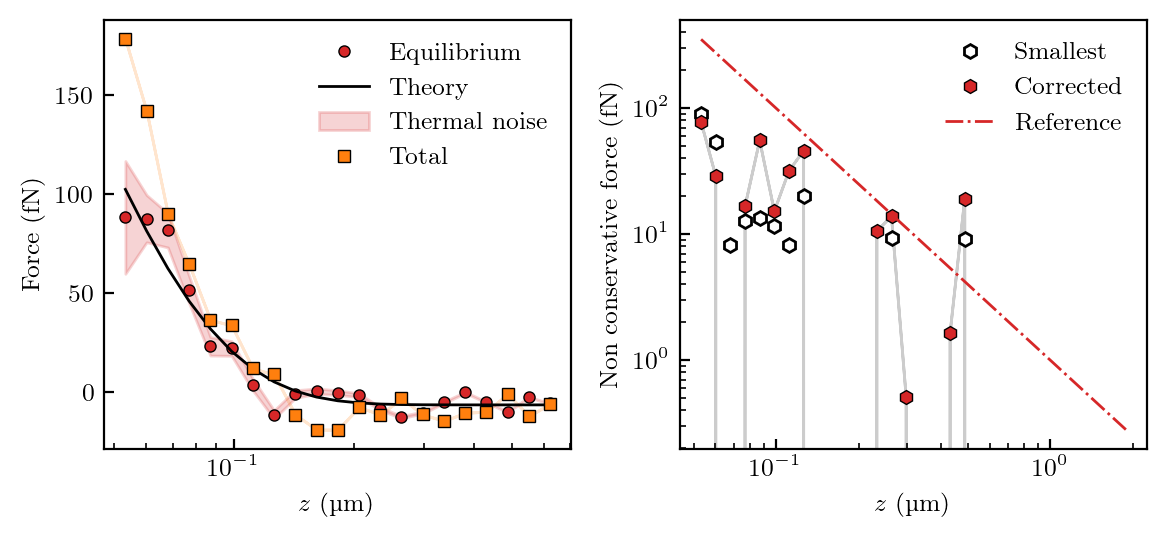

Gauche = non corrigé et smallest time step. Droite = corrigé


In [433]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15/2.54, 7/2.54))

ax1.plot(bins_left * 1e6, y_F_eq_trunc * 1e15, 'o', markerfacecolor='tab:red', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Equilibrium")
ax1.plot(bins_left * 1e6, F_eq_theoretical * 1e15, ls='-', linewidth=1, c='k', label="Theory")
ax1.fill_between(
    bins_left * 1e6, (y_F_eq_trunc - err_y_F_eq_trunc)*1e15, (y_F_eq_trunc + err_y_F_eq_trunc)*1e15, 
    alpha = 0.2, color ="tab:red", label = "Thermal noise"
)
ax1.plot(bins_left * 1e6, F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=4, markeredgecolor='k', markeredgewidth=0.5, label="Total")
ax1.fill_between(
    bins_left * 1e6, (F_tot - err_F_tot)*1e15, (F_tot + err_F_tot)*1e15, 
    alpha = 0.2, color ="tab:orange", 
)
ax1.legend(frameon=False)
ax1.set(
    xlabel='$z$ (µm)', 
    ylabel='Force (fN)', 
    xscale='log', 
    yscale='linear', 
)

ax2.plot(bins_left * 1e6, F_nc * 1e15, 'h', markerfacecolor='w', markersize=5, markeredgecolor='k', markeredgewidth=1, label='Smallest')
ax2.plot(bins_left * 1e6, F_nc_corrected * 1e15, 'h', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=0.5, label='Corrected')
ax2.plot(x_reference * 1e6, F_nc_ref * 1e15, ls='-.', linewidth=1, c='tab:red', label="Reference")
ax2.fill_between(
    bins_left * 1e6, (F_nc_corrected - err_F_tot) * 1e15, (F_nc_corrected + err_F_tot) * 1e15, 
    alpha = 0.2, color ="k", 
)
ax2.legend(frameon=False)
ax2.set(
    xlabel='$z$ (µm)', 
    ylabel='Non conservative force (fN)', 
    xscale='log', 
    yscale='log', 
)

plt.tight_layout()
plt.show()

print('Gauche = non corrigé et smallest time step. Droite = corrigé')

In [434]:
# fig.savefig('essai_ansatz_force_tau_AR1000_water_EG30_{}.pdf'.format(filename[:-4]))

In [435]:
def Dperp_prime_z(z, offset_D):
    return (42 * r*(z**2) + 24 * (r**2)*z + 4 * (r**3)) / (6 * (z**2) + 9 * r*z + 2 * (r**2))**2

def Dprime_over_D(z, offset_D, nl=0):
    # return (42 * r*(z**2) + 24 * (r**2)*z + 4 * (r**3)) / (36 * (z**4) + 66 * r*(z**3) + 30 * (r**2)*(z**2) + 4 * (r**3)*z)
    return Dperp_prime_z(z, offset_D) / Dperp_z(z, offset_D, nl)

In [436]:
# Save data 

tosave["coef_interpolation_Dz_z"] = coefs

# Final Plot

__Be careful: from now on, the offsets are put on the experimental points__

## Computation (Retrieving offsets on PDF mainly)

In [437]:
# garde_fou_3 = True
# x_pdf_z = x_pdf_z + z0

In [438]:
# Shift all the experimental curves. No more offsets on the theoretical curves.
# Be careful: do it only if it hasn't already been done.

if garde_fou_3:
    
    
    # ---------------------------------------------------------------------------------------------
    # ---------- Pdf ------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------
    
    #Experimental
    x_pdf_z -= fitted_z0
    width_pdf_z = np.copy(width_pdf_z)
    y_pdf_z = np.copy(y_pdf_z) # Computed for the previous x_pdf_z
    err_y_pdf_z = np.copy(err_y_pdf_z)
    
    # Theoretical
    x_pdf_z_theory = np.copy(x_pdf_z)
    y_pdf_z_theory = P_eq(x_pdf_z_theory, 0, fitted_B, fitted_lD, fitted_lB)
    
    
    # ---------------------------------------------------------------------------------------------
    # ---------- Equiibrium Force -----------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------
    
    # Experimental
    x_F_eq -= fitted_z0
    width_F_eq = np.copy(width_F_eq)
    y_F_eq = np.copy(y_F_eq)
    err_y_F_eq = np.copy(err_y_F_eq)
    
    # Theoretical
    x_F_eq_theory = np.copy(x_F_eq)
    y_F_eq_theory = F_eq(x_F_eq_theory, 0, fitted_B, fitted_lD, fitted_lB)
    
    
    # ---------------------------------------------------------------------------------------------
    # ---------- Total Force ----------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------
    
#     all_f = []

#     for i in range(10):
    
#         # bins_left_force = x_pdf_z[x_pdf_z <= z_D_max] + fitted_z0
#         bins_left_force = x_pdf_z + fitted_z0 # Go back to raw data
#         bins_left_force = bins_left_force[bins_left_force <= z_D_max]
#         bins_edges_force = np.concatenate((bins_left_force, np.array([bins_left_force[-1] + width_pdf_z[len(bins_left_force)-1] / 2])))
    
#         # Dz_z_the = Dz_z(bins_left_force, fitted_b, 0)
#         Dz_z_exp = p(bins_left_force)
#         # Dz_z_exp[Dz_z_exp < Dz_z_the] = Dz_z_the[Dz_z_exp < Dz_z_the]
#         Dz_z_prime_exp = dpdz(bins_left_force)
    
#         vz, err_vz = co.vzz(bins_edges_force, z_dedrift + np.random.normal(loc=0, scale=3e-9, size=len(z_dedrift)), times=np.arange(1,2), fps=fps)
    
#         F1 = 6 * np.pi * eta_m * 1 / Dz_z_exp * r * vz # Drag term
#         F2 = - 4e-21 * Dz_z_prime_exp / Dz_z_exp # Spurious drift term
#         f_tot = F1 + F2
    
#         all_f.append(f_tot)
    
#     bins_left_force -= fitted_z0 # Now, add the offset to all the x-coordinates corresponding to forces.
#     bins_edges_force -= fitted_z0
    
    # Force Corrected 
    tt = tautau / fps # tautau defined before multifit 
    bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(
        z_D_max=z_D_max, tau=tautau, return_all=True, x_pdf_z=x_pdf_z+fitted_z0, 
    )
    F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
    F_nc_corrected = F_nc * np.exp(tt/tau_c_F_nc)

    # Smallest Time Step
    bins_left, F_tot, err_F_tot, y_F_eq_trunc, err_y_F_eq_trunc, F_nc, vz, err_vz, Dz_z_exp = ComputeForce(
        z_D_max=z_D_max, tau=timestep_diffusion, return_all=True, x_pdf_z=x_pdf_z+fitted_z0, 
    )
    F_eq_theoretical = F_eq_theory(bins_left, *popt_F_eq)
    # Thermal noise 
    tau_boxes = err_vz * 1/fps
    F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z_exp * r / tau_boxes)
    
    bins_edges_force = np.concatenate((bins_left, np.array([bins_left[-1] + width_pdf_z[len(bins_left)-1] / 2])))
    
    bins_left_force = bins_left - fitted_z0 # Now, add the offset to all the x-coordinates corresponding to forces.
    bins_edges_force = bins_edges_force - fitted_z0
    
    # x_F_tot = np.copy(bins_left_force) 
    # y_F_tot = np.nanmean(all_f, axis=0)
    # err_F_tot = np.nanstd(all_f, axis=0)
    
    x_F_tot = np.copy(bins_left_force)
    y_F_tot = np.copy(F_tot)
    
    x_F_nc = x_F_tot
    y_F_eq_trunc = y_F_eq[x_pdf_z <= z_D_max - fitted_z0]
    y_F_nc = y_F_tot - y_F_eq_trunc
    
    # Thermal noise 
    # On the range of Peq and Feq
    # To plot on the range of D_i(z), add restriction in the plot directly.
    left = np.copy(x_pdf_z)
    edge = np.concatenate((left, np.array([left[-1] + width_pdf_z[-1] / 2])))
    _, err_vz = co.vzz(edge, z_dedrift, times=np.arange(1,2), fps=fps)
    tau_boxes = err_vz * 1/fps
    y_F_err_th = np.sqrt(24 * np.pi * 4e-21 * eta_m * 1 / Dz_z(x_pdf_z, fitted_b, 0) * r / tau_boxes)
    x_F_err_th = np.copy(x_F_eq)
    # y_F_err_th = F_err_th 
    del left, edge
    
    
    # ---------------------------------------------------------------------------------------------
    # ---------- Diffusion profiles ---------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------
    
    # Parallel
    # Experimental
    x_D_para_z = z_D - fitted_z0 * 0
    y_D_para_z = np.copy(D_para_z) # - noiselevel_D_para_from_MSD
    err_x_D_para_z = np.mean(x_D_para_z[1:] - x_D_para_z[:-1]) # Total width of the error bar
    err_y_D_para_z = err_Dx_z # Total width of the error bar
    # Theoretical 
    x_D_para_z_theory = np.linspace(z_min_force, z_max_force, int(10*N_bins_force))
    y_D_para_z_theory = Dpara_z(x_D_para_z_theory, fitted_b, z0=fitted_z0, nl=0)
    
    # Perpendicular
    # Experimental 
    x_D_perp_z = z_D - fitted_z0 * 0
    y_D_perp_z = np.copy(D_perp_z) - noiselevel_D_perp_from_MSD * 0
    err_x_D_perp_z = np.mean(x_D_perp_z[1:] - x_D_perp_z[:-1])
    err_y_D_perp_z = err_Dz_z
    # Theoretical 
    x_D_perp_z_theory = np.copy(x_D_para_z_theory)
    y_D_perp_z_theory = Dperp_z(x_D_perp_z_theory, fitted_b, z0=fitted_z0, nl=0)
    
    garde_fou_3 = False

In [439]:
# Save data 

tosave["x_pdf_z"] = np.copy(x_pdf_z)
tosave["width_pdf_z"] = np.copy(width_pdf_z)
tosave["y_pdf_z"] = np.copy(y_pdf_z)
tosave["err_y_pdf_z"] = np.copy(err_y_pdf_z)
tosave["x_pdf_z_theory"] = np.copy(x_pdf_z_theory)
tosave["y_pdf_z_theory"] = np.copy(y_pdf_z_theory)

tosave["x_F_eq"] = np.copy(x_F_eq)
tosave["width_F_eq"] = np.copy(width_F_eq)
tosave["y_F_eq"] = np.copy(y_F_eq)
tosave["err_y_F_eq"] = np.copy(err_y_F_eq)
tosave["x_F_eq_theory"] = np.copy(x_F_eq_theory)
tosave["y_F_eq_theory"] = np.copy(y_F_eq_theory)

tosave["x_F_tot"] = np.copy(x_F_tot)
tosave["y_F_tot"] = np.copy(y_F_tot)
tosave["x_F_nc"] = np.copy(x_F_nc)
tosave["y_F_nc"] = np.copy(y_F_nc)
tosave["x_F_err_th"] = np.copy(x_F_err_th)
tosave["y_F_err_th"] = np.copy(y_F_err_th)

tosave['err_F_tot'] = np.copy(err_F_tot)

tosave["x_D_para_z"] = np.copy(x_D_para_z)
tosave["y_D_para_z"] = np.copy(y_D_para_z)
tosave["err_x_D_para_z"] = np.copy(err_x_D_para_z)
tosave["err_y_D_para_z"] = np.copy(err_y_D_para_z)
tosave["x_D_para_z_theory"] = np.copy(x_D_para_z_theory)
tosave["y_D_para_z_theory"] = np.copy(y_D_para_z_theory)
tosave["x_D_perp_z"] = np.copy(x_D_perp_z)
tosave["y_D_perp_z"] = np.copy(y_D_perp_z)
tosave["err_x_D_perp_z"] = np.copy(err_x_D_perp_z)
tosave["err_y_D_perp_z"] = np.copy(err_y_D_perp_z)
tosave["x_D_perp_z_theory"] = np.copy(x_D_perp_z_theory)
tosave["y_D_perp_z_theory"] = np.copy(y_D_perp_z_theory)

## Plot

In [440]:
def v2_thermal(a, rho, kT):
    m = 4/3 * np.pi * a**3 * rho
    return kT / m

def F1_z(z, E=10e3, eta=0.001, a=1.5e-6, rho=1050, kT=4e-21):
    vz = np.sqrt(v2_thermal(a, rho, kT))
    return - 6 * np.pi * eta * a**2 / z * vz

def F2_z(z, E=10e3, eta=0.001, a=1.5e-6, rho=1050, kT=4e-21):
    vx = np.sqrt(2 * v2_thermal(a, rho, kT))
    return 0.416 * (eta**2 * vx**2) / (E / 3) * (a / z)**(5/2)

def F3_z(z, E=10e3, eta=0.001, a=1.5e-6, rho=1050, kT=4e-21):
    vz = np.sqrt(v2_thermal(a, rho, kT))
    return - 41.912 * (eta**2 * vz ** 2) / (E / 3) * (a / z)**(7/2)

def F4_z(z, az, E=10e3, eta=0.001, a=1.5e-6, rho=1050):
    return 18.499 * (eta**2 * az * a) / (E / 3) * (a / z)**(5/2)

In [441]:
Eth = 5e3

F_EHD = F2_z(x_F_nc + fitted_b, Eth, a=r, rho=rho_m+drho) #+ F3_z(x_F_nc + fitted_b, Eth, a=r, rho=rho_m+drho)

In [442]:
# Summary plot, every goddam things

fig = plt.figure(figsize=(19/2.54, 27.5/2.54), dpi=1000)

colors_blue = ['tab:blue', 'tab:purple', 'cornflowerblue', 'indigo', 'lightsteelblue']
colors_red = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']

fig.suptitle("{0} (date = {1})".format(exp_kind, date[:4] + '.' + date[4:6] + '.' + date[6:8]))


# -------------------------------------------------------------------------------------------------
# ---------- PDF
# -------------------------------------------------------------------------------------------------

ax1 = fig.add_subplot(6, 2, 1)

ax1.errorbar(x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, xerr=width_pdf_z/2*1e6, 
             ls='', marker='h', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
             ecolor='k', capsize=2, 
             label="Experiment", 
            )
ax1.errorbar(x_pdf_z_theory * 1e6, y_pdf_z_theory, yerr=0, 
             ls='-', color='k', 
             ecolor='w', capsize=0, 
             label="Theory", 
        )

ax1.annotate("$B$ = " + str(np.round(fitted_B, 2)) + 
             "\n" + r"$l_{\mathrm{D}}$" + r" = {0:.0f} nm".format(fitted_lD*1e9) 
             + "\n" + r"$l_{\mathrm{B}}$" + r" = {0:.0f} nm".format(fitted_lB*1e9), 
             xy=(0, 0),  xycoords='axes fraction', xytext=(0.3, 0.4), textcoords='axes fraction', color='k',  
             horizontalalignment='right', verticalalignment='top', 
            )

ax1.legend(loc='upper right', frameon=False)

ax1.set_xlabel(r"$z$ (µm)")
ax1.set_ylabel(r"$P_{\mathrm{eq}} \, \mathrm{(m^{-1})}$")
ax1.set_yscale("log")


# -------------------------------------------------------------------------------------------------
# ---------- Force
# -------------------------------------------------------------------------------------------------

ax2 = fig.add_subplot(6, 2, 2)

ax2.plot(x_F_eq * 1e6, y_F_eq * 1e15, ls='', marker='h', 
         markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
         # label="Experiment", 
        )
ax2.errorbar(x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq*1e15, xerr=width_F_eq/2*1e6, 
             ls='', marker='', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
             ecolor='k', capsize=2, 
             #label="Equilibrium (exp.)", 
            )
# This trick of plotting with plot and errorbar is only here so that the thermal noise appears last in the legend.
ax2.plot(x_F_eq_theory * 1e6, y_F_eq_theory * 1e15, ls='-', color='k', 
         # label="Theory", 
        )

ax2.fill_between((x_F_err_th) * 1e6, (y_F_eq_theory - y_F_err_th) * 1e15, (y_F_eq_theory + y_F_err_th) * 1e15, 
                 alpha=0.2, color='tab:red', 
                 label="Thermal noise range", 
                )

ax2.annotate("-{0:.1f} fN".format(4e-21/fitted_lB*1e15), 
             xy=(0, 0),  xycoords='axes fraction', xytext=(0.2, 0.2), textcoords='axes fraction', color='k',  
             horizontalalignment='right', verticalalignment='top', 
            )

ax2.legend(loc='upper right', frameon=False)
ax2.set_xlabel(r"$z$ (µm)")
ax2.set_ylabel(r"$F_{\mathrm{eq}} \, \mathrm{(fN)}$")
ax2.set_xscale("log")


# -------------------------------------------------------------------------------------------------
# ---------- MSD 
# -------------------------------------------------------------------------------------------------

ax3 = fig.add_subplot(6, 2, 3)

ax3.plot(delta_time_MSD, MSD_para,
         ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
         label=r"$\parallel$", 
        )
ax3.plot(delta_time_MSD, 2 * mean_D_para_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:blue')

ax3.plot(delta_time_MSD, MSD_perp,
         ls='', marker='h', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
         label=r"$\perp$", 
        )
ax3.plot(delta_time_MSD, 2 * mean_D_perp_from_multifit * D0 * delta_time_MSD, ls='-', linewidth=1, color='tab:red')
ax3.axhline(y=plateau_MSDz_theory, xmin=0.4, xmax=1, ls='--', linewidth=1, color='tab:red')
#ax3.annotate("c)", xy=(0, 0),  xycoords='axes fraction', xytext=(0.1, 0.95), textcoords='axes fraction', 
#             color='k', horizontalalignment='right', verticalalignment='top', 
#            )

ax3.legend(frameon=False, loc='lower right', labelspacing=0.5, handletextpad=0.1, borderpad=0.1, borderaxespad=0.2)
ax3.set_xlabel(r"$\Delta t \, \mathrm{(s)}$")
ax3.set_ylabel(r"MSD $\mathrm{(m^2)}$")
ax3.set_xscale("log")
ax3.set_yscale("log")


# -------------------------------------------------------------------------------------------------
# ---------- Probability of displacement perpendicular to the wall, at long time
# -------------------------------------------------------------------------------------------------

ax4 = fig.add_subplot(6, 2, 4)

ax4.errorbar(bins_centers_long * 1e6, proba_deltaz_long, yerr=err_proba_deltaz_long, xerr=np.mean(bins_centers_long[1:]-bins_centers_long[:-1])/2*1e6, 
             ls='', marker='h', markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
             ecolor='k', capsize=2, 
             label="Experiment", 
            )
ax4.errorbar(bins_centers_long * 1e6, tosave["proba_deltaz_long_theory"], xerr=0, yerr=0, 
             ls='-', marker='', color='k', 
             ecolor='w', capsize=0, 
            label="Theory", 
            )
ax4.legend(frameon=False)

ax4.set_xlabel(r"$\Delta z$ (µm)")
ax4.set_ylabel(r"$P_{\mathrm{long}} \, \mathrm{(m^{-1})}$")
ax4.set_yscale("log")


# -------------------------------------------------------------------------------------------------
# ---------- Probability of displacement parallel to the wall, at short time
# -------------------------------------------------------------------------------------------------

ax5 = fig.add_subplot(6, 2, 5)

for n, i in enumerate(timesteps_dx):
    bins_center, hist = tosave["proba_dx_short_timestep_{}".format(i)]
    theory_hist = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax5.plot(
        bins_center*1e6, hist*1e-6, 
        ls='', marker='o', markersize=5, markerfacecolor=colors_blue[n], markeredgewidth=1, markeredgecolor='k', 
        label='{0:.3f} s'.format(i/fps), 
    )
    ax5.plot(bins_center*1e6, theory_hist*1e-6, ls ='-', color=colors_blue[n])
ax5.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)
ax5.set_xlabel(r"$\delta_\tau x$ (µm)")
ax5.set_ylabel(r"$P_{\mathrm{short}}(\delta_\tau x)$ (µ$\mathrm{m ^{-1}}$)")
ax5.set_yscale("log")
# ax5.set_ylim([1e-4, 400])


# -------------------------------------------------------------------------------------------------
# ---------- Probability of displacement perpendicular to the wall, at short time
# -------------------------------------------------------------------------------------------------

ax6 = fig.add_subplot(6, 2, 6)

for n, i in enumerate(timesteps_dz):
    bins_center, hist = tosave["proba_dz_short_timestep_{}".format(i)]
    theory_hist = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
    ax6.plot(
        bins_center*1e6, hist*1e-6, 
        ls='', marker='o', markersize=5, markerfacecolor=colors_red[n], markeredgewidth=1, markeredgecolor='k', 
        label='{0:.3f} s'.format(i/fps), 
    )
    ax6.plot(bins_center*1e6, theory_hist*1e-6, ls ='-', color=colors_red[n])
ax6.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)
ax6.set_xlabel(r"$\delta_\tau z$ (µm)")
ax6.set_ylabel(r"$P_{\mathrm{short}}(\delta_\tau z)$ (µ$\mathrm{m ^{-1}}$)")
ax6.set_yscale("log")
# ax6.set_ylim([1e-4, 400])


# -------------------------------------------------------------------------------------------------
# ---------- Diffusion profiles
# -------------------------------------------------------------------------------------------------

ax7 = fig.add_subplot(6, 2, (7, 9))

# Parallel
ax7.plot(x_D_para_z[x_D_para_z < z_D_max] * 1e6, y_D_para_z[x_D_para_z < z_D_max], 
         ls='', marker='o', markersize=5, markerfacecolor='tab:blue', 
         label=r"$\parallel$", 
        )
ax7.fill_between(x_D_para_z * 1e6, y_D_para_z - 1/2 * err_y_D_para_z, y_D_para_z + 1/2 * err_y_D_para_z, 
                color='tab:blue', alpha=0.2, 
                )
ax7.plot(x_D_para_z_theory * 1e6, y_D_para_z_theory, ls='-', linewidth=1, color='tab:blue')

# Perpendicular
ax7.plot(x_D_perp_z[x_D_para_z < z_D_max] * 1e6, y_D_perp_z[x_D_para_z < z_D_max], 
         ls='', marker='h', markersize=5, markerfacecolor='tab:red', 
         label=r"$\perp$", 
        )
ax7.fill_between(x_D_perp_z * 1e6, y_D_perp_z - 1/2 * err_y_D_perp_z, y_D_perp_z + 1/2 * err_y_D_perp_z, 
                color='tab:red', alpha=0.2, 
                )
ax7.plot(x_D_perp_z_theory * 1e6, y_D_perp_z_theory, ls='-', linewidth=1, color='tab:red')

# ax7.annotate("$z_0$ = {0:.1f} nm".format(fitted_z0*1e9), xy=(0, 0),  xycoords='axes fraction', xytext=(0.35, 0.65), textcoords='axes fraction', 
#             color='k', 
#             horizontalalignment='right', verticalalignment='top', 
#            )
# ax7.annotate("$b$ = {0:.1f} nm".format(fitted_b*1e9), xy=(0, 0),  xycoords='axes fraction', xytext=(0.35, 0.6), textcoords='axes fraction', 
#             color='k', 
#             horizontalalignment='right', verticalalignment='top', 
#            )
ax7.annotate(
    r"$z_0$ = {0:.1f} nm".format(fitted_z0*1e9) + 
    "\n" + 
    "$b$ = {0:.1f} nm".format(fitted_b*1e9), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.35, 0.65), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
)

ax7.legend(frameon=False, loc='lower right')

ax7.set_xlabel(r"$z$ (µm)")
ax7.set_ylabel(r"$D_i \, / \, D_0$")
ax7.set_xscale("log")
ax7.set_yscale("log")


# -------------------------------------------------------------------------------------------------
# ---------- Fourth-order cumulant 
# -------------------------------------------------------------------------------------------------

ax8 = fig.add_subplot(6, 2, 11)

ax8.errorbar(
    dtime_C4, C4_para, yerr=err_C4_para, 
    ls='', marker='o', markersize=5, markerfacecolor='tab:blue', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3, 
    label='$\parallel$', 
)
ax8.errorbar(
    dtime_C4, K4x_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, fitted_b), xerr=0, yerr=0, 
    ls='-', linewidth=1, color='tab:blue', 
    ecolor='w', capsize=0, 
    # label='Theory', 
)
# ax8.axhline(
#     y = noiselevel_C4_para, xmin=1e-2, xmax=30, ls='-.', linewidth=1, c='k', 
#     label="Noise level", 
# )
ax8.errorbar(
    dtime_C4, C4_perp, yerr=0, 
    ls='', marker='h', markersize=5, markerfacecolor='tab:red', markeredgewidth=1, markeredgecolor='k', 
    ecolor='k', capsize=3, 
    label='$\perp$', 
)
ax8.errorbar(
    dtime_C4, K4z_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, fitted_b), xerr=0, yerr=0, 
    ls='-', linewidth=1, color='tab:red', 
    ecolor='w', capsize=0, 
    # label='Theory', 
)
ax8.errorbar(
    dtime_C4[dtime_C4 > 2], K4z_long(fitted_B, fitted_lD, fitted_lB) * np.ones(len(dtime_C4[dtime_C4 > 2])), xerr=0, yerr=0, 
    ls='--', linewidth=1, color='tab:red', 
    ecolor='w', capsize=0, 
    # label='Theory', 
)

ax8.legend(frameon=False)

ax8.set_xlabel(r"$\Delta t \, \mathrm{(s)}$")
ax8.set_ylabel(r"$C_4 \, \mathrm{(m^4)}$")
ax8.set_xscale("log")
ax8.set_yscale("log")
# ax8.set_xlim([0.8e-2, 15])
# ax8.set_ylim([5e-33, 1e-25])


# -------------------------------------------------------------------------------------------------
# ---------- Total force
# -------------------------------------------------------------------------------------------------

ax9 = fig.add_subplot(6, 2, (8, 10))

ax9.plot(
    x_F_eq_theory * 1e6, y_F_eq_theory * 1e15, ls='-', linewidth=1.5, c='k', 
    label="Equilibrium theory", 
)
ax9.plot(
    x_F_eq * 1e6, y_F_eq * 1e15, ls='', marker='h', 
    markerfacecolor='tab:red', markersize=5, markeredgewidth=1, markeredgecolor='k', 
    label="Equilibrium", 
)
ax9.fill_between(
    x_F_eq * 1e6, (y_F_eq - err_y_F_eq) * 1e15, (y_F_eq + err_y_F_eq) * 1e15, 
    alpha = 0.2, color ='tab:red', 
    # label = "Thermal noise range"
)
ax9.plot(
    x_F_eq * 1e6, (y_F_eq - err_y_F_eq) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)
ax9.plot(
    x_F_eq * 1e6, (y_F_eq + err_y_F_eq) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)

ax9.plot(
    x_F_tot * 1e6, y_F_tot * 1e15, 's', markerfacecolor='tab:orange', markersize=5, markeredgecolor='k', markeredgewidth=1, 
    label="Total", 
)
ax9.fill_between(
    x_F_tot * 1e6, (y_F_tot - err_F_tot) * 1e15, (y_F_tot + err_F_tot) * 1e15, 
    alpha = 0.2, color ='tab:orange', 
    # label = "Thermal noise range"
)
ax9.plot(
    x_F_tot * 1e6, (y_F_tot - err_F_tot) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)
ax9.plot(
    x_F_tot * 1e6, (y_F_tot + err_F_tot) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)


ax9.legend(frameon=False, loc='upper right')

ax9.set_xlabel("$z$ (µm)")
ax9.set_ylabel("Force (fN)")
ax9.set_xscale("log")
ax9.set_yscale("linear")


# -------------------------------------------------------------------------------------------------
# ---------- Non conservative force
# -------------------------------------------------------------------------------------------------

ax10 = fig.add_subplot(6, 2, 12)

ax10.plot(x_F_nc * 1e6, y_F_nc * 1e15, 'o', markerfacecolor='tab:red', markersize=5, markeredgecolor='k', markeredgewidth=1, 
         # label="Experience", 
         )
ax10.plot(x_F_nc * 1e6, F_EHD * 1e15, ls='--', linewidth=1.5, c='k', 
          label="EHD ({0:.0f} kPa)".format(Eth/1e3), 
         )
ax10.axhline(y=0, xmin=0, xmax=1, ls='-', c='dimgray', linewidth=1.5, zorder=-1)
ax10.fill_between(x_F_err_th * 1e6, - y_F_err_th*1e15, + y_F_err_th*1e15, 
                  alpha = 0.2, color ='k', 
                  #label = "Thermal noise range", 
                )
ax10.fill_between(
    x_F_nc * 1e6, (y_F_nc - err_F_tot) * 1e15, (y_F_nc + err_F_tot) * 1e15, 
    alpha = 0.2, color ='tab:red', 
    # label = "Thermal noise range"
)
ax10.plot(
    x_F_nc * 1e6, (y_F_nc - err_F_tot) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)
ax10.plot(
    x_F_nc * 1e6, (y_F_nc + err_F_tot) * 1e15, 
    ls='--', linewidth=0.8, c='k',  
)
ax10.legend(frameon=False, ncol=2, loc='best', fontsize=8, columnspacing=0.1, handletextpad=0.1)

ax10.set_xscale("log")
# ax10.set_yscale("log")
# ax10.set_ylim([1, 300])
ax10.set_xlabel("$z$ (µm)")
ax10.set_ylabel("Non conservative force (fN)")




plt.tight_layout()
plt.show()

In [446]:
# fig.savefig("fig_recap_{0}_exp_{1}_analysis_{2}_filename_{3}_ratioBC_{4}.pdf".format(exp_kind.split()[0], date, date_auj, filename[:-4], ratioBC))

# savemat("data_exp_{0}_exp_{1}_analysis_{2}_filename_{3}_ratioBC_{4}.mat".format(exp_kind.split()[0], date, date_auj, filename[:-4], ratioBC), tosave, appendmat=True)

# fig.savefig("fig_recap_traj_20230310_3.pdf")

# tosave['ratioBC'] = 'None'

# savemat("data_traj_20230310_3.mat", tosave, appendmat=True)

In [444]:
# Cell for results

print('Number of successful multifittings = {0} / {1}'.format(emetbrown.n_success, emetbrown.n_multifits))
print()
print("Results:")
print(" - z0 = {0:.1f} \pm {1:.1f} nm".format(fitted_z0 * 1e9, emetbrown.stdx[0] * 1e9))
print()
print(" - B = {0:.1f} \pm {1:.1f}".format(fitted_B, emetbrown.stdx[1]))
print(" - lD = {0:.0f} \pm {1:.1f} nm".format(fitted_lD * 1e9, emetbrown.stdx[2] * 1e9))
print(" - lB = {0:.0f} \pm {1:.1f} nm (vs. {2:.0f} nm in theory)".format(fitted_lB * 1e9, emetbrown.stdx[3] * 1e9, lB_theory * 1e9))
print("   Which gives a buyoant density = {:.0f} kg/m3".format(4e-21 / (4/3 * np.pi * r**3 * 9.81 * fitted_lB)))
print()
print(" - b = {0:.1f} \pm {1:.1f} nm".format(fitted_b * 1e9, emetbrown.stdx[4] * 1e9))

print()
print("Consequence of the Multi-Fit:")
print(" - Mean D para. = {0:.2f} D0 (MSD) vs. {1:.2f} D0 (multi-fit)".format(mean_D_para_from_MSD, mean_D_para_from_multifit))
print(" - Mean D perp. = {0:.2f} D0 (MSD) vs. {1:.2f} D0 (multi-fit)".format(mean_D_perp_from_MSD, mean_D_perp_from_multifit))
print("FYI, D0 = {0:.3e} m^2/s".format(D0))

print()
print("Error relative to the position:")
print(" - The measured noise levels on the MSD are:")
print("   - Para.: {0:.3f} nm".format(noise_level_para_from_MSD))
print("   - Perp.: {0:.3f} nm".format(noise_level_perp_from_MSD))
# print(" - Vestergaard error: ")
# print("   - x: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_x*1e9, err_Dx_z))
# print("   - y: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_y*1e9, err_Dy_z))
# print("   - z: on position = {0:.1f} nm and on diffusion = {1:.2f} D0".format(err_z*1e9, err_Dz_z))
print("   Don't forget to check if an error happenend on the computation of the Vestergaard error!")

Number of successful multifittings = 3 / 5

Results:
 - z0 = 0.5 \pm 0.4 nm

 - B = 5.1 \pm 0.1
 - lD = 30 \pm 0.0 nm
 - lB = 607 \pm 0.0 nm (vs. 607 nm in theory)
   Which gives a buyoant density = 50 kg/m3

 - b = 18.4 \pm 3.0 nm

Consequence of the Multi-Fit:
 - Mean D para. = 0.57 D0 (MSD) vs. 0.57 D0 (multi-fit)
 - Mean D perp. = 0.27 D0 (MSD) vs. 0.26 D0 (multi-fit)
FYI, D0 = 1.547e-13 m^2/s

Error relative to the position:
 - The measured noise levels on the MSD are:
   - Para.: -0.000 nm
   - Perp.: -0.000 nm
   Don't forget to check if an error happenend on the computation of the Vestergaard error!


In [1710]:
# # Summary plot, every goddam things
# # Idea: put every observable on one slide

# fig = plt.figure(figsize=(15/2.54, 7.2/2.54), dpi=1000)

# rc('lines', linewidth=0.75, markeredgecolor='k', markersize=3, markeredgewidth=0.25)
# rc('axes', labelpad=1.5)
# rc('xtick', direction='in', labelsize=6)
# rc('ytick', direction='in', labelsize=6)
# rc('font', family='serif', size=7)
# rc('text', usetex=True)

# n_lin = 3
# n_col = 4

# colors_blue = ['tab:blue', 'tab:purple', 'cornflowerblue', 'indigo', 'lightsteelblue']
# colors_red = ['tab:red', 'tab:orange', 'darkred', 'rosybrown', 'salmon']


# # =============================================================================
# # Peq
# # =============================================================================

# ax1 = fig.add_subplot(n_lin, n_col, 1)

# ax1.errorbar(
#     x_pdf_z * 1e6, y_pdf_z, yerr=err_y_pdf_z, xerr=width_pdf_z/2*1e6, 
#     ls='', marker='h', markerfacecolor='tab:red', 
#     ecolor='k', capsize=1, 
#     label="Experiment", 
# )
# ax1.errorbar(
#     x_pdf_z_theory * 1e6, y_pdf_z_theory, yerr=0, 
#     ls='-', color='k', 
#     ecolor='w', capsize=0, 
#     label="Theory", 
# )

# # ax1.legend(loc='upper right', frameon=False)

# ax1.set(
#     xlabel=r"$z$ (µm)", 
#     ylabel=r"$P_{\mathrm{eq}} \, \mathrm{(m^{-1})}$", 
#     yscale="log", 
# )


# # =============================================================================
# # Feq
# # =============================================================================


# ax2 = fig.add_subplot(n_lin, n_col, 2)

# ax2.errorbar(
#     x_F_eq * 1e6, y_F_eq * 1e15, yerr=err_y_F_eq*1e15, xerr=width_F_eq/2*1e6, 
#     ls='', marker='h', markerfacecolor='tab:red', 
#     ecolor='k', capsize=1, 
#     #label="Experiment", 
# )
# ax2.plot(
#     x_F_eq_theory * 1e6, y_F_eq_theory * 1e15, 
#     ls='-', color='k', 
#     zorder=3, 
#     # label="Theory", 
# )
# ax2.fill_between(
#     x_F_err_th * 1e6, (y_F_eq_theory - y_F_err_th) * 1e15, (y_F_eq_theory + y_F_err_th) * 1e15, 
#     alpha=0.2, color='tab:red', 
#     label="Thermal noise range", 
# )

# # ax2.legend(loc='upper right', frameon=False)

# ax2.set(
#     xlabel=r"$z$ (µm)", 
#     ylabel=r"$F_{\mathrm{eq}} \, \mathrm{(fN)}$", 
#     xscale="log", 
# )


# # =============================================================================
# # MSD
# # =============================================================================


# ax3 = fig.add_subplot(n_lin, n_col, 3)

# ax3.plot(
#     delta_time_MSD, MSD_para,
#     ls='', marker='o', markerfacecolor='tab:blue', 
#     label=r"$\parallel$", 
# )
# ax3.plot(delta_time_MSD, 2 * mean_D_para_from_multifit * D0 * delta_time_MSD, ls='-', color='tab:blue')

# ax3.plot(
#     delta_time_MSD, MSD_perp,
#     ls='', marker='h', markerfacecolor='tab:red', 
#     label=r"$\perp$", 
# )
# ax3.plot(delta_time_MSD, 2 * mean_D_perp_from_multifit * D0 * delta_time_MSD, ls='-', color='tab:red')
# ax3.axhline(y=plateau_MSDz_theory, xmin=0.4, xmax=1, ls='--', color='tab:red')

# #ax3.annotate("c)", xy=(0, 0),  xycoords='axes fraction', xytext=(0.1, 0.95), textcoords='axes fraction', 
# #             color='k', horizontalalignment='right', verticalalignment='top', 
# #            )

# ax3.legend(frameon=False, loc='lower right', labelspacing=0.2, handletextpad=0.1, borderpad=0.05, borderaxespad=0.1)

# ax3.set_xlabel(r"$\Delta t \, \mathrm{(s)}$")
# ax3.set_ylabel(r"MSD $\mathrm{(m^2)}$")
# ax3.set_xscale("log")
# ax3.set_yscale("log")


# # =============================================================================
# # Probability of displacement perpendicular to the wall, at long time
# # =============================================================================


# ax4 = fig.add_subplot(n_lin, n_col, 12)

# ax4.errorbar(
#     bins_centers_long * 1e6, proba_deltaz_long, yerr=err_proba_deltaz_long, xerr=np.mean(bins_centers_long[1:]-bins_centers_long[:-1])/2*1e6, 
#     ls='', marker='h', markerfacecolor='tab:red', 
#     ecolor='k', capsize=1, 
#     label="Experiment", 
# )
# ax4.errorbar(
#     bins_centers_long * 1e6, tosave["proba_deltaz_long_theory"], xerr=0, yerr=0, 
#     ls='-', marker='', color='k', 
#     ecolor='w', capsize=0, 
#     label="Theory", 
# )

# # ax4.legend(frameon=False)

# ax4.set(
#     xlabel=r"$\Delta z$ (µm)", 
#     ylabel=r"$P_{\mathrm{long}} \, \mathrm{(m^{-1})}$",  
#     yscale="log", 
# )


# # =============================================================================
# # Probability of displacement parallel to the wall, at short time
# # =============================================================================


# ax5 = fig.add_subplot(n_lin, n_col, 8)

# for n, i in enumerate(timesteps_dx):
#     bins_center, hist = tosave["proba_dx_short_timestep_{}".format(i)]
#     theory_hist = P_dx_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
#     ax5.plot(
#         bins_center*1e6, hist, 
#         ls='', marker='o', markerfacecolor=colors_blue[n], 
#         label='{0:.3f} s'.format(i/fps), 
#     )
#     ax5.plot(bins_center*1e6, theory_hist, ls ='-', color=colors_blue[n])
# # ax5.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)
# ax5.set_xlabel(r"$\Delta x$ (µm)")
# ax5.set_ylabel(r"$P_{\mathrm{short}}$ (m$^{-1}$)")
# ax5.set_yscale("log")
# ax5.set_ylim([1e2, 4e8])


# # =============================================================================
# # Probability of displacement perpendicular to the wall, at short time
# # =============================================================================


# ax6 = fig.add_subplot(n_lin, n_col, 4)

# for n, i in enumerate(timesteps_dz):
#     bins_center, hist = tosave["proba_dz_short_timestep_{}".format(i)]
#     theory_hist = P_dz_short(bins_center, i/fps, fitted_B, fitted_lD, fitted_lB, fitted_b)
#     ax6.plot(
#         bins_center*1e6, hist, 
#         ls='', marker='o', markerfacecolor=colors_red[n], 
#         label='{0:.3f} s'.format(i/fps), 
#     )
#     ax6.plot(bins_center*1e6, theory_hist, ls ='-', color=colors_red[n])
# # ax6.legend(frameon=False, loc='best', handlelength=0.8, handletextpad=0.1, borderpad=0.01, ncol=5, columnspacing=0.3)
# ax6.set_xlabel(r"$\Delta z$ (µm)")
# ax6.set_ylabel(r"$P_{\mathrm{short}}$ (m$^{-1}$)")
# ax6.set_yscale("log")
# ax6.set_ylim([1e2, 4e8])


# # =============================================================================
# # Diffusion profiles
# # =============================================================================


# ax7 = fig.add_subplot(n_lin, n_col, 11)

# # Parallel
# ax7.plot(
#     x_D_para_z * 1e6, y_D_para_z, 
#     ls='', marker='o', markerfacecolor='tab:blue', 
#     label=r"$\parallel$", 
# )
# ax7.fill_between(
#     x_D_para_z * 1e6, y_D_para_z - 1/2 * err_y_D_para_z, y_D_para_z + 1/2 * err_y_D_para_z, 
#     color='tab:blue', alpha=0.2, 
# )
# ax7.plot(x_D_para_z_theory * 1e6, y_D_para_z_theory, ls='-', color='tab:blue')
# ax7.plot(x_D_para_z_theory * 1e6, Dperp_z(x_D_para_z_theory, 0.), ls='--', color='k')

# # Perpendicular
# ax7.plot(
#     x_D_perp_z * 1e6, y_D_perp_z, 
#     ls='', marker='h', markerfacecolor='tab:red', 
#     label=r"$\perp$", 
# )
# ax7.fill_between(
#     x_D_perp_z * 1e6, y_D_perp_z - 1/2 * err_y_D_perp_z, y_D_perp_z + 1/2 * err_y_D_perp_z, 
#     color='tab:red', alpha=0.2, 
# )
# ax7.plot(x_D_perp_z_theory * 1e6, y_D_perp_z_theory, ls='-', color='tab:red')

# # ax7.annotate("$b$ = {0:.1f} nm".format(fitted_b*1e9), xy=(0, 0),  xycoords='axes fraction', xytext=(0.35, 0.6), textcoords='axes fraction', 
# #             color='k', 
# #             horizontalalignment='right', verticalalignment='top', 
# #            )

# # ax7.legend(frameon=False, loc='lower right')

# ax7.set_xlabel("$z$ (µm)")
# ax7.set_ylabel(r"$D_i \, / \, D_0$")
# ax7.set_xscale("log")
# ax7.set_yscale("log")


# # =============================================================================
# # Fourth-order cumulants
# # =============================================================================


# ax8 = fig.add_subplot(n_lin, n_col, 7)

# ax8.errorbar(
#     dtime_C4, C4_para, yerr=err_C4_para, 
#     ls='', marker='o', markerfacecolor='tab:blue', markeredgecolor='k', 
#     ecolor='k', capsize=0.5, 
#     label='$\parallel$', 
# )
# ax8.errorbar(
#     dtime_C4, K4x_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, fitted_b), xerr=0, yerr=0, 
#     ls='-', color='tab:blue', 
#     ecolor='w', capsize=0, 
#     # label='Theory', 
# )
# # ax8.axhline(
# #     y = noiselevel_C4_para, xmin=1e-2, xmax=30, ls='-.', linewidth=1, c='k', 
# #     label="Noise level", 
# # )
# ax8.errorbar(
#     dtime_C4, C4_perp, yerr=0, 
#     ls='', marker='h', markerfacecolor='tab:red',
#     ecolor='k', capsize=0.5, 
#     label='$\perp$', 
# )
# ax8.errorbar(
#     dtime_C4, K4z_short(dtime_C4, fitted_B, fitted_lD, fitted_lB, fitted_b), xerr=0, yerr=0, 
#     ls='-', color='tab:red', 
#     ecolor='w', capsize=0, 
#     # label='Theory', 
# )
# ax8.errorbar(
#     dtime_C4[dtime_C4 > 2], K4z_long(fitted_B, fitted_lD, fitted_lB) * np.ones(len(dtime_C4[dtime_C4 > 2])), xerr=0, yerr=0, 
#     ls='--', linewidth=1, color='tab:red', 
#     ecolor='w', capsize=0, 
#     # label='Theory', 
# )

# # ax8.legend(frameon=False)

# # ax8.set_xlabel(r"$\Delta t \, \mathrm{(s)}$")
# # ax8.set_ylabel(r"$C_4 \, \mathrm{(m^4)}$", labelpad=1)
# # ax8.set_xscale("log")
# # ax8.set_yscale("log")
# ax8.set(
#     xlabel=r"$\Delta t \, \mathrm{(s)}$", 
#     ylabel=r"$C_4 \, \mathrm{(m^4)}$", 
#     xscale="log", 
#     yscale="log",
# )


# # =============================================================================
# # Total force
# # =============================================================================

# ax9 = fig.add_subplot(n_lin, n_col, (5,10))

# ax9.plot(
#     x_F_eq_theory * 1e6, y_F_eq_theory * 1e15, ls='-', c='k', 
#     zorder=3, 
#     label="Theory", 
# )
# ax9.plot(
#     x_F_eq * 1e6, y_F_eq * 1e15, ls='', marker='h', 
#     markerfacecolor='tab:red', 
#     label="Equilibrium", 
# )
# ax9.plot(
#     x_F_tot * 1e6, y_F_tot * 1e15, 's', markerfacecolor='tab:orange', markeredgecolor='k', 
#     label="Total", 
# )
# ax9.fill_between(
#     x_F_eq_theory * 1e6, (y_F_eq_theory - y_F_err_th) * 1e15, (y_F_eq_theory + y_F_err_th) * 1e15, 
#     alpha = 0.2, color ='k', label = "Thermal noise"
# )
# ax9.plot(
#     x_F_eq_theory * 1e6, (y_F_eq_theory - y_F_err_th) * 1e15, 
#     ls='--', c='k',  
# )
# ax9.plot(
#     x_F_eq_theory * 1e6, (y_F_eq_theory + y_F_err_th) * 1e15, 
#     ls='--', c='k',  
# )

# ax9.legend(frameon=False, loc='upper right')

# # ax9.set_xlabel(r"$z \, \mathrm{(\upmu m)}$")
# ax9.set_xlabel("$z$ (µm)")
# ax9.set_ylabel("Force (fN)")
# ax9.set_xscale("log")
# ax9.set_yscale("linear")


# # =============================================================================
# # Non conservative force
# # =============================================================================


# # ax10 = fig.add_subplot(n_lin, n_col, 10)

# # ax10.plot(
# #     x_F_nc * 1e6, y_F_nc * 1e15, 'o', markerfacecolor='tab:red', 
# #     # label="Experience", 
# # )
# # ax10.plot(
# #     x_F_nc * 1e6, F_EHD * 1e15, 
# #     ls='--', c='k', 
# #     label="EHD ({0:.0f} kPa)".format(Eth/1e3), 
# # )
# # ax10.axhline(y=0, xmin=0, xmax=1, ls='-', c='dimgray', zorder=-1)
# # ax10.fill_between(
# #     x_F_err_th * 1e6, - y_F_err_th*1e15, + y_F_err_th*1e15, 
# #     alpha = 0.2, color ='k', 
# #     #label = "Thermal noise range", 
# # )
# # # ax10.legend(frameon=False, ncol=2, loc='lower right', fontsize=8, columnspacing=0.1, handletextpad=0.1)

# # ax10.set_xscale("log")
# # ax10.set_yscale("linear")
# # ax10.set_ylim([-300, 150])
# # # ax10.set_xlabel("$z \, \mathrm{(\mu m)}$")
# # ax10.set_xlabel("$z$ (µm)")
# # ax10.set_ylabel("$F_\mathrm{nc}$ (fN)")


# # =============================================================================
# # Layout
# # =============================================================================


# plt.tight_layout(w_pad=0.3, h_pad=0.5)
# plt.show()

In [320]:
# fig.savefig("fig_recap_for_slides_{0}_exp_{1}_analysis_{2}_filename_{3}.pdf".format(exp_kind.split()[0], date, date_auj, filename[:-4]))

In [350]:
directory

'../1_multifit/data_exp_ALL_PDMS_spincoated_ratioBC_34.4_exp_20221101_MAXIME_11_analysis_20221123.mat'